# Data Statistics and Evaluation

In the following demo, we will:
* Calculate total number of hours recorded for each site and locate files which could not be read with TuneR's readwave function.
* Calculate Summary Statistcs for each Bioacoustic Index
* Visualization of Indices
* Cluster Analysis (for indices)
* Correlation Analysis (for indices)
* Cluster Analysis following Correlation Analysis. 

First we install the necessary packages and set the width/height of the plots:

In [75]:
library(tuneR)
library(tidyr)
library(ggplot2)
library(factoextra)
library(cluster)
library(plyr)
library(repr)
library(cowplot)
library(TSdist)
options(repr.plot.width=15, repr.plot.height=8)

## Basic Sound Data Statistics and Data 

The following code gives the hours recorded at each site (along with the total. Uncommenting the the expressions in the warning/error brackets also gives the files which could not be processed using TuneR's readWave function along with why the function fails (8 failed files). Errors include:
* bin-reading error(2 files): ``` <simpleError in readBin(con, int, n = 4, size = 1, endian = "little", signed = FALSE) %*% 2^c(0, 8, 16, 24): non-conformable arguments> ```
* char-reading error(3 files): ``` <simpleError in readChar(con, 4): invalid UTF-8 input in readChar()> ```
* non-valid WAVE file(3 files): ``` <simpleError in readWave(soundfile, header = TRUE): This seems not to be a valid RIFF file of type WAVE.> ```


As shown below there is about 1,260 hours of usable recorded sound.

In [76]:
DATA_LIBRARY_PATH<- "/media/colton/My Passport/data_library"
file.paths <- list.files(DATA_LIBRARY_PATH)
total <- 0
nonproblem_files <- 0
total_files <- 0
for (i in 1:length(file.paths)){
  duration <- 0
  sitepath <- paste(DATA_LIBRARY_PATH,file.paths[i],sep='/')
  sitefiles <- list.files(sitepath,recursive=TRUE, pattern = "wav$")
  for (j in 1:length(sitefiles)){
    soundfile <- paste(sitepath,sitefiles[j],sep='/')
    total_files <- total_files + 1
    result <- tryCatch(expr={
    hdr <- readWave(soundfile,header=TRUE)
    sr <- hdr$sample.rate
    samples<-hdr$samples
    duration <- duration + samples/(sr*3600)
    nonproblem_files <- nonproblem_files + 1
    }, warning = function(w) {
      #print(w)
      #print(soundfile)
    }, error = function(e) {
      #print(e)
      #print(soundfile)
    })
}
  total <- duration + total
  print(paste(paste(file.paths[i],duration,sep=": "),"hours"))
}
print(paste("Total",total,sep=": "))
print(paste("Non-Problem Files",nonproblem_files,sep=": "))
print(paste("Total Files",total_files,sep=": "))

[1] "Audubon_Society: 29.3517748148148 hours"
[1] "Biosphere_2: 27.2658311111111 hours"
[1] "Chuparosa_Inn: 21.59808 hours"
[1] "Desert_museum: 39.1802755555556 hours"
[1] "Empire_Ranch: 24.7657748148148 hours"
[1] "Gates Pass: 123.29344 hours"
[1] "Jake: 91.3273303703704 hours"
[1] "Nirav: 95.5661096296297 hours"
[1] "Patagonia_lake: 25.5610548148148 hours"
[1] "Paton_Hummingbird: 24.87544 hours"
[1] "Proctor_road: 24.993522962963 hours"
[1] "Ruth: 111.326684444445 hours"
[1] "Sabino_canyon: 50.0686074074074 hours"
[1] "Saguaro_NP: 136.065831111111 hours"
[1] "Silvestrer_Spring: 24.6300503703704 hours"
[1] "Sweetwater: 140.433386666667 hours"
[1] "Theresa: 105.168971851852 hours"
[1] "Tumamoc: 163.181576296296 hours"
[1] "Total: 1258.65374222222"
[1] "Non-Problem Files: 1301"
[1] "Total Files: 1309"


## Index Stats and Clustering Analysis
The calculated indices are read in from a CSV(comma separated values) file.  The first six rows of the dataframe are shown below.

In [77]:
INDEX_CSV <- "/media/colton/My Passport/final.csv"
index_data <- read.csv(INDEX_CSV,header=TRUE)
head(index_data)

Site            Date....as.Date.character....format.....Y..m..d..
1 Audubon_Society 2019-04-18                                       
2 Audubon_Society 2019-04-18                                       
3 Audubon_Society 2019-04-18                                       
4 Audubon_Society 2019-04-18                                       
5 Audubon_Society 2019-04-18                                       
6 Audubon_Society 2019-04-18                                       
  Time....character.. bioacoustic....double.. amplitude....double..
1 11:12:36            101.0132                0.09830943           
2 11:17:36            113.4433                0.11335600           
3 11:22:36            125.1966                0.20363086           
4 11:27:36            147.6329                0.16143239           
5 11:32:36            120.6462                0.18025170           
6 11:37:36            150.6320                0.09876261           
  temporal_entropy....double.. spectral_entropy....double..
1 0.9724801                    0.8142960                   
2 0.9730184                    0.8080708                   
3 0.9820155                    0.7945508                   
4 0.9848378                    0.7754547                   
5 0.9826372                    0.7972910                   
6 0.9809657                    0.7997804                   
  acoustic_entropy....double.. acoustic_diversity....double..
1 0.7918867                    1.811299                      
2 0.7862678                    1.767159                      
3 0.7802612                    1.744127                      
4 0.7636971                    1.768792                      
5 0.7834478                    1.733753                      
6 0.7845571                    1.580442                      
  acoustic_evenness....double.. acoustic_complexity....double..
1 0.514931                      196.6844                       
2 0.539738                      201.1060                       
3 0.557559                      196.8785                       
4 0.530202                      211.8268                       
5 0.558135                      199.5438                       
6 0.617017                      191.5337                       
  nrows....double.. ndsi....double..
1 1                 0.4799106       
2 0                 0.8579672       
3 0                 0.5911719       
4 0                 0.8497890       
5 1                 0.5483259       
6 0                 0.7192530

A generic histogram is plotted for each of the alpha indices.

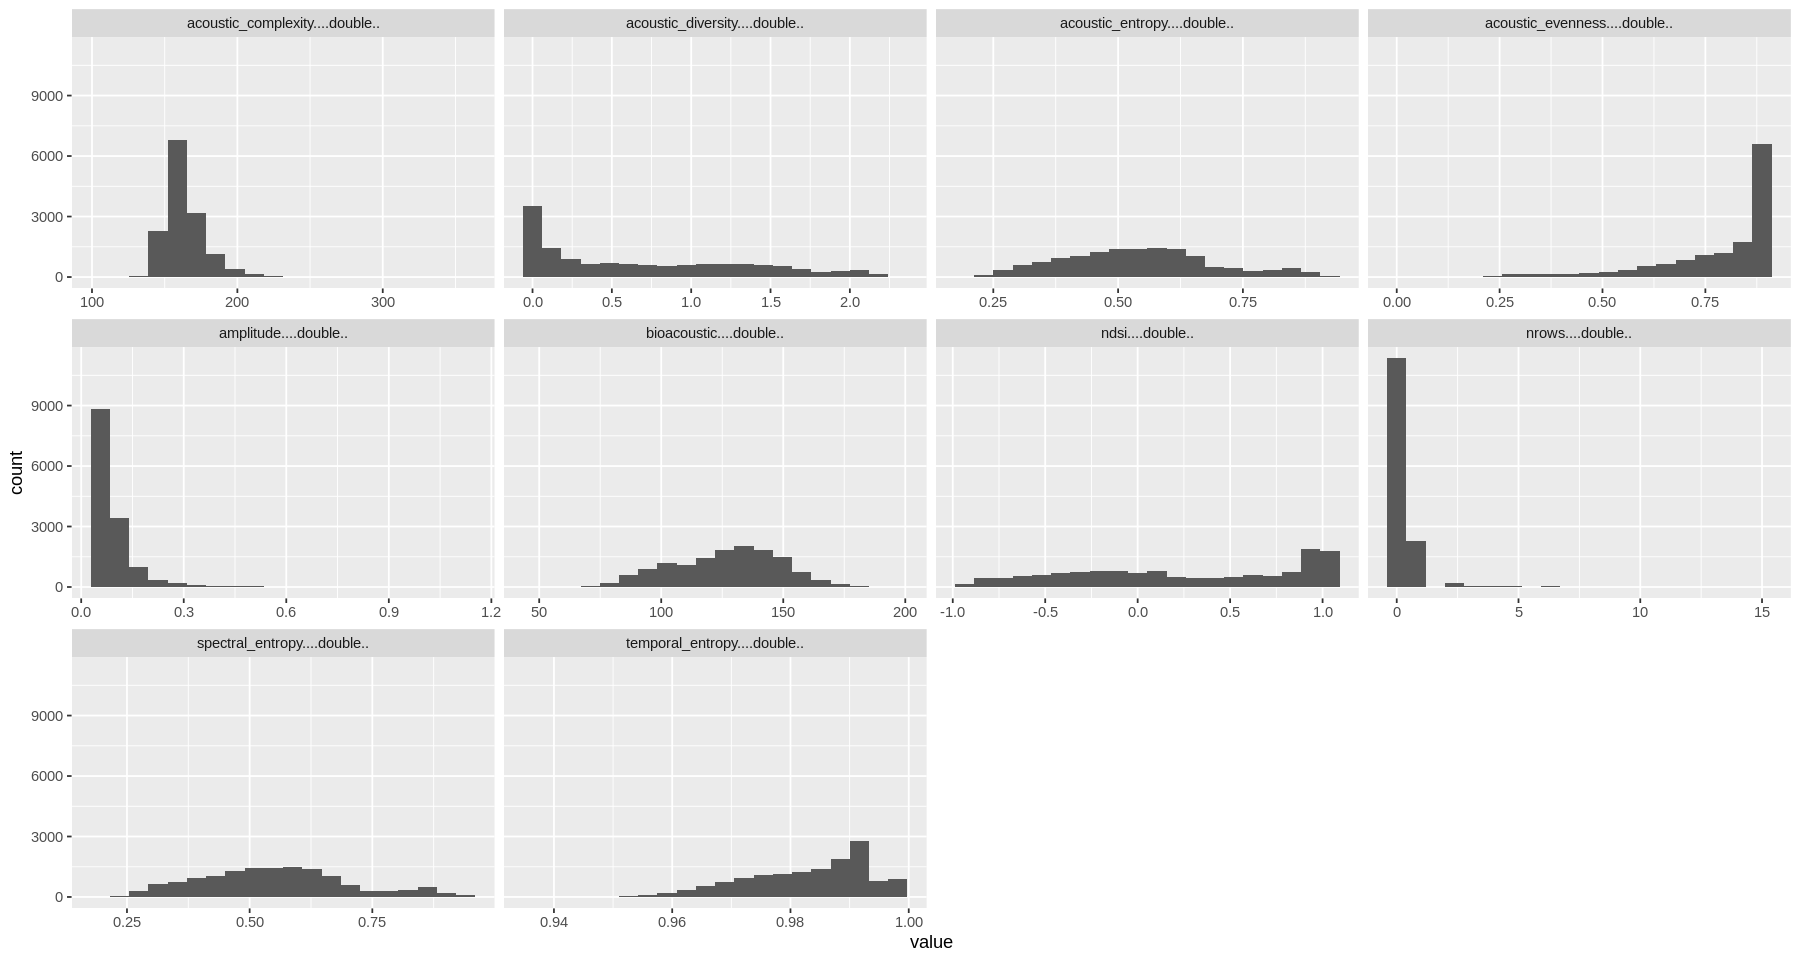

In [78]:
ggplot(gather(index_data[,4:13]), aes(value)) + 
    geom_histogram(bins = 20) + 
    facet_wrap(~key, scales = 'free_x')

Basic Summarization Statistics are given for each of the alpha indices.

In [79]:
summary(index_data)
#colnames(index_data)

            Site      Date....as.Date.character....format.....Y..m..d..
 Tumamoc_NA   :1827   2019-04-14:  542                                 
 Sweetwater_NA:1571   2018-09-07:  528                                 
 Saguaro_NP   :1522   2018-09-08:  528                                 
 Gates_Pass   :1379   2019-06-09:  528                                 
 Ruth_NA      :1231   2019-06-10:  528                                 
 Theresa_NA   :1197   2019-06-11:  528                                 
 (Other)      :5366   (Other)   :10911                                 
 Time....character.. bioacoustic....double.. amplitude....double..
 15:0:0 :   54       Min.   : 48.39          Min.   :0.03201      
 15:10:0:   53       1st Qu.:110.06          1st Qu.:0.04953      
 15:15:0:   53       Median :128.44          Median :0.06864      
 15:5:0 :   53       Mean   :126.22          Mean   :0.09350      
 2:0:0  :   53       3rd Qu.:142.35          3rd Qu.:0.10508      
 2:10:0 :   53       M

## Clustering/PCA

First, we scale the data:

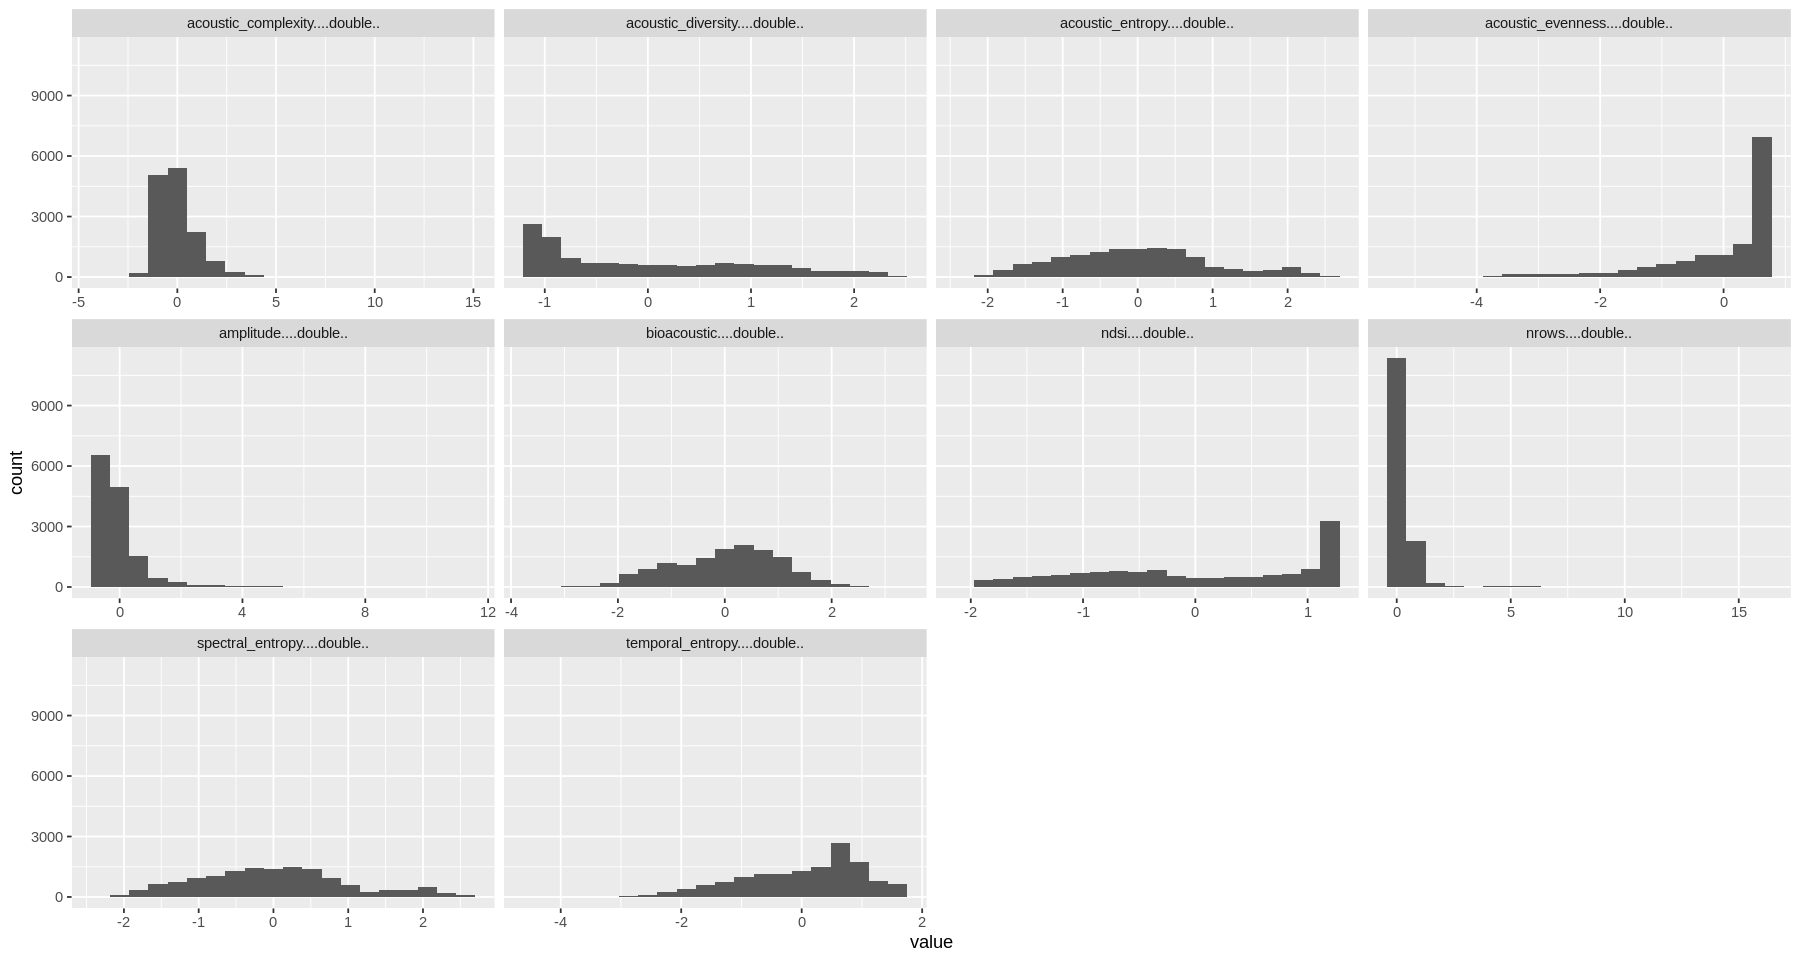

In [80]:
index_data[,4:13] <- scale(index_data[,4:13])
ggplot(gather(index_data[,4:13]), aes(value)) + 
    geom_histogram(bins = 20) + 
    facet_wrap(~key, scales = 'free_x')


Using the average silhouette metric, we see that two is the most natural clustering, with a local maximum of average silhoutte at 10 clusters. 

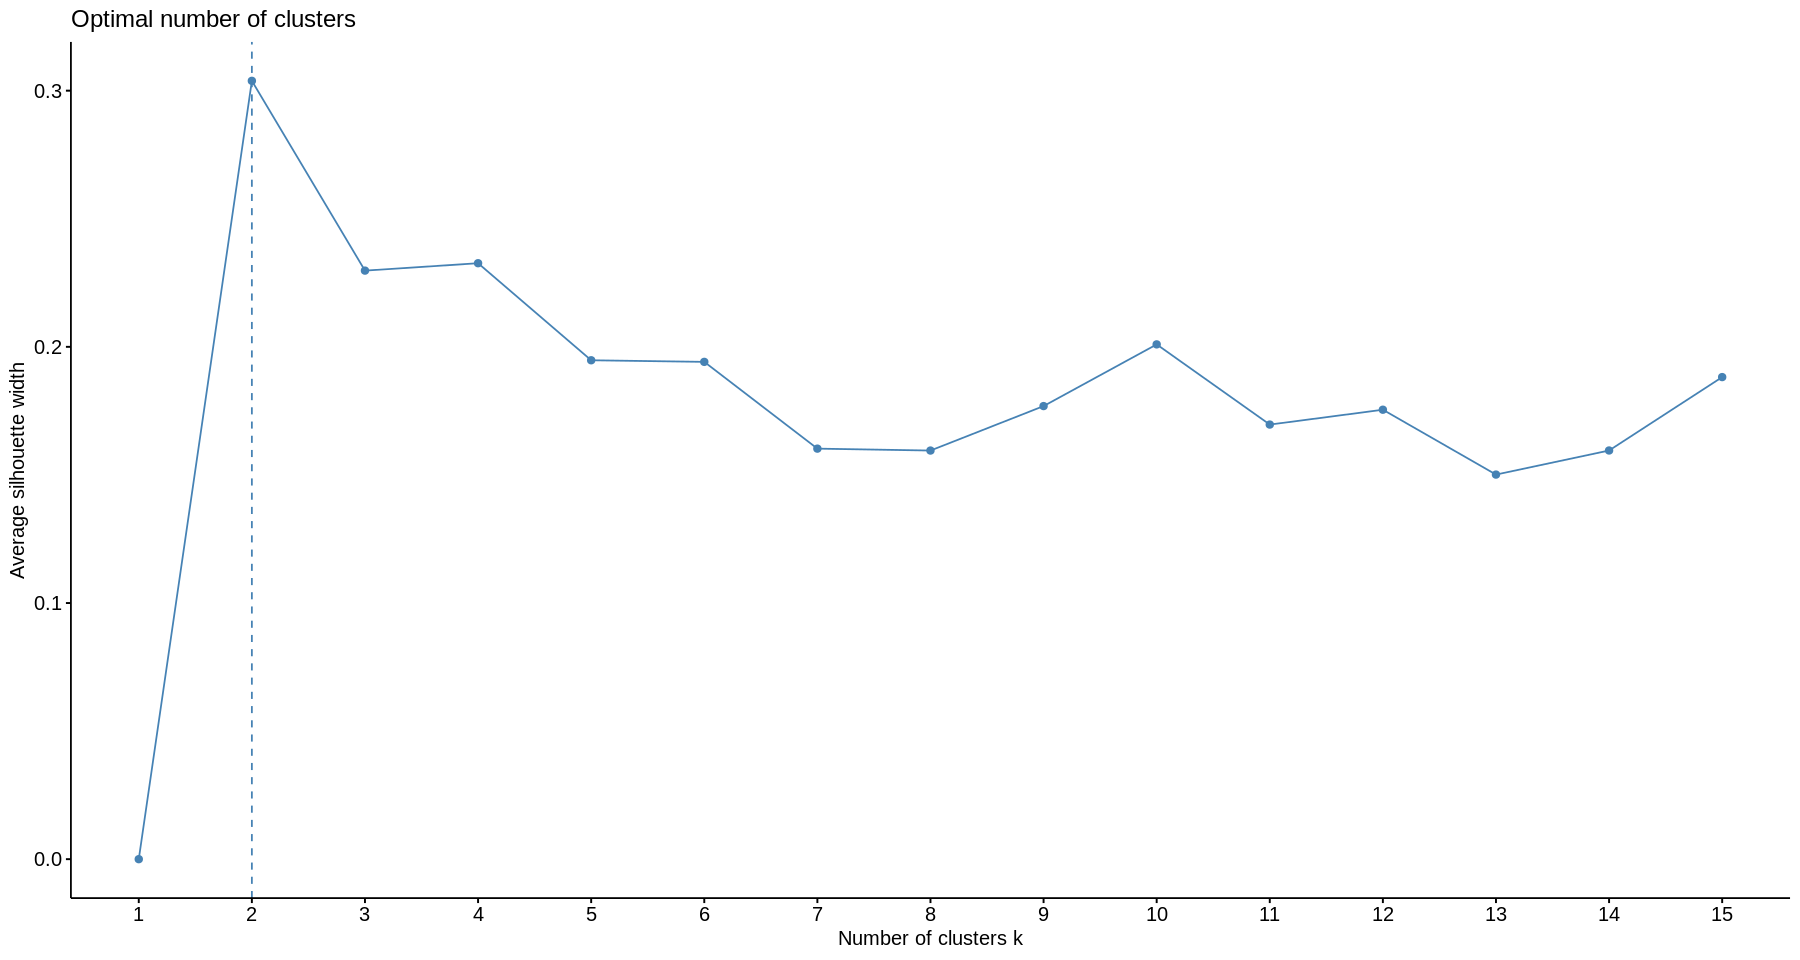

In [81]:
fviz_nbclust(index_data[,4:13],FUNcluster=clara,method = "silhouette",k.max=15,verbose=TRUE)

The cluster sizes and means of a clustering with 10 clusters are given below, along with a two-dimensional graph of the clusters with the two-dimensions given by the first two principal components:

A histogram indicating the frequency of the hour of the recording in each cluster given below(a histogram for every cluster).

In [90]:
splitter <- function(x) {return(strsplit(x,":")[[1]][1])}
'%notin%' <- Negate(`%in%`)
euclidean <- function(cluster,center,clust_num) {
    square_dist <- 0
    for (index in 1:10) {
        #print(as.numeric(as.character(cluster[,3+index])))
        #print(as.numeric(as.character(center[num_clusters,index])))
        square_dist <- square_dist + (as.numeric(as.character(cluster[,3+index]))-as.numeric(as.character(center[clust_num,index])))^2
    }
    return(sqrt(square_dist))
}
histogram_plotter <- function(fit,data) {
    sites<-unique(index_data$Site)
    times<-c(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23)
    total_site_counts <- data %>% 
             count(vars = c("Site")) 
for (i in 1:length(fit$size)){
    cluster <- subset(data, fit.cluster==as.character(i))
    cluster$hr <- sapply(as.character(cluster$Time....character..),splitter)
    time_counts <- cluster %>% 
                count(vars = c("hr"))
    for (time in times){
        if (time %notin% unique(time_counts$hr)){
            time_counts<-rbind(time_counts,c(time,0))
        }        
    }
    
    time_counts = mutate(time_counts,hr=factor(hr, levels=times))
    site_counts <- cluster %>% 
                count(vars = c("Site")) 
    for (site in sites){
        if (site %notin% unique(site_counts$Site)){
            site_counts<-rbind(site_counts,c(site,0))
        }        
    }
    site_counts <- merge(site_counts,total_site_counts,by="Site")
    #site_counts <- site_counts %>% mutate(percent=site_counts[freq.x/freq.y)
    
    site_counts <- transform(site_counts, percent = as.numeric(freq.x) / as.numeric(freq.y))
    cluster <- mutate(cluster,dist=euclidean(cluster,fit$centers,i))
    closest <- cluster[which.min(cluster$dist), ]
    
    if (strsplit(as.character(closest$Site[1]),"_")[[1]][2]=="NA") {
        site <- strsplit(as.character(closest$Site[1]),"_")[[1]][1]
    }
    else {
        site <-as.character(closest$Site[1])
    }
    date <- as.character(closest$Date....as.Date.character....format.....Y..m..d..[1])
    time <- as.character(closest$Time....character..[1]) 
    
    time_plot<-ggplot(time_counts) + geom_bar(aes(x = hr, y = freq), stat="identity") + ggtitle(paste("Time Frequency of Cluster with Center Closest to",site,date,time))+theme(axis.text.x = element_text(face = "bold", color = "#993333", 
                           size = 12, angle = 90))
    site_plot<-ggplot(site_counts) + geom_bar(aes(x = Site, y = as.numeric(as.character(freq.x)) ), stat="identity") + ggtitle(paste("Site Frequency of Cluster with Center Closest to",site,date,time))+theme(axis.text.x = element_text(face = "bold", color = "#993333", 
                           size = 12, angle = 90))
    percent_plot<-ggplot(site_counts) + geom_bar(aes(x = Site, y = percent), stat="identity") + ggtitle(paste("Percentage of Site Recordings within Cluster with Center Closest to",site,date,time))+theme(axis.text.x = element_text(face = "bold", color = "#993333", 
                           size = 12, angle = 90)) + ylim(0, 1)
    print(plot_grid(time_plot, site_plot,percent_plot))
}
    }



[1]  255 2563 1094  198 1516 3451 1118 2310  822  766

bioacoustic....double.. amplitude....double.. temporal_entropy....double..
1  -0.5148997               5.49553350            0.1677392                  
2  -0.2075520               0.22113843           -1.2900248                  
3   0.0532464               0.02761399           -0.8435326                  
4  -1.2705198               0.64263252           -0.1146382                  
5  -1.1983393              -0.53976006            0.9677505                  
6   0.4241965              -0.11117244            0.2463223                  
7   1.0385644              -0.35083234            0.6725236                  
8   0.6929031              -0.33285915            0.7761496                  
9  -0.7228853              -0.02296410           -0.7403561                  
10 -1.2508648               0.33466613           -0.0578316                  
   spectral_entropy....double.. acoustic_entropy....double..
1  -1.25049408                  -1.24357679                 
2  -1.05758079                  -1.09008795                 
3  -0.03254306                  -0.06538071                 
4   2.19272653                   2.17696977                 
5  -1.07736327                  -1.05019153                 
6  -0.03196597                  -0.02395441                 
7   0.28899841                   0.31318842                 
8   0.59865717                   0.62903906                 
9   1.75998222                   1.71278315                 
10  1.59502794                   1.58631642                 
   acoustic_diversity....double.. acoustic_evenness....double..
1  -0.6808050                      0.5610549                   
2  -0.9370835                      0.7147214                   
3  -0.1253724                      0.2860538                   
4   1.8648469                     -2.5183812                   
5  -0.6981661                      0.6047041                   
6  -0.5536861                      0.5578504                   
7   0.7972296                     -0.5363044                   
8   0.8189963                     -0.4995229                   
9   1.8668240                     -2.4037001                   
10  1.2986229                     -1.1772177                   
   acoustic_complexity....double.. nrows....double.. ndsi....double..
1   1.7094763                      -0.29682793       -0.41459597     
2   0.3711454                      -0.30943571       -0.53529405     
3  -0.1300877                      -0.02098104        0.84579663     
4  -0.3226738                       6.71086218        1.09717760     
5  -0.6093305                      -0.21702394       -0.09774857     
6  -0.3780915                      -0.18376091       -1.04819555     
7   1.2757320                      -0.10950988        0.70812675     
8  -0.5369354                       0.17695439        0.68679076     
9   1.7591551                       0.04474325        1.05138353     
10 -0.7629125                       0.26505617        1.12041514

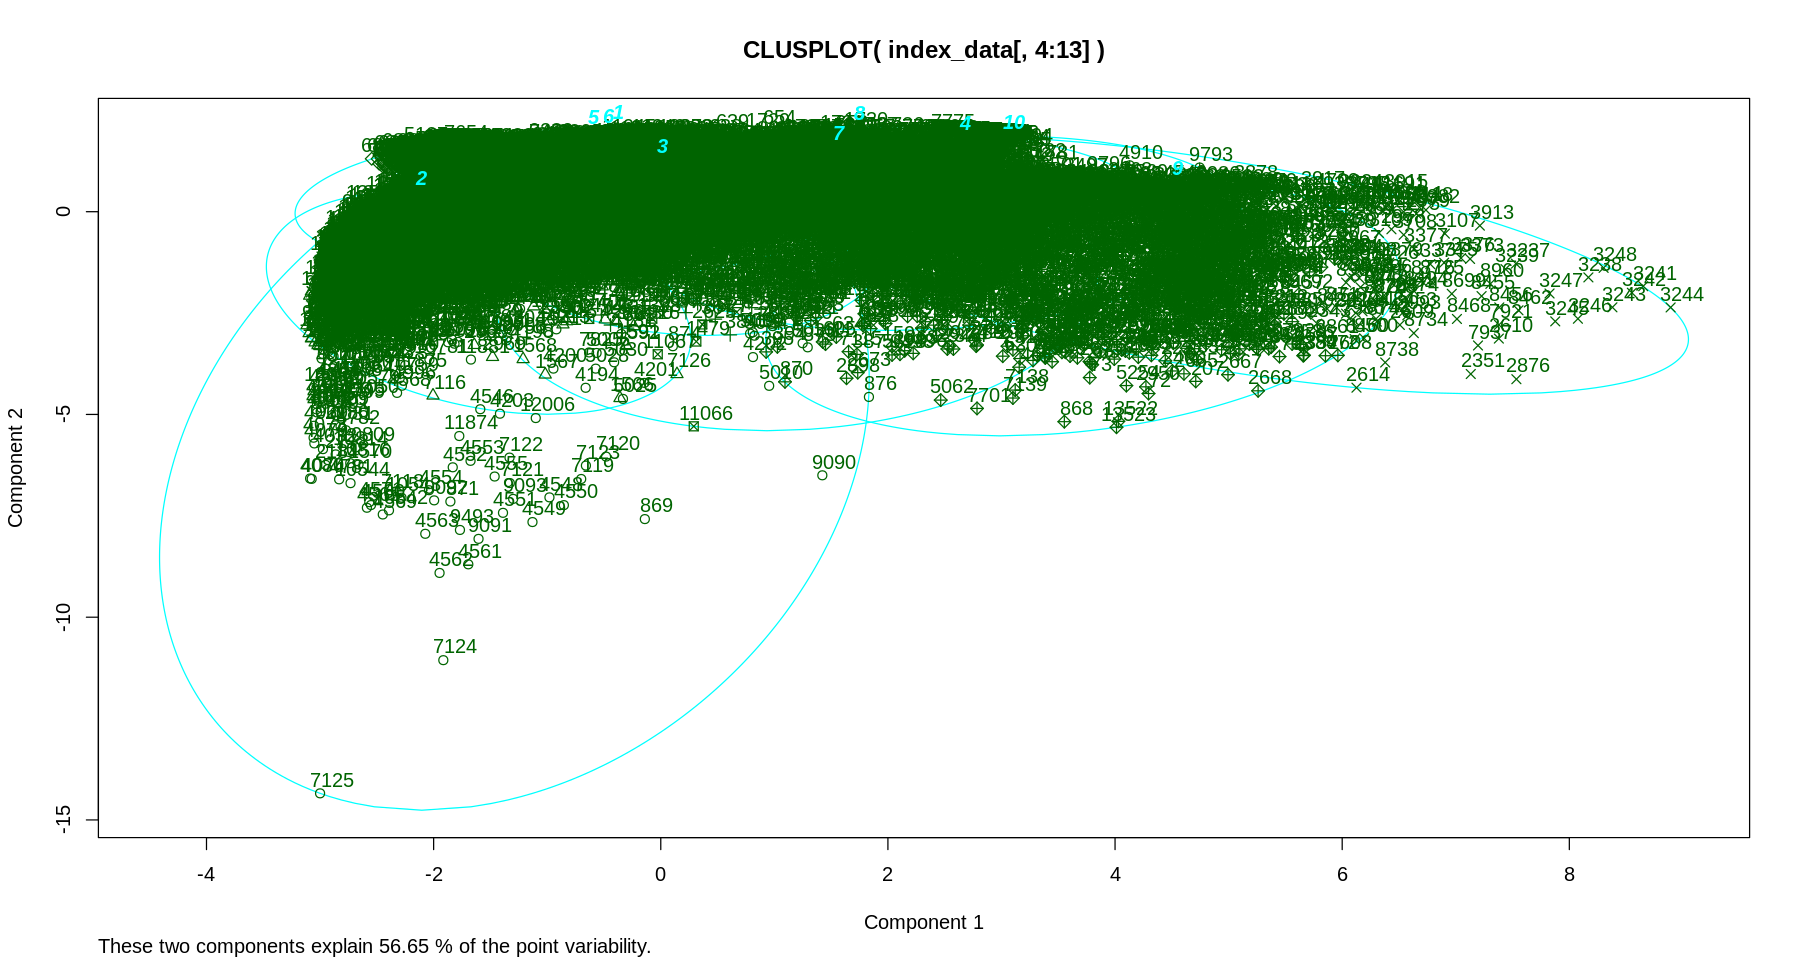

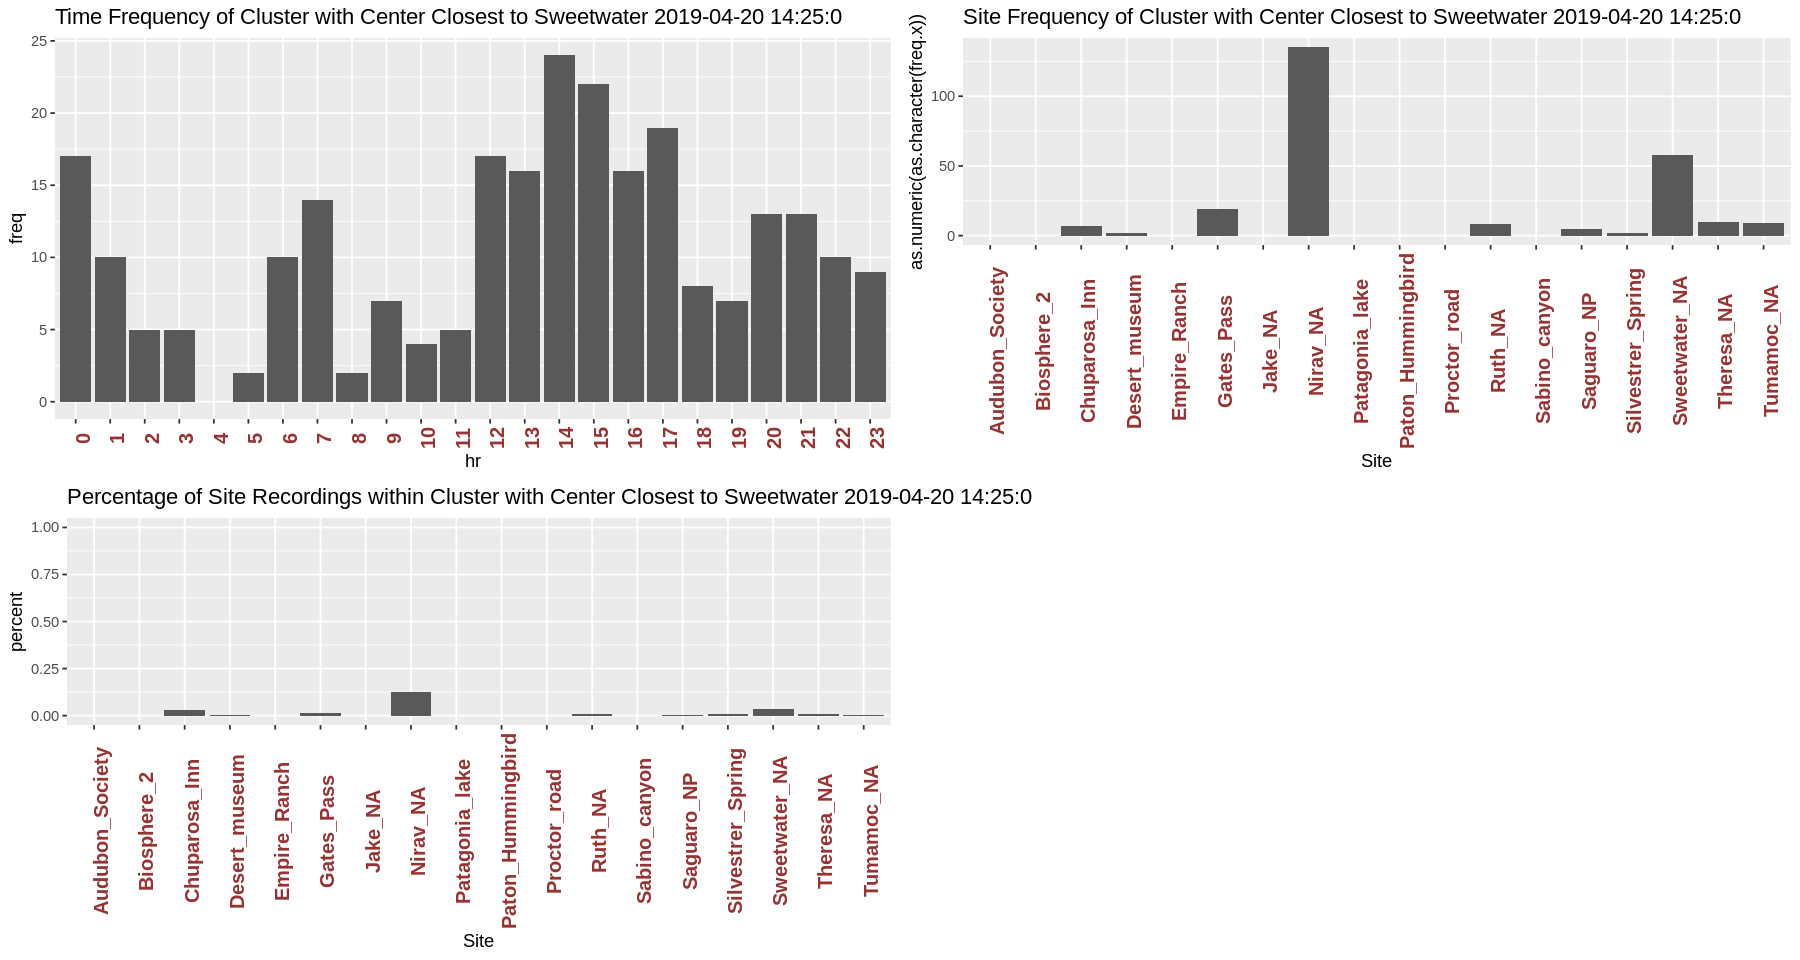

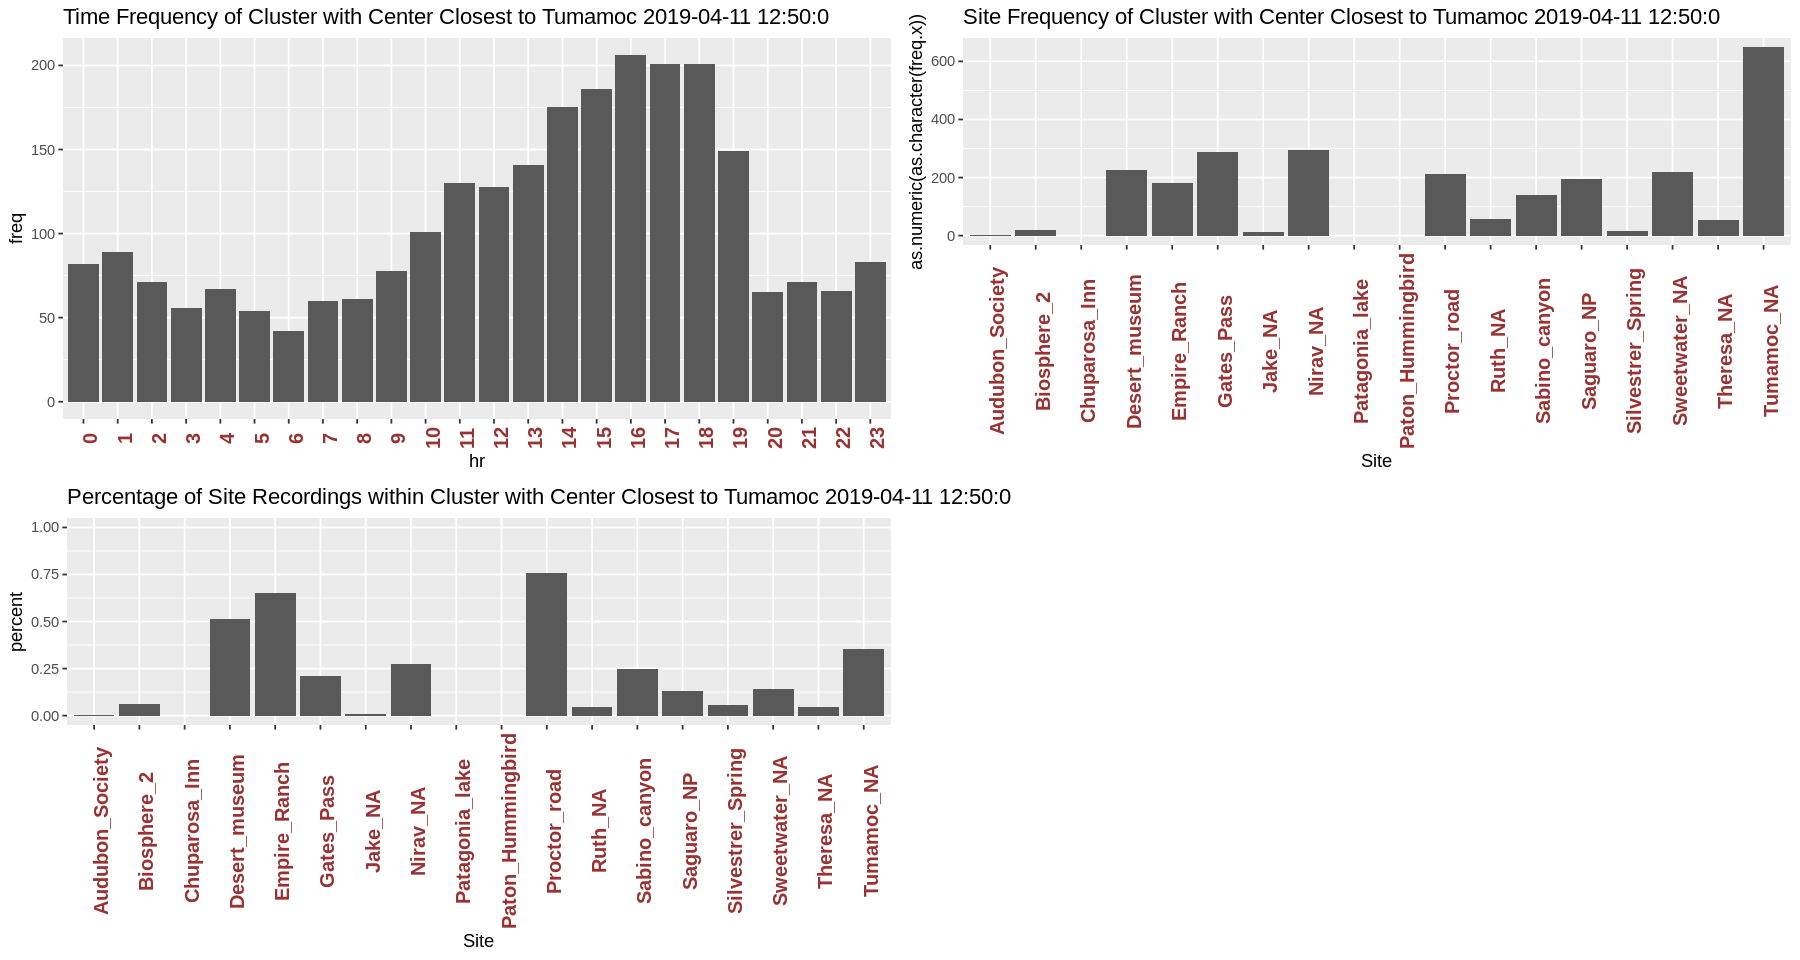

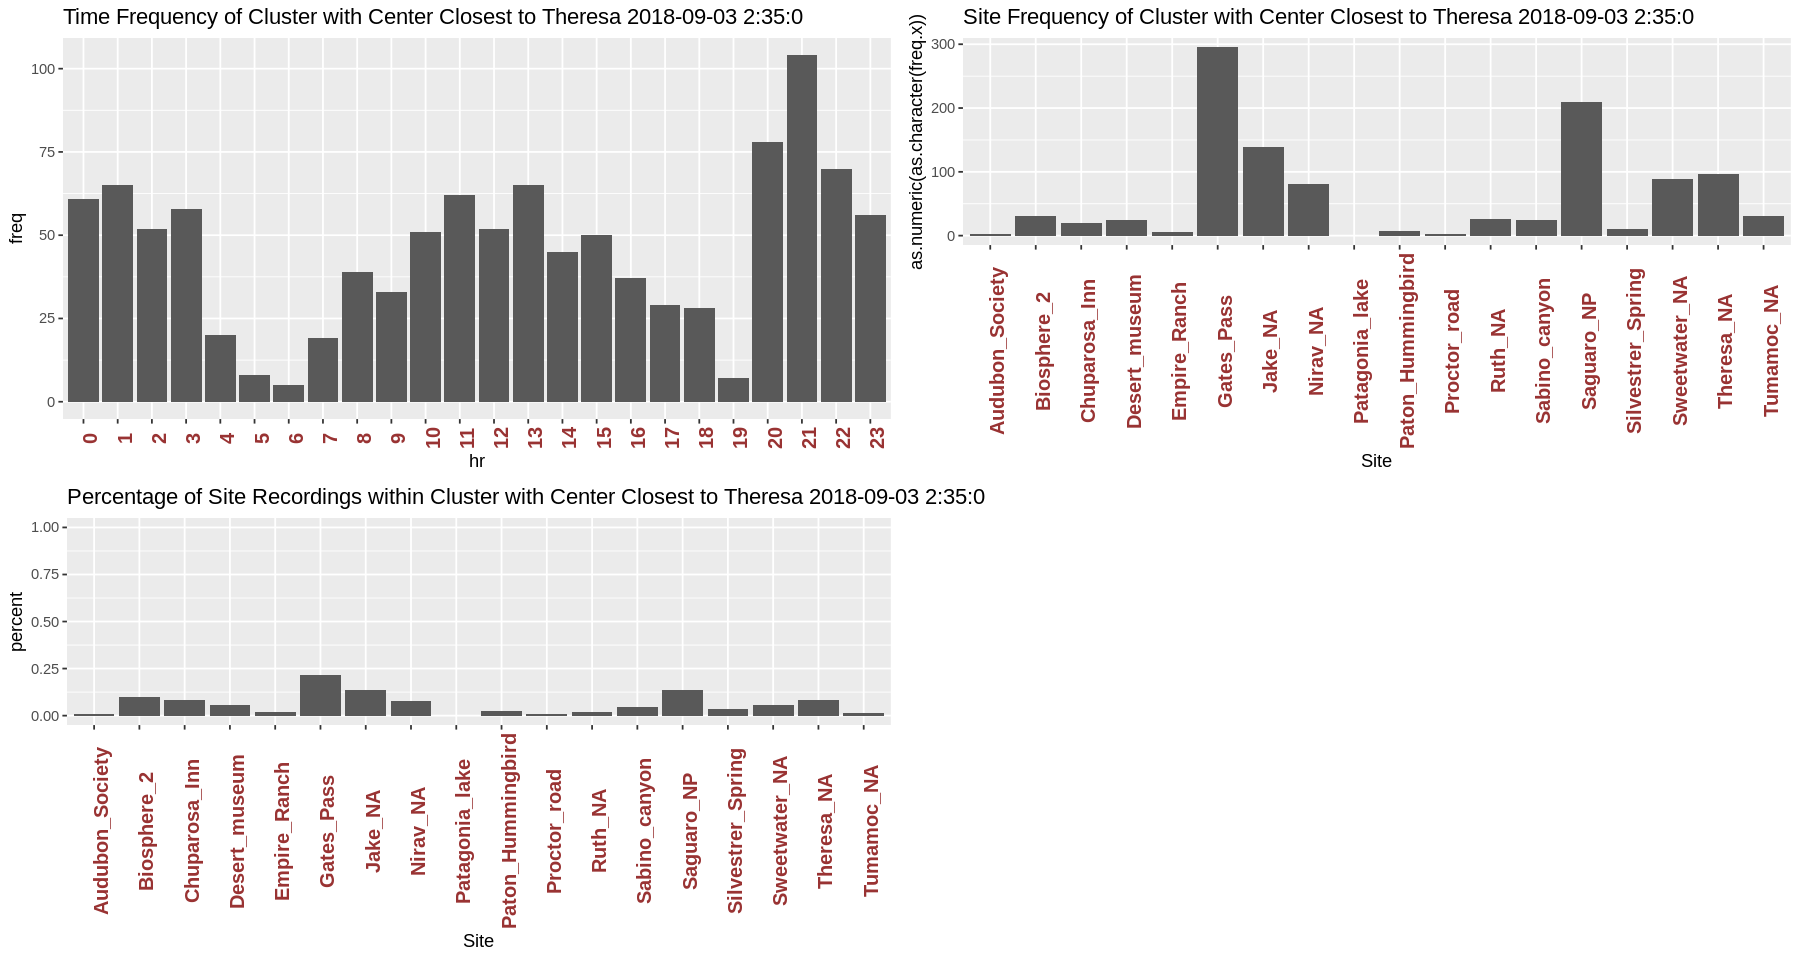

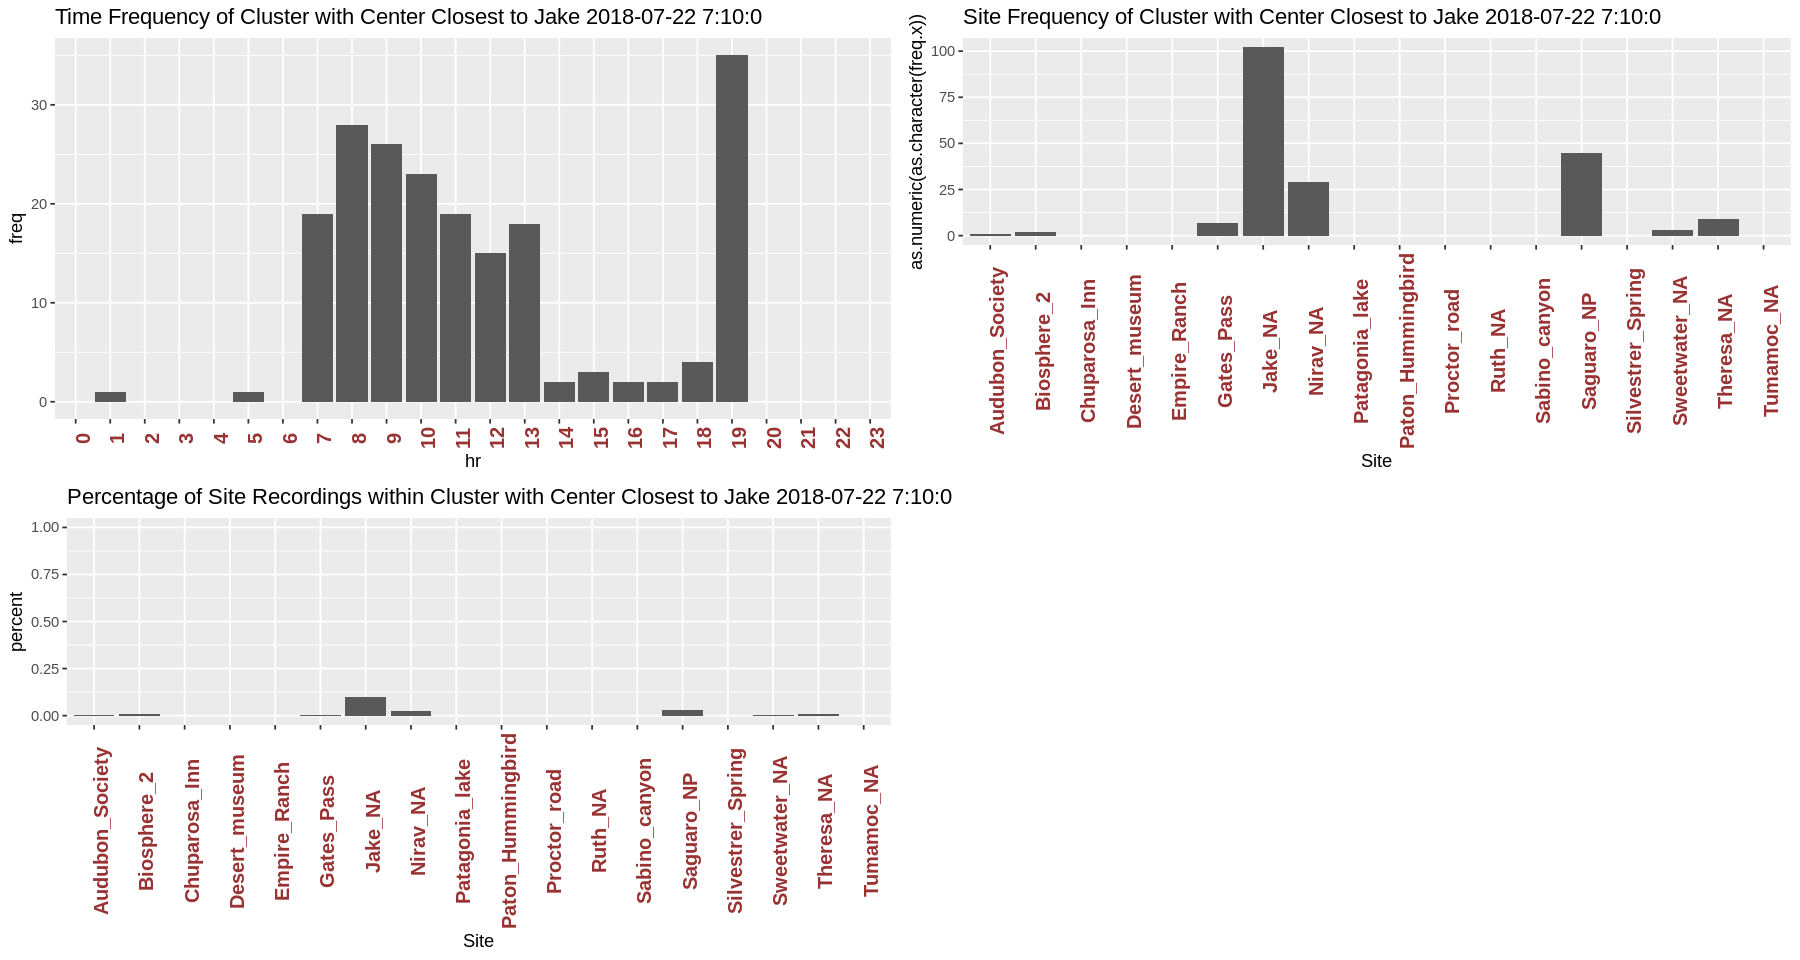

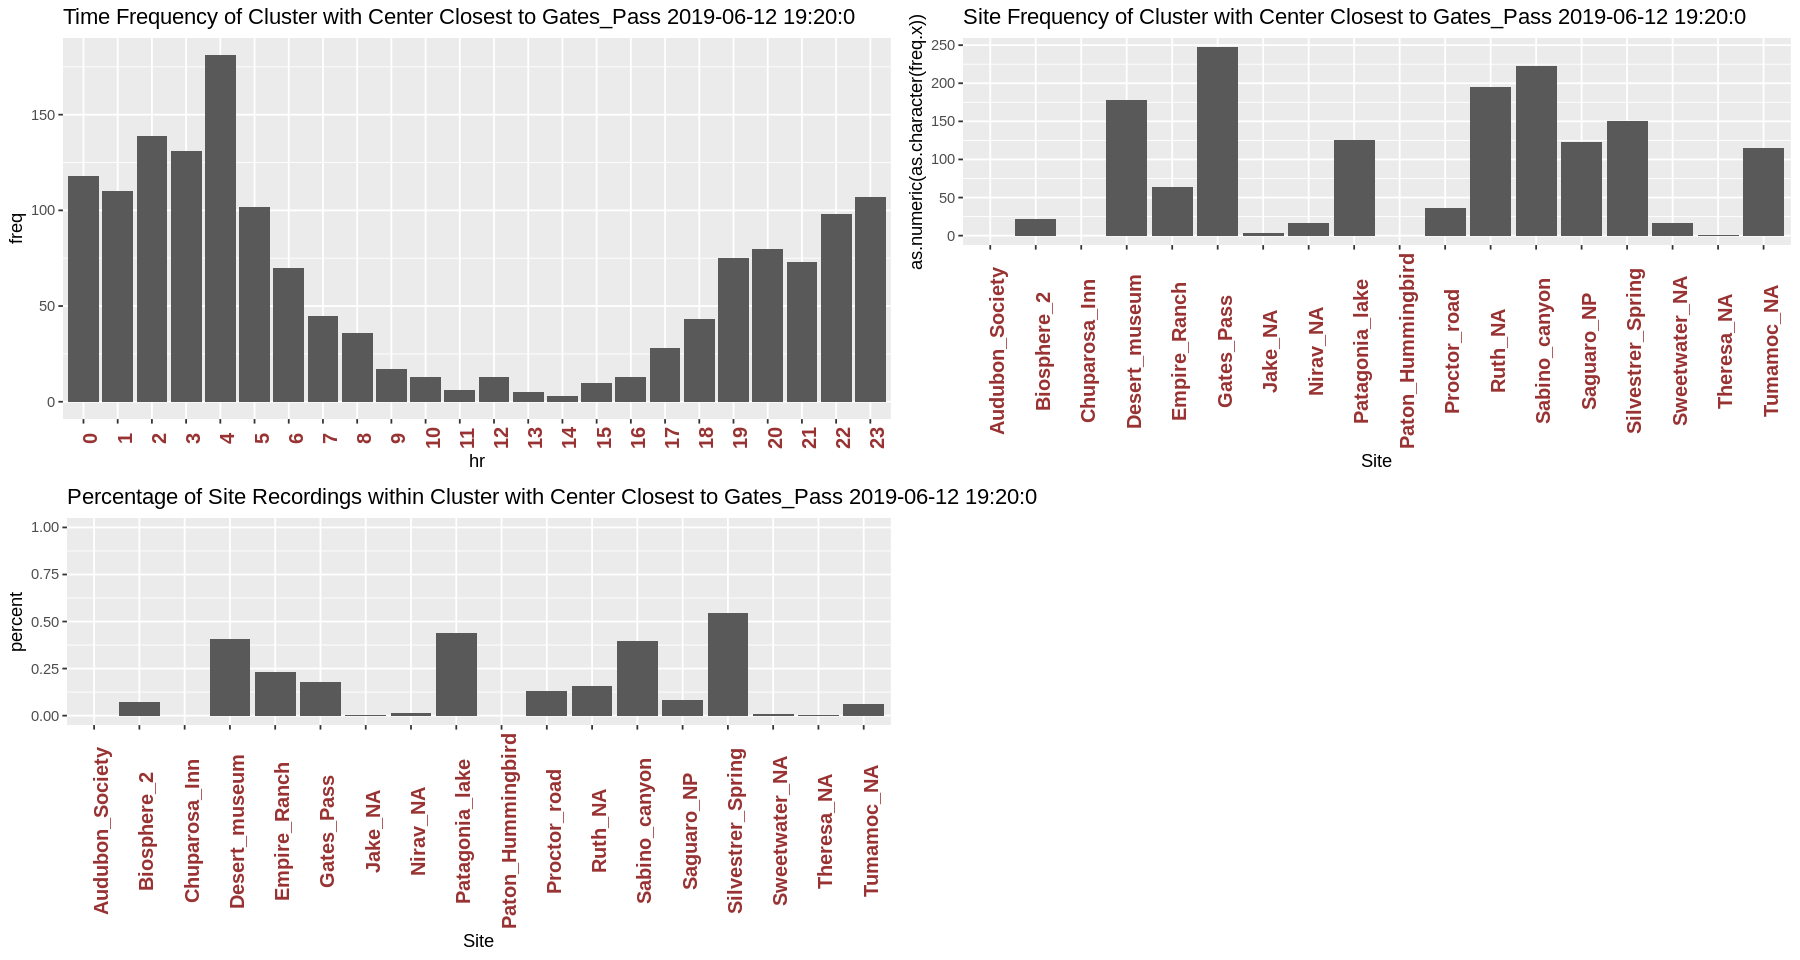

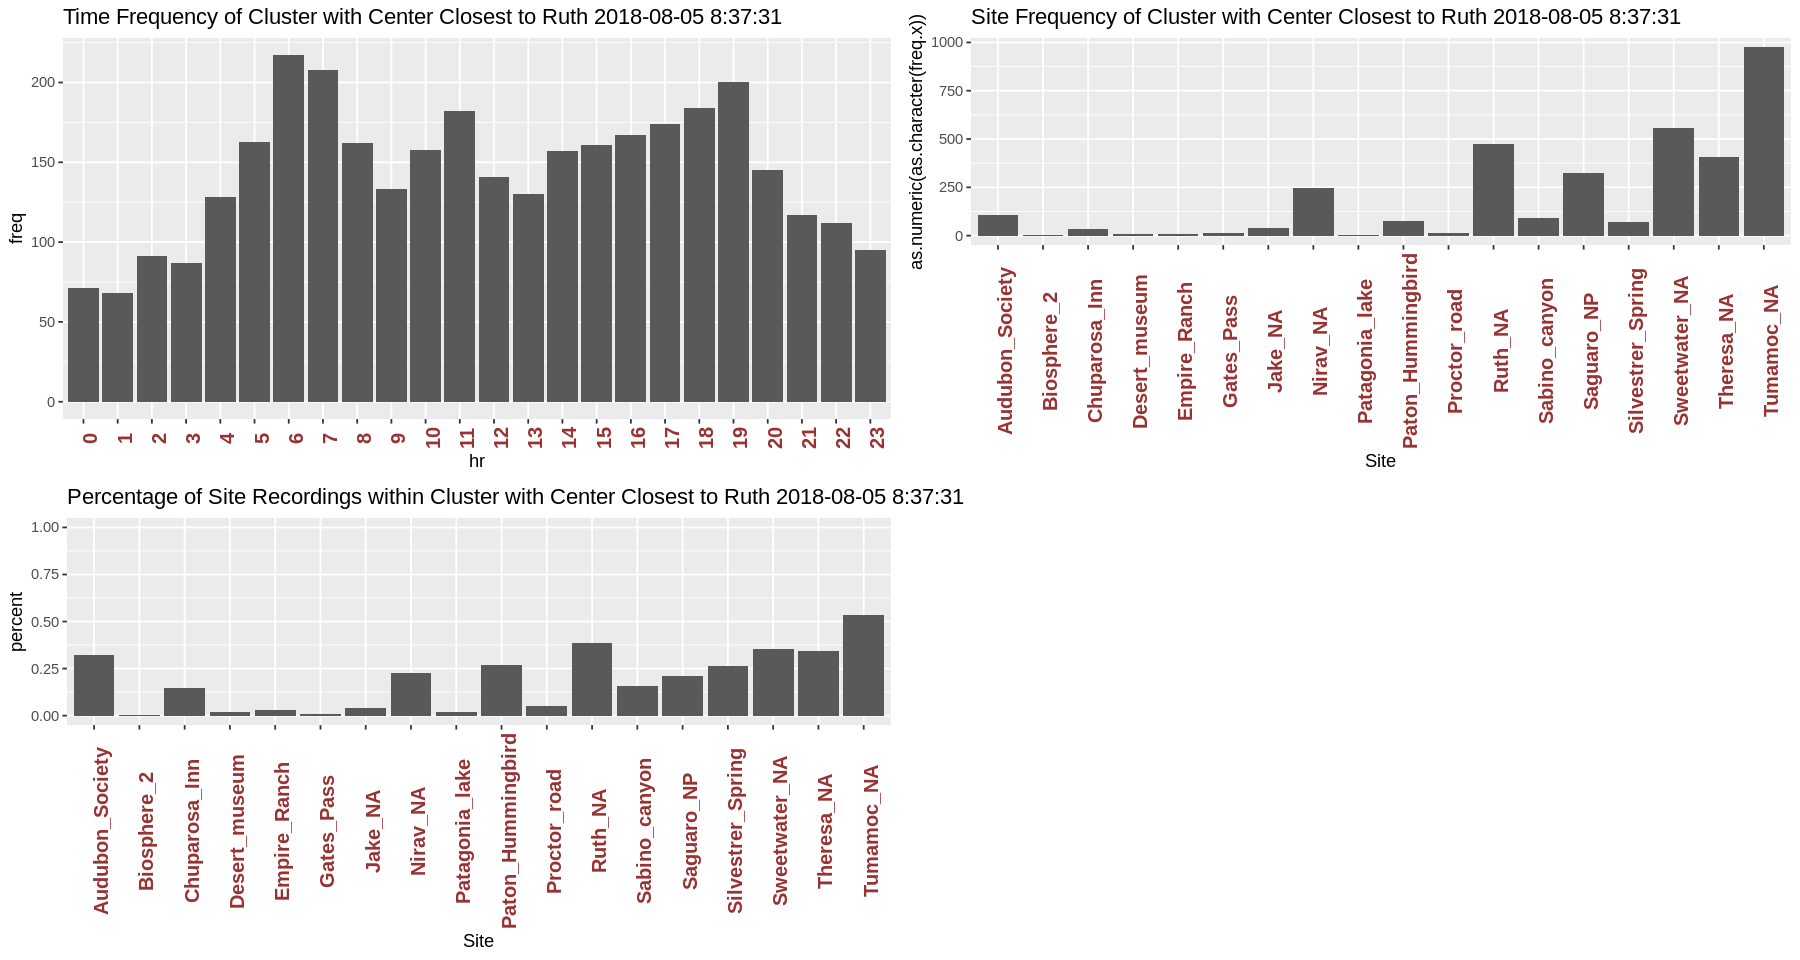

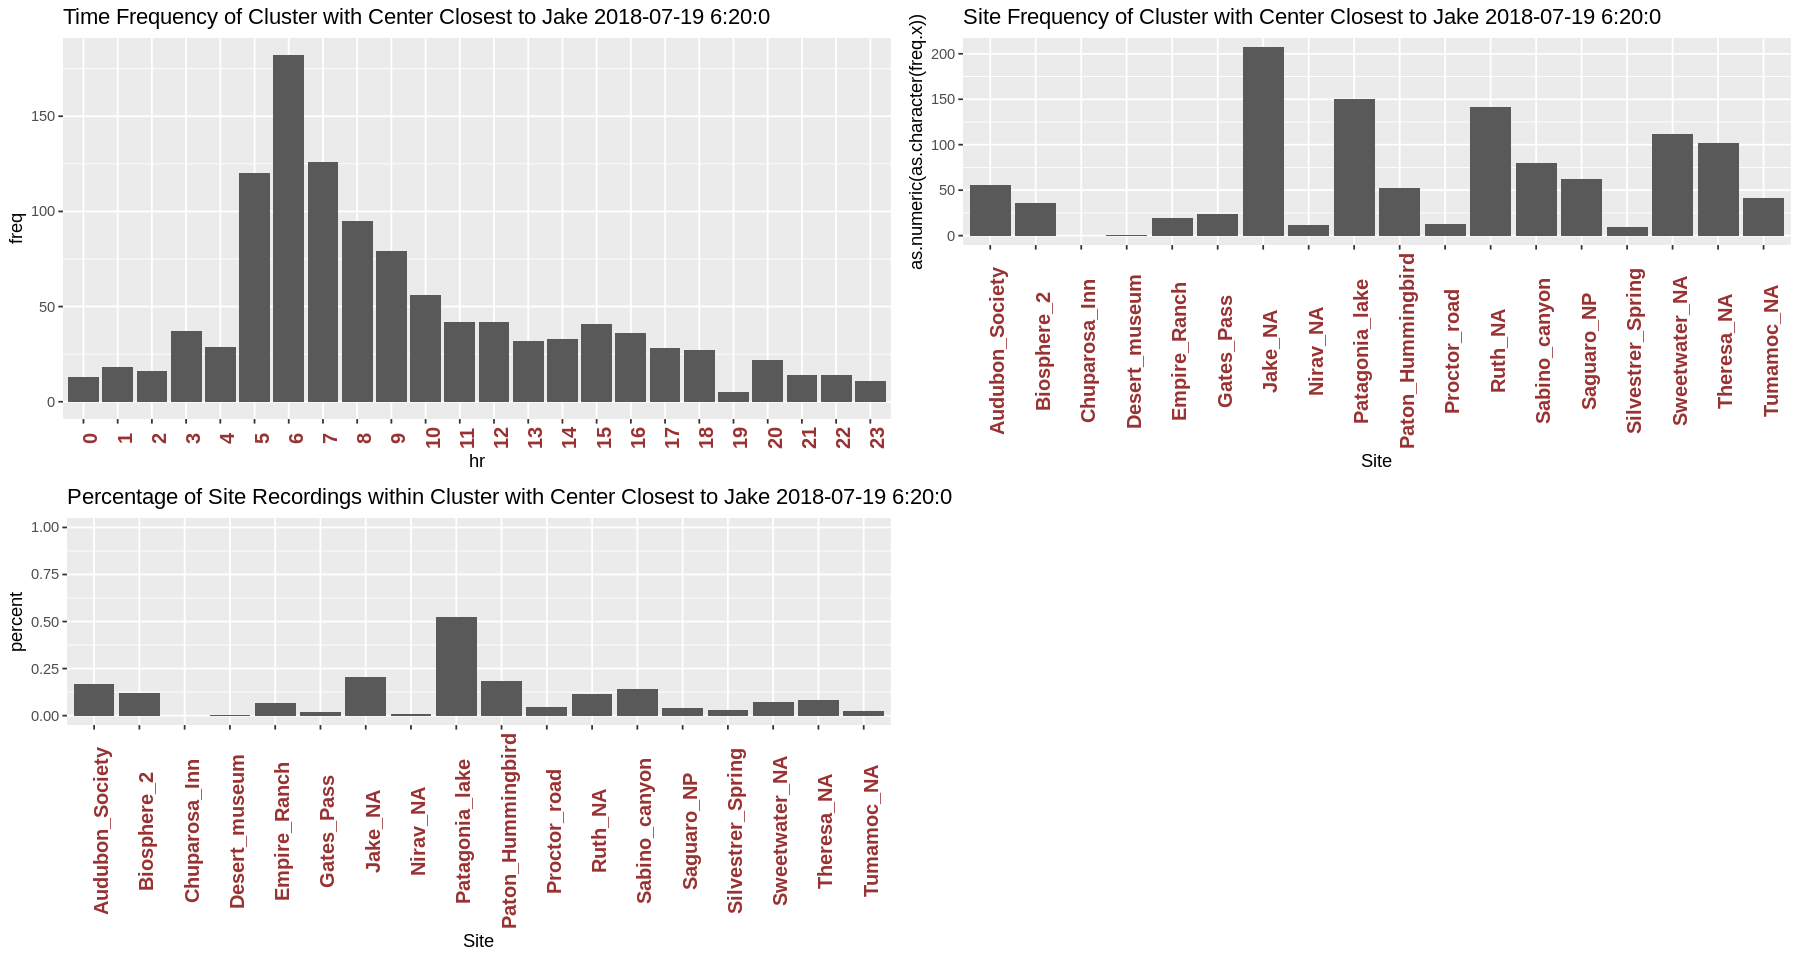

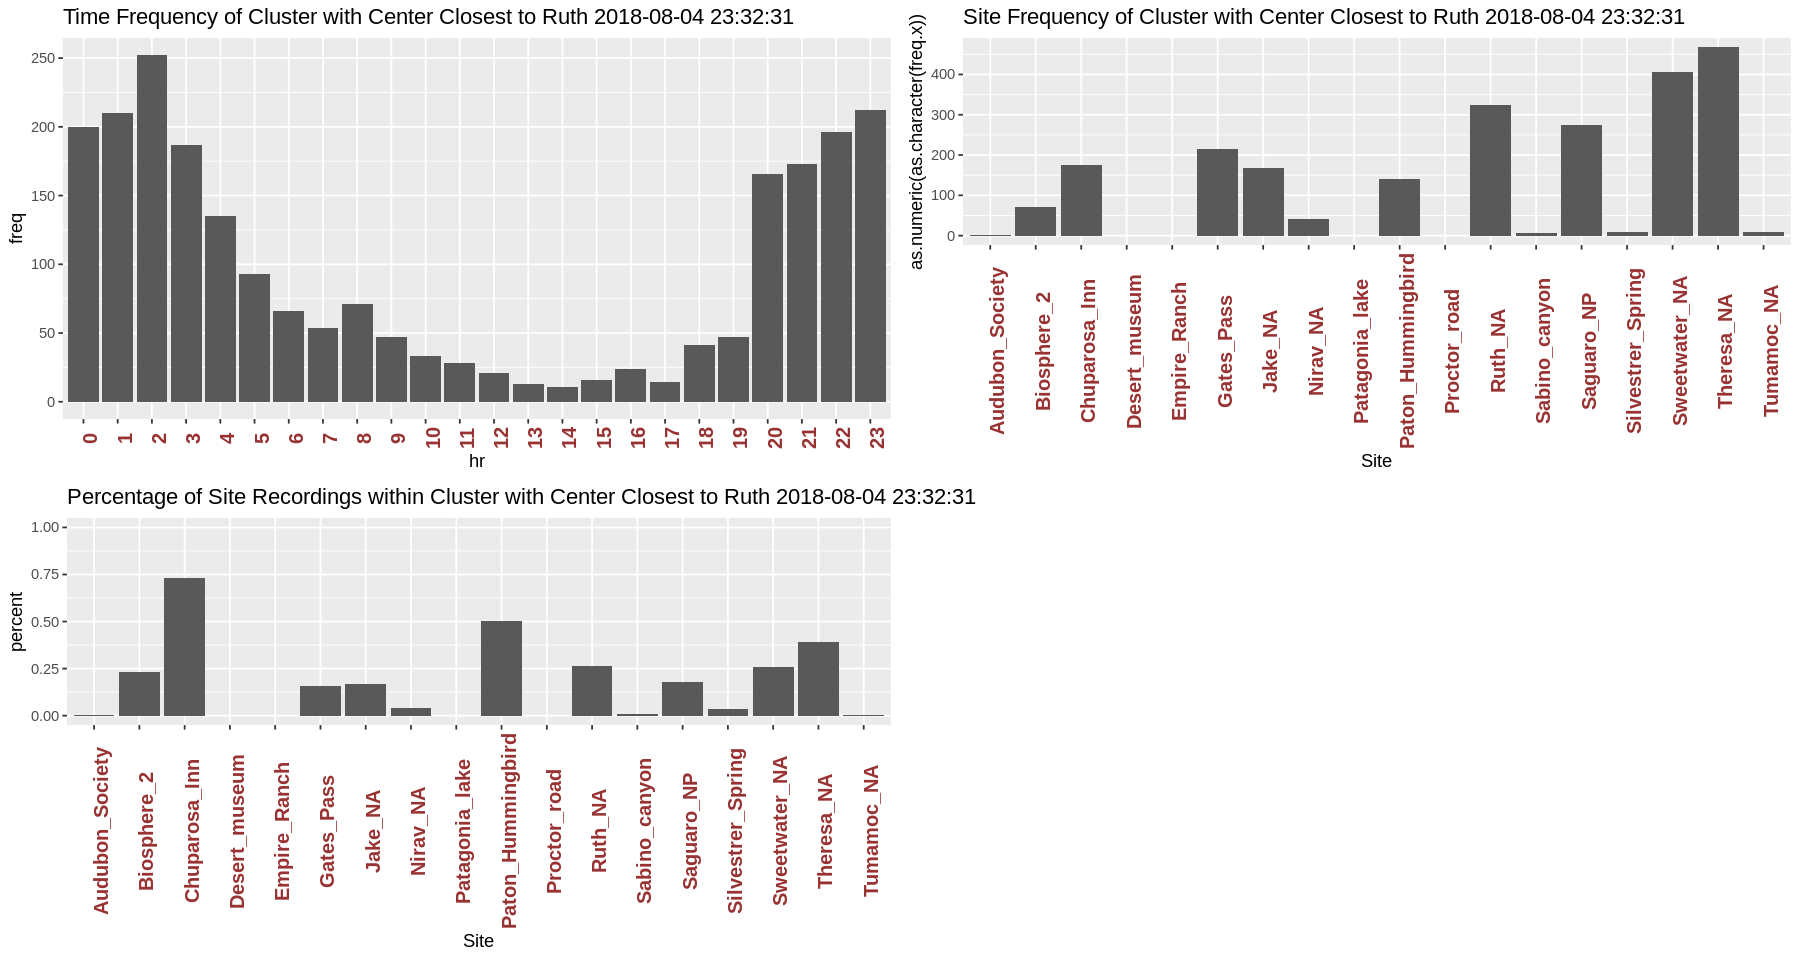

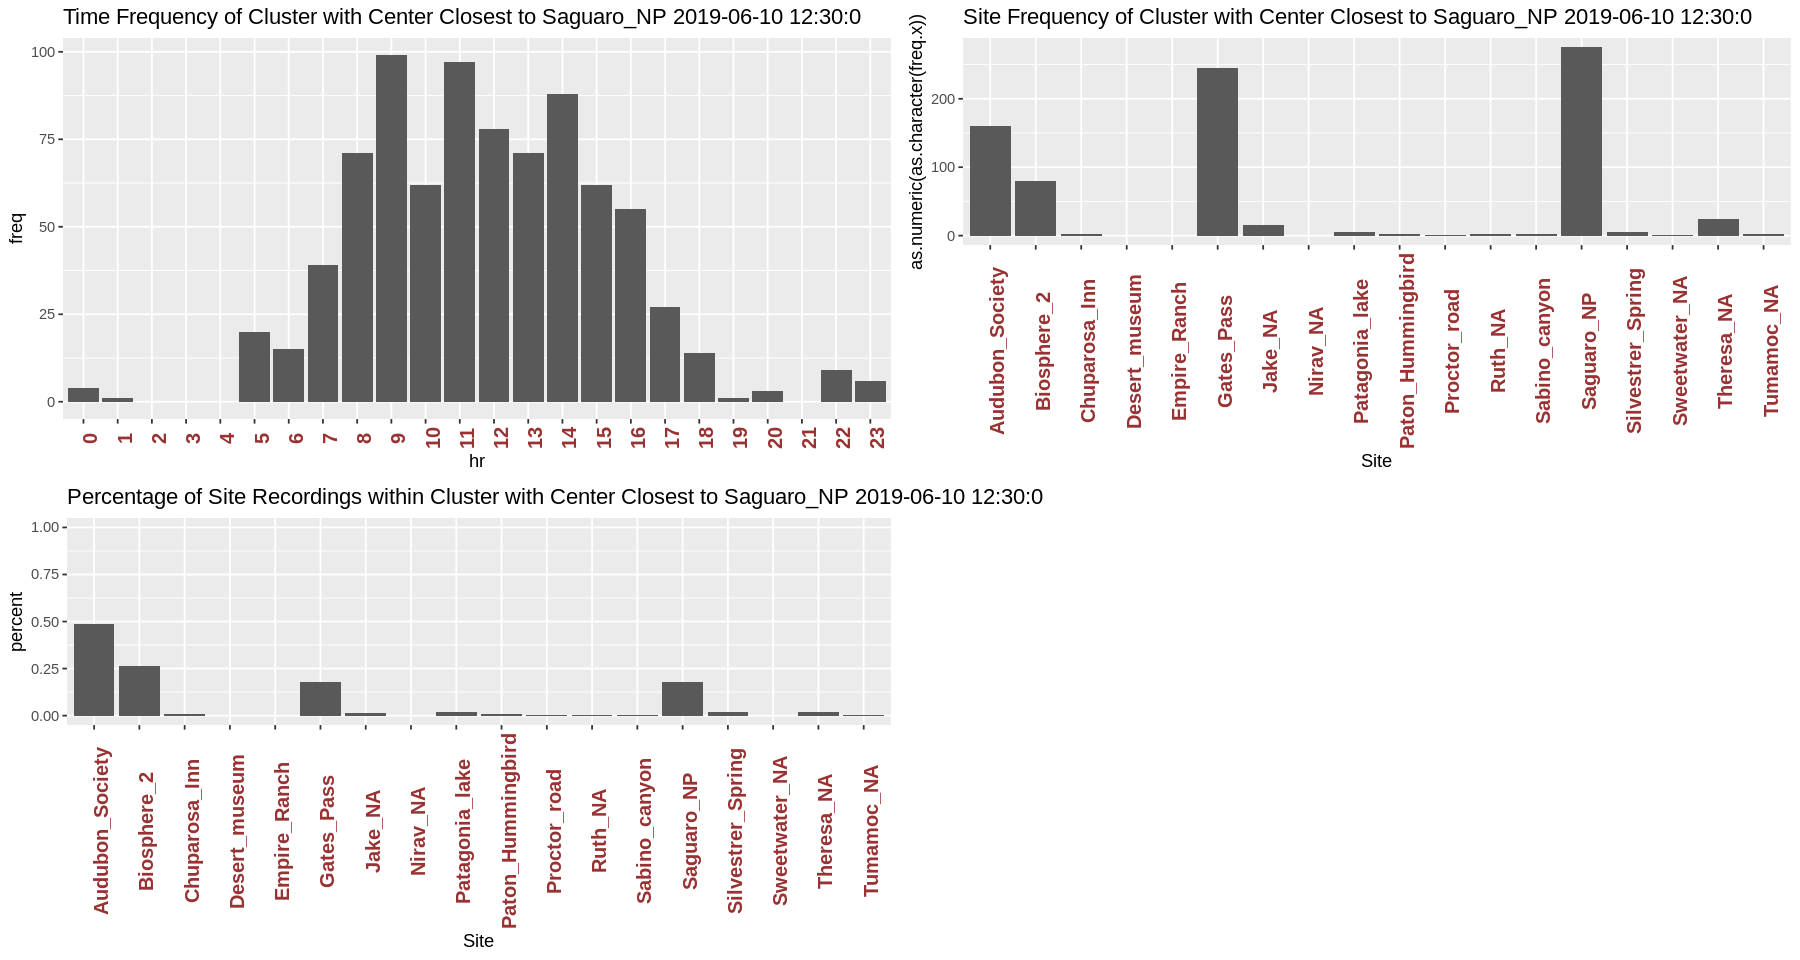

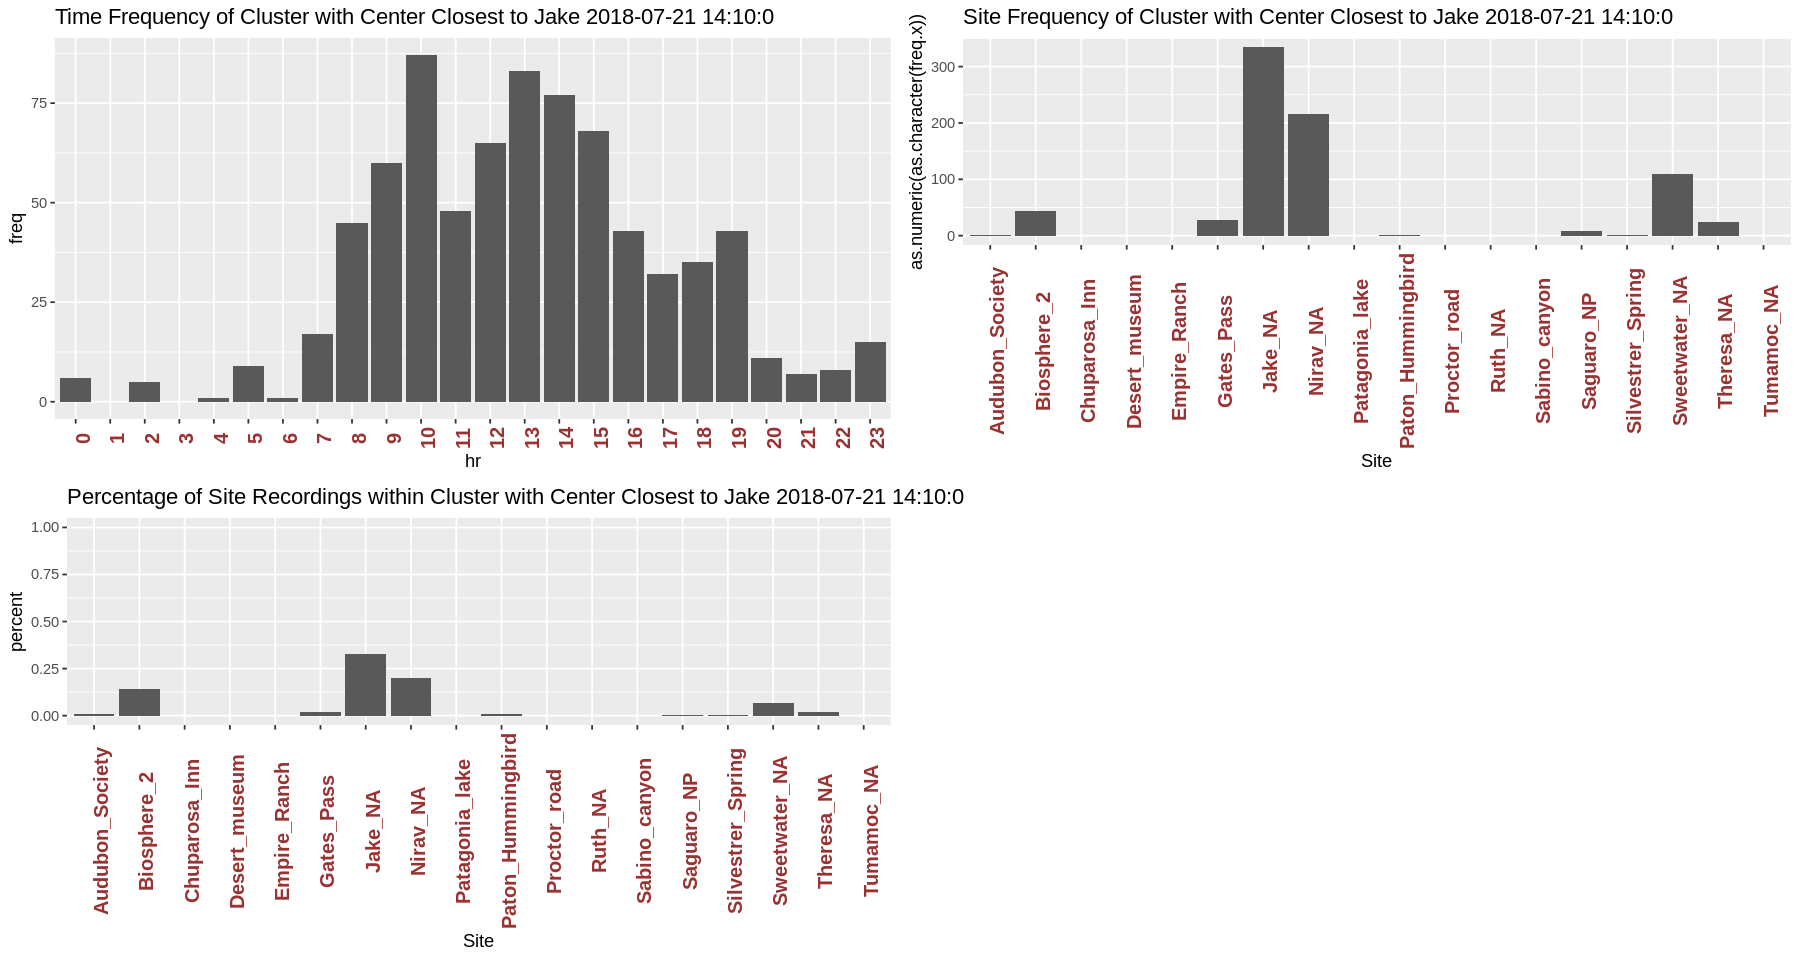

In [91]:
# K-Means Clustering with 10 clusters
fit <- kmeans(index_data[,4:13],10,iter.max=30)
fit$size
fit$centers
# Cluster Plot against 1st 2 principal components

# vary parameters for most readable graph
clusplot(index_data[,4:13], fit$cluster, color=FALSE, shade=FALSE,
   labels=2, lines=0)

histogram_plotter(fit,data.frame(index_data, fit$cluster))

A histogram indicating the frequency of the site of the recording in each cluster given below(a histogram for every cluster).

[1]   86 1933  724  912  678 1207  383 1838  679  538  197 1573 1711 1239  395

bioacoustic....double.. amplitude....double.. temporal_entropy....double..
1  -1.0356352               8.48014388            0.61734464                 
2   0.8611668              -0.10304219            0.31660997                 
3  -1.2503941               0.32416725           -0.02346101                 
4  -0.9059424              -0.06182802           -1.34753539                 
5  -0.4343543               0.10613888           -0.96229577                 
6  -1.2455285              -0.58221746            1.12244153                 
7  -0.4498810               0.28259909           -0.28468215                 
8   0.7192877              -0.33195758            0.73789050                 
9   0.6929292               0.06444483           -1.18182187                 
10 -0.7161901              -0.22190112           -0.90278352                 
11 -1.2689533               0.64855435           -0.10445042                 
12  0.0635382               0.08088842           -1.10000646                 
13 -0.1129072              -0.22638640            0.44316837                 
14  0.8951928              -0.41657233            0.84795131                 
15 -0.1191829               2.90723404           -0.35076408                 
   spectral_entropy....double.. acoustic_entropy....double..
1  -1.16771909                  -1.14956201                 
2   0.27696298                   0.28726653                 
3   1.63160015                   1.62444211                 
4  -1.50869352                  -1.53542158                 
5   0.07077463                   0.03194141                 
6  -1.11553277                  -1.08480470                 
7   1.27742265                   1.25878936                 
8   0.64300599                   0.67217352                 
9  -0.72749163                  -0.76153131                 
10  1.93966474                   1.88135334                 
11  2.19179594                   2.17666977                 
12 -0.61584003                  -0.64954840                 
13 -0.28837279                  -0.27373665                 
14  0.28666481                   0.31792321                 
15 -1.23377912                  -1.23994892                 
   acoustic_diversity....double.. acoustic_evenness....double..
1  -0.5694914                      0.5092657                   
2  -0.2757402                      0.4123257                   
3   1.3103729                     -1.1892887                   
4  -0.9876544                      0.7314636                   
5   0.1194591                      0.1287551                   
6  -0.6705809                      0.5872742                   
7   1.4044626                     -1.3489868                   
8   0.8404664                     -0.5244887                   
9  -0.6144719                      0.5596628                   
10  2.0745175                     -2.9177271                   
11  1.8632433                     -2.5144529                   
12 -0.9337524                      0.7187135                   
13 -0.6896089                      0.6265422                   
14  0.8744775                     -0.5907733                   
15 -0.8125641                      0.6383681                   
   acoustic_complexity....double.. nrows....double.. ndsi....double..
1   2.82738573                     -0.26809334       -0.65685816     
2  -0.28840203                     -0.14261651       -0.65164944     
3  -0.79246893                      0.29149050        1.12559335     
4   0.42491642                     -0.31659897       -0.15800899     
5  -0.40711725                      0.12803841        1.01999319     
6  -0.64540998                     -0.20627522        0.07119458     
7   2.83347762                      0.01128972        0.76721784     
8  -0.66829687                      0.24705289        0.83757083     
9   0.89963022                     -0.30675926        0.35146076     
10  1.13582462                      0.04751097        1

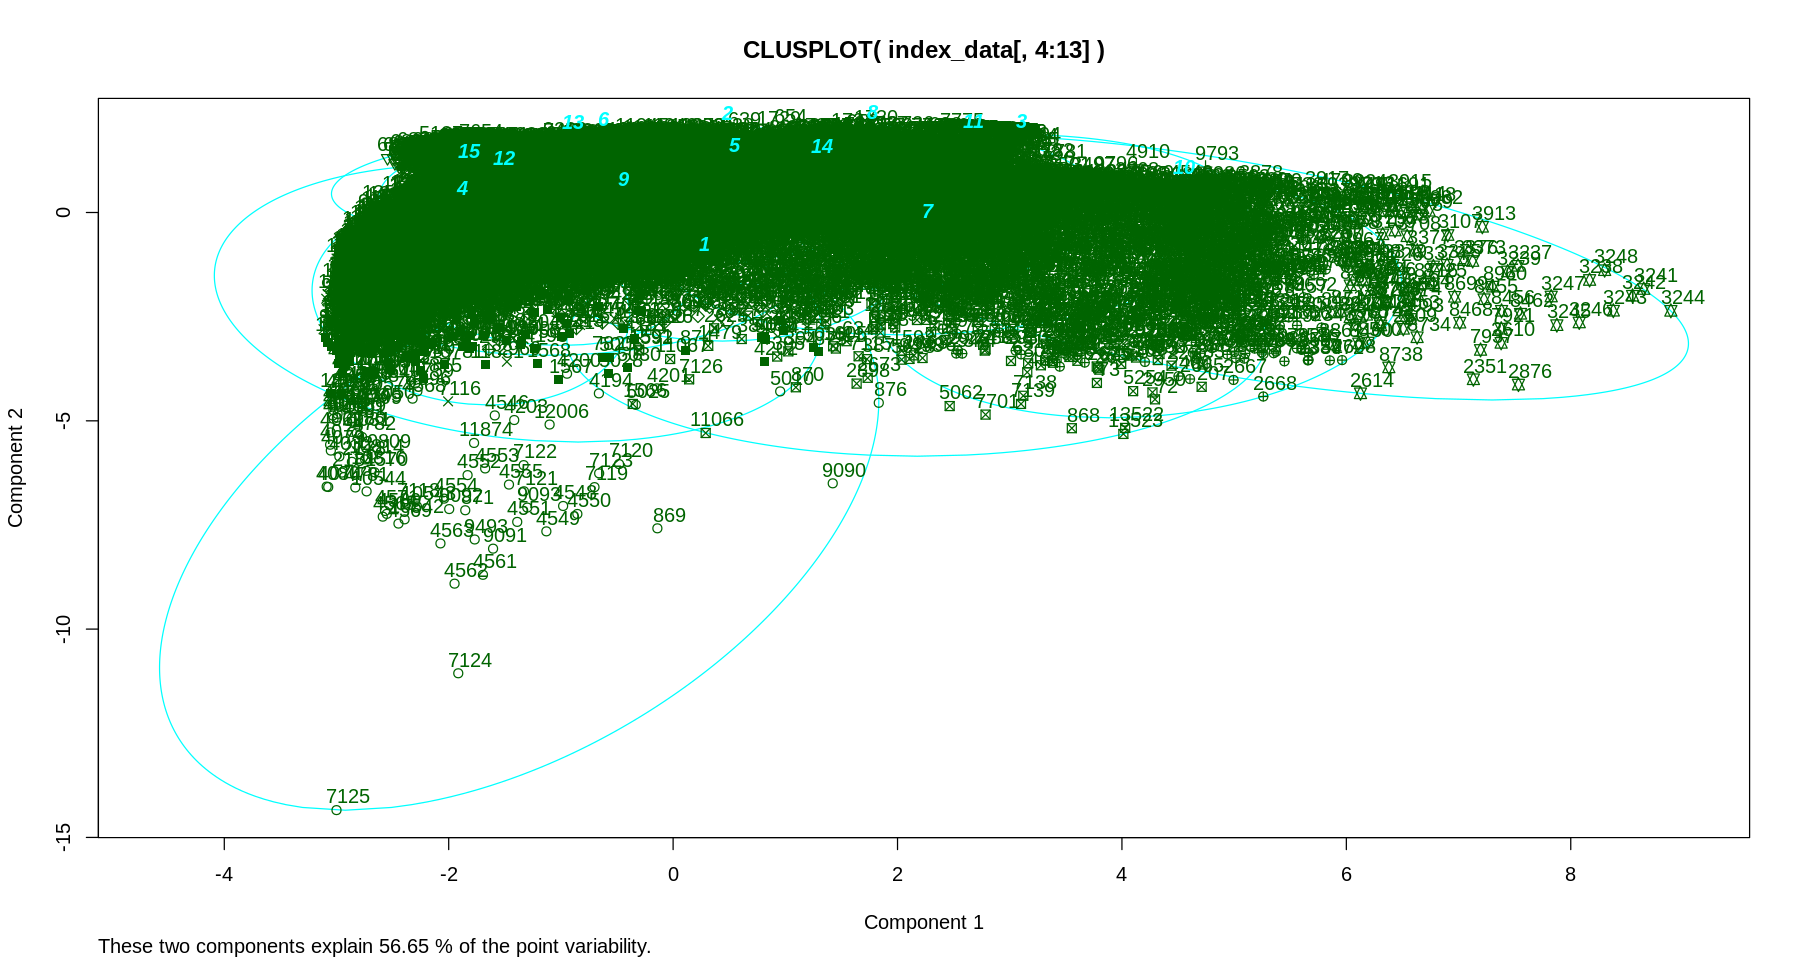

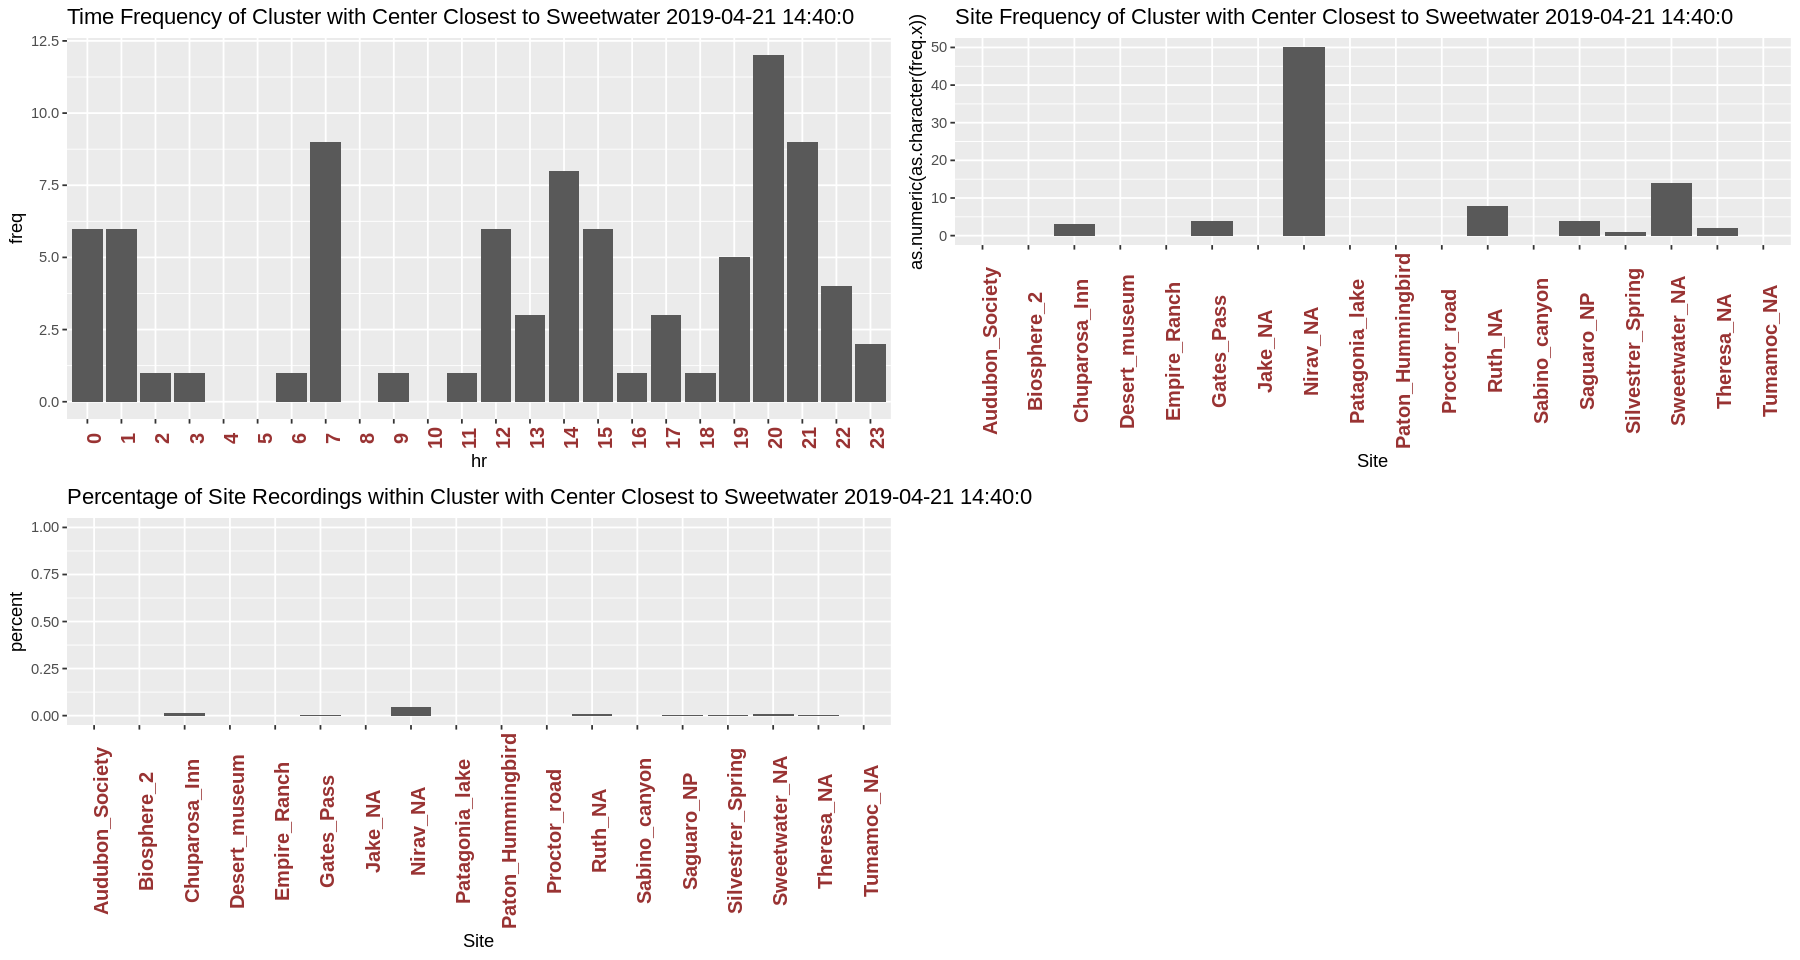

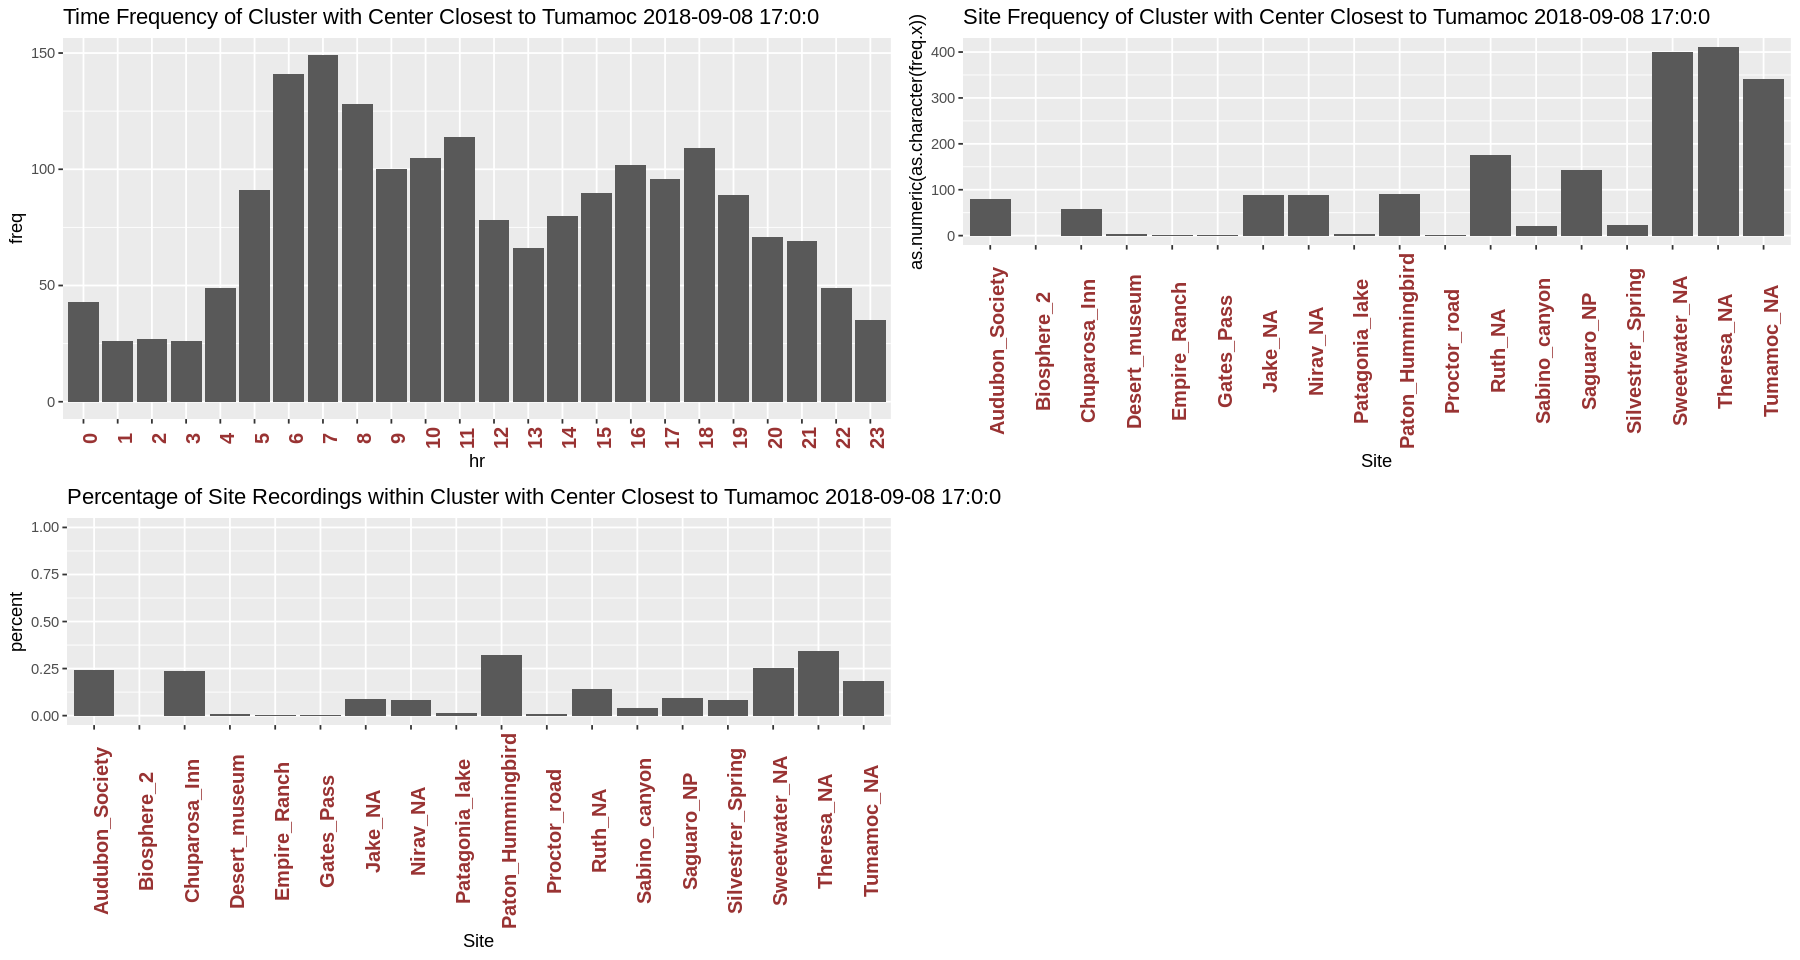

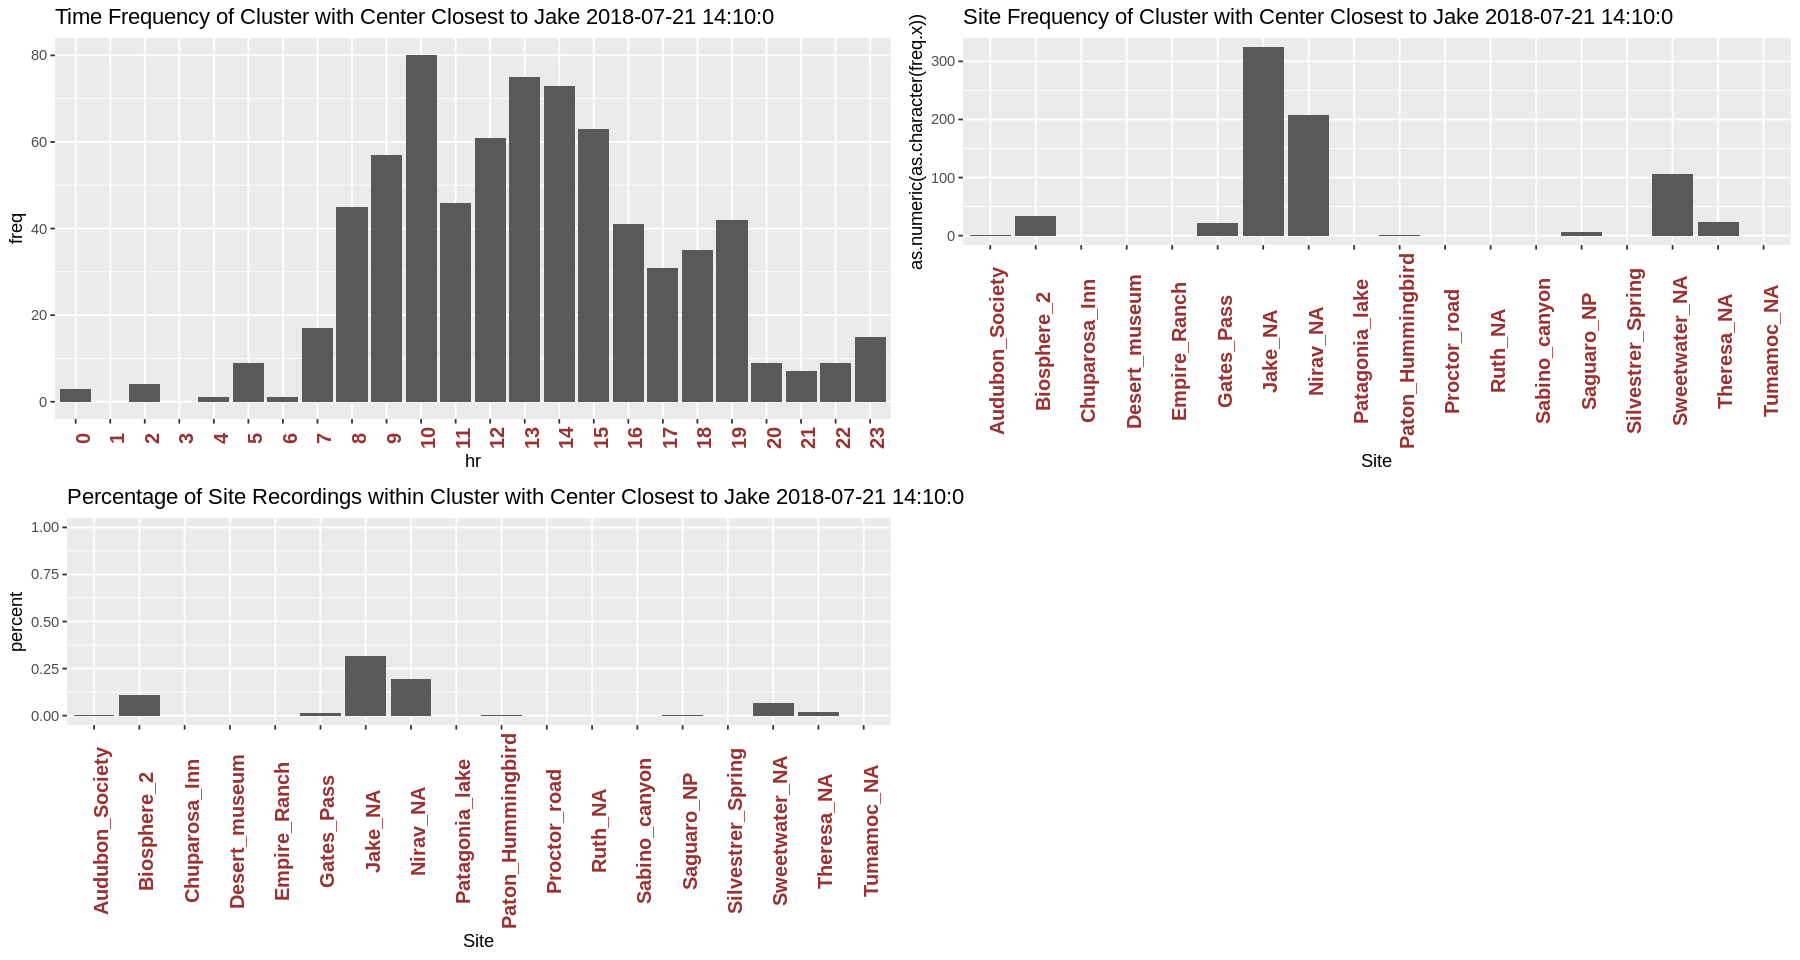

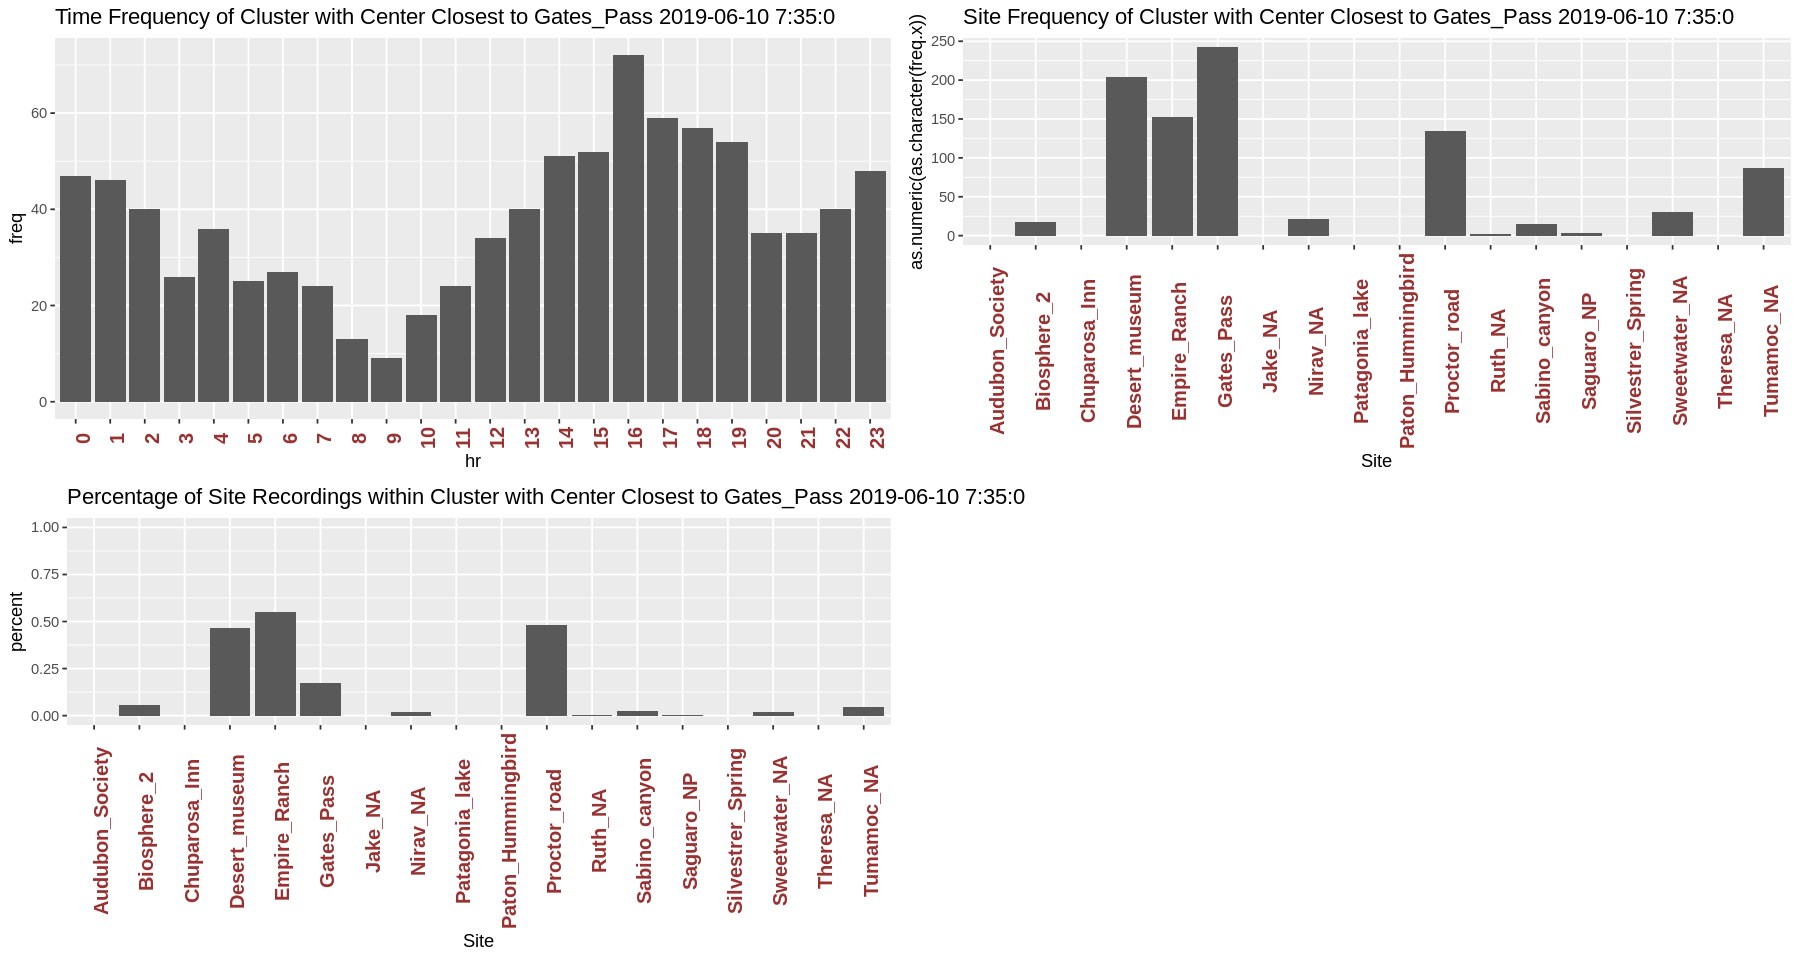

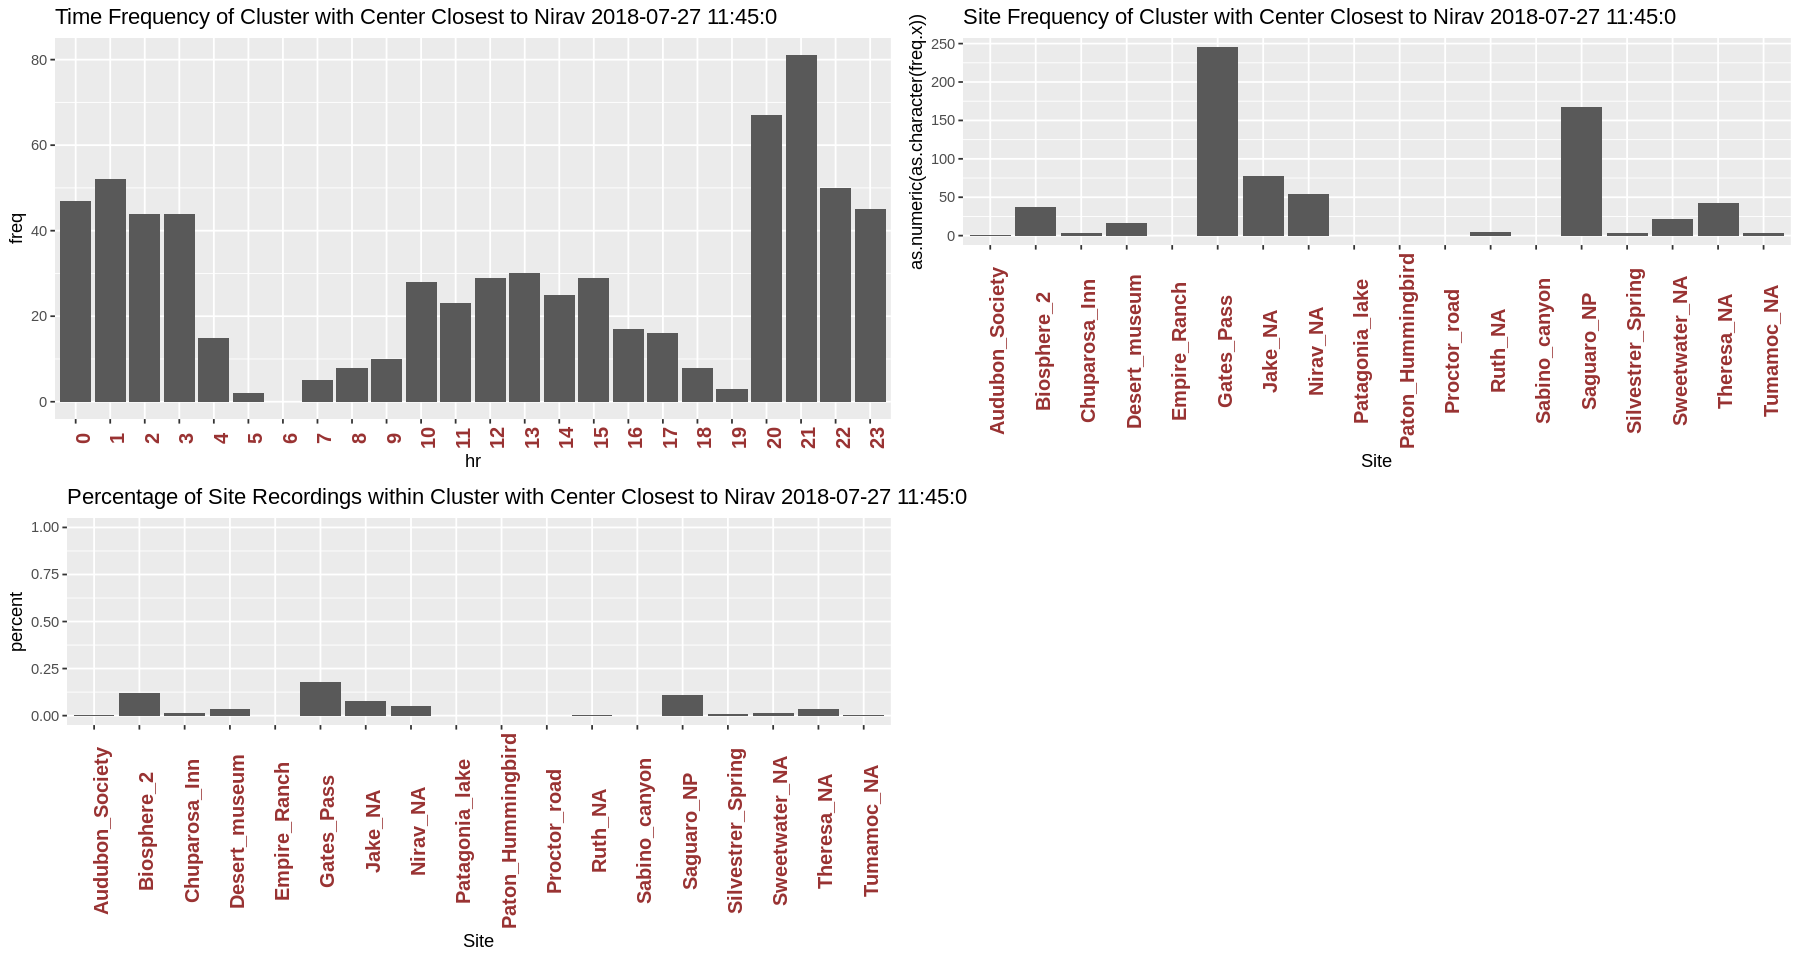

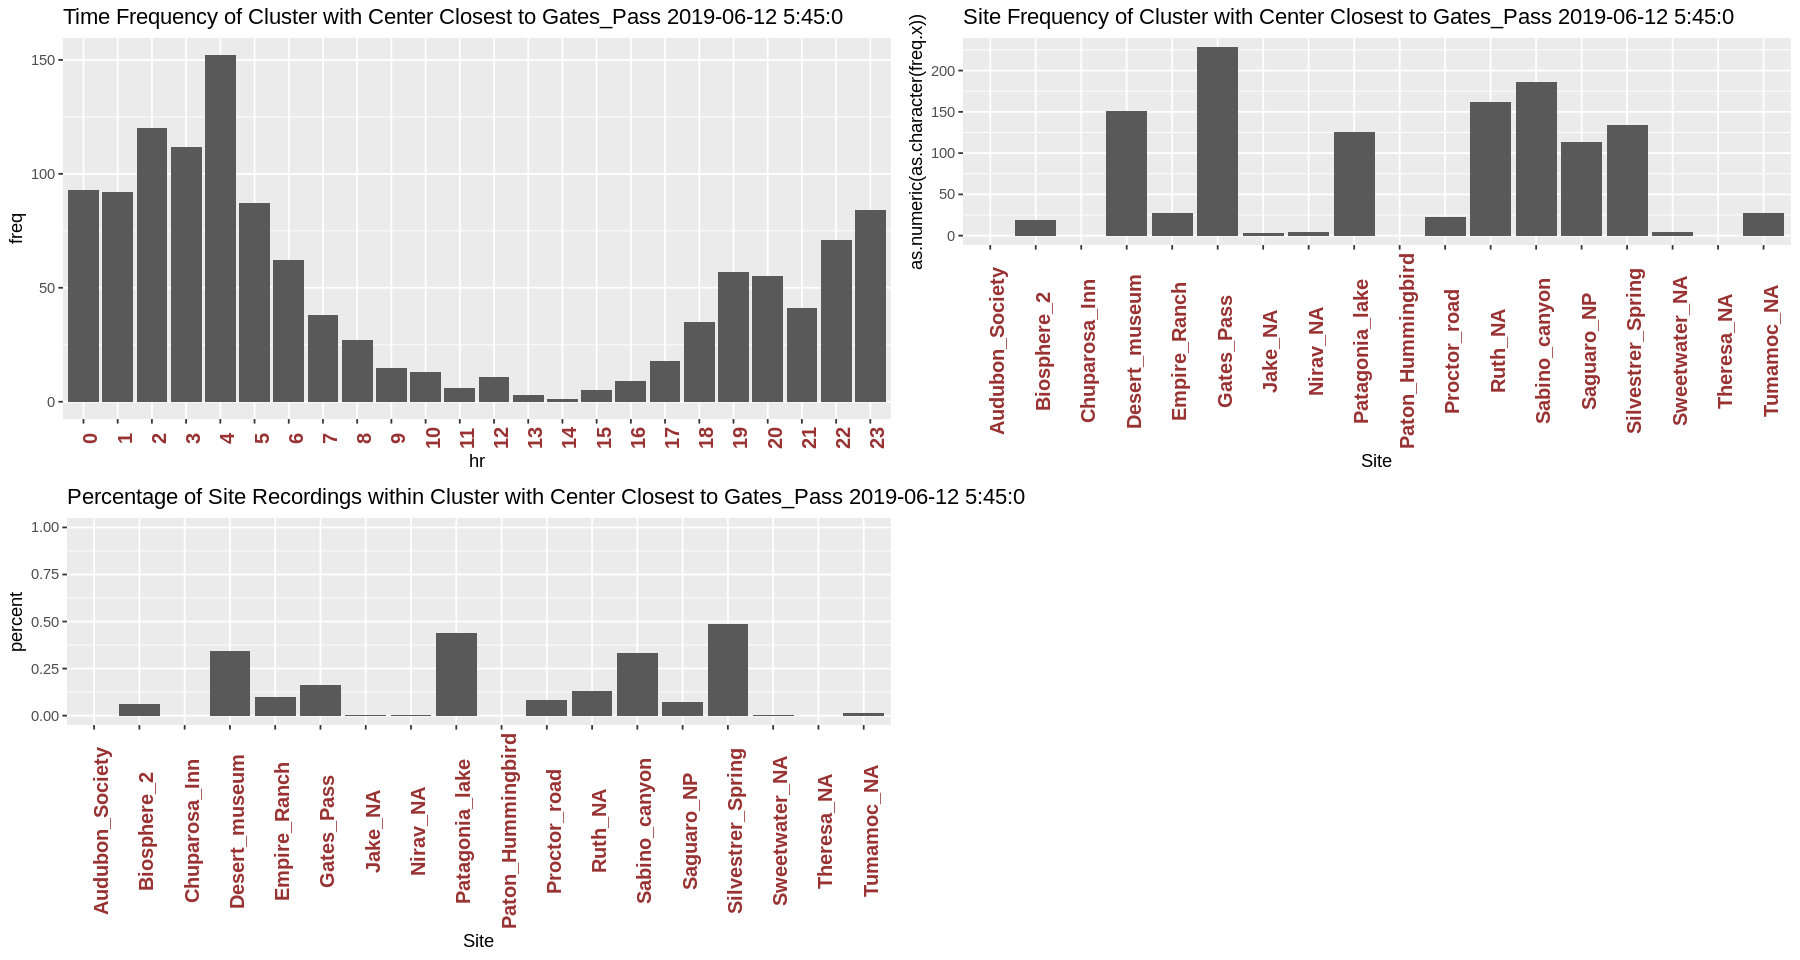

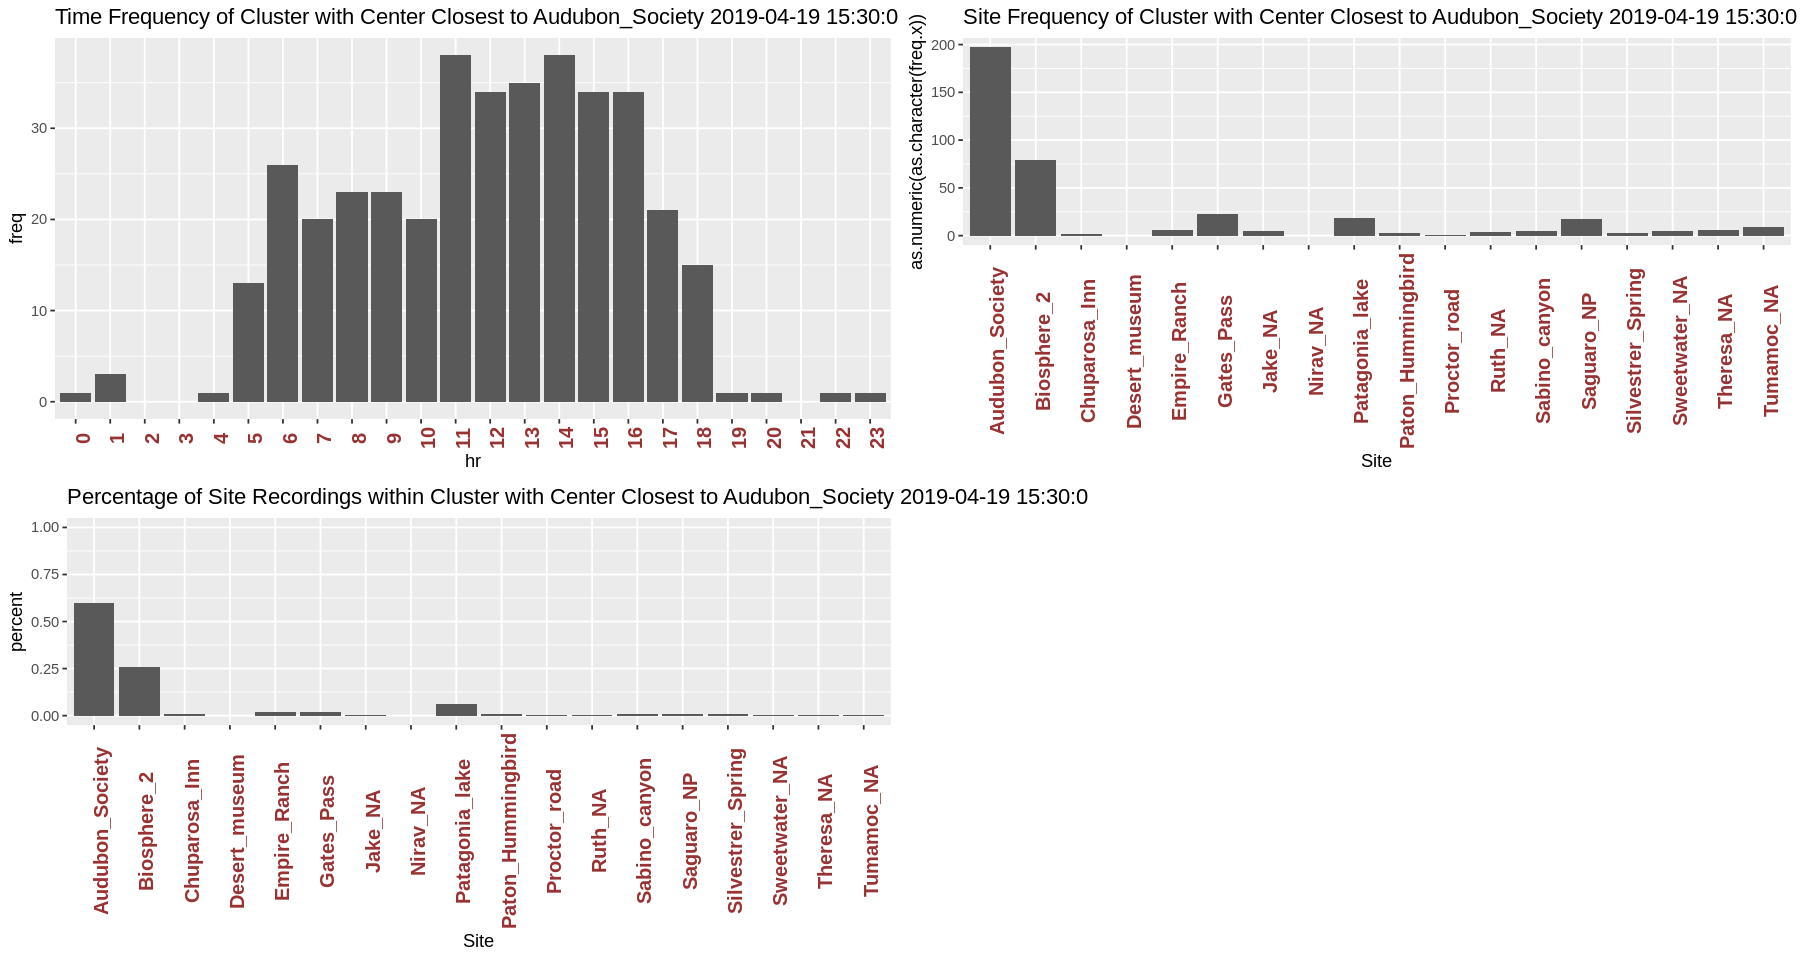

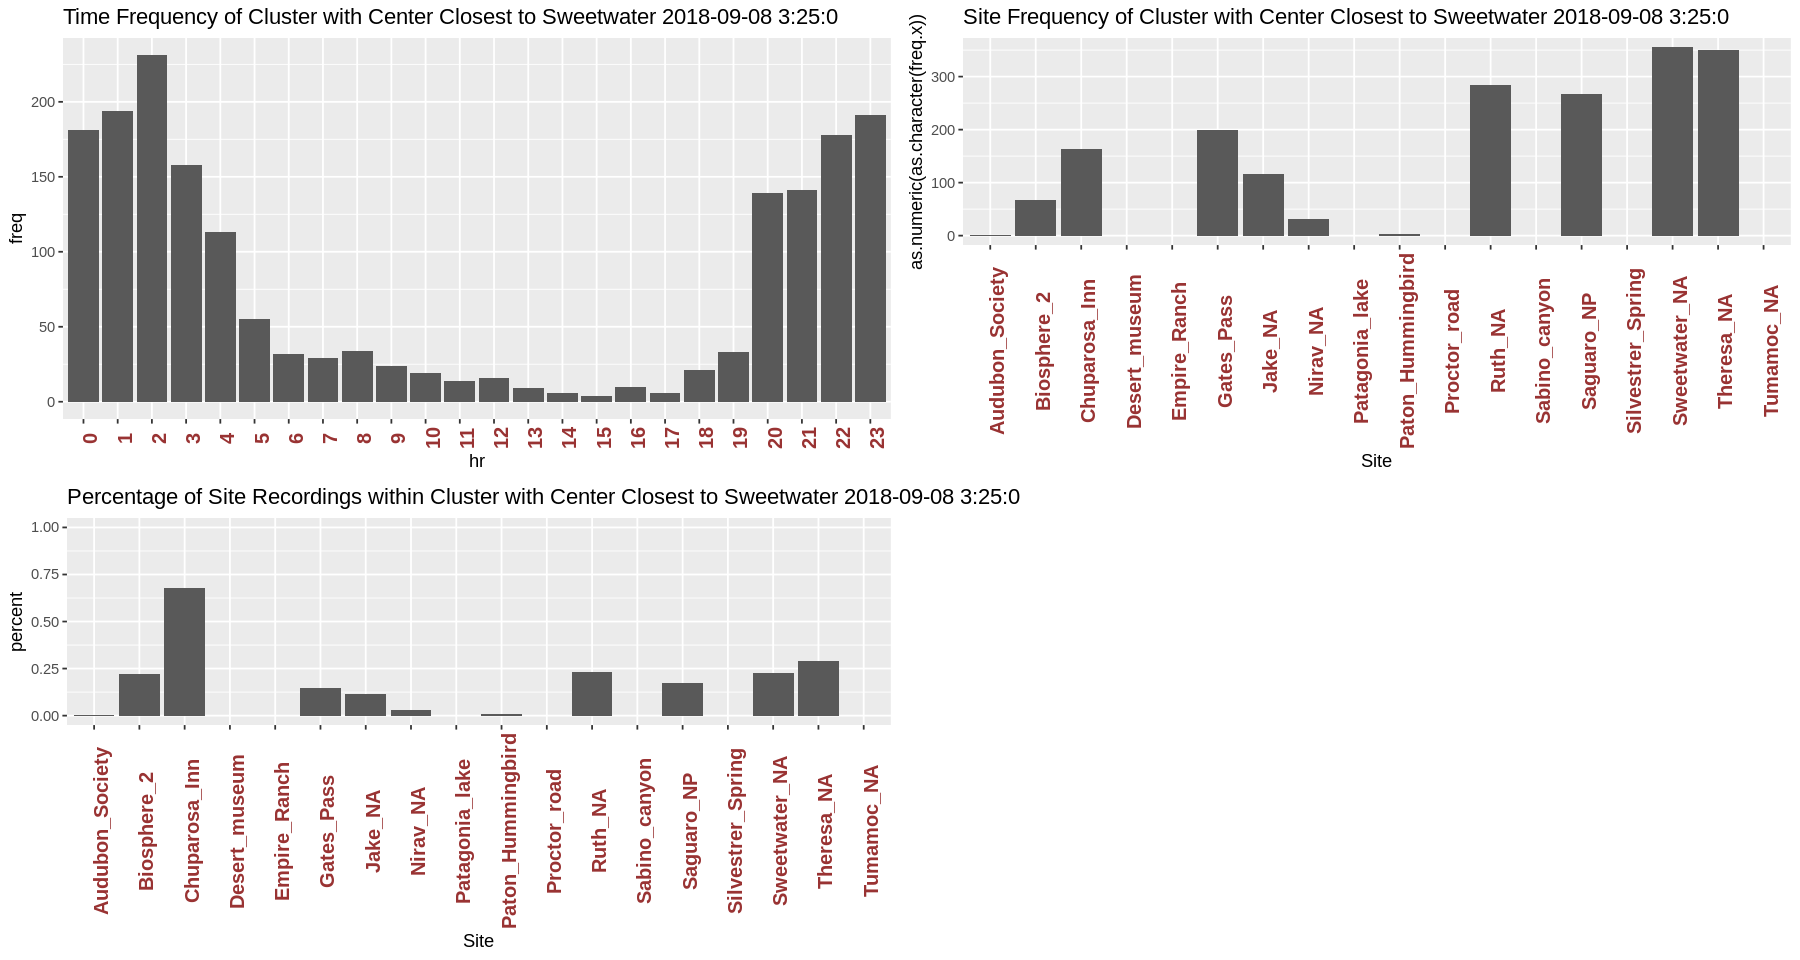

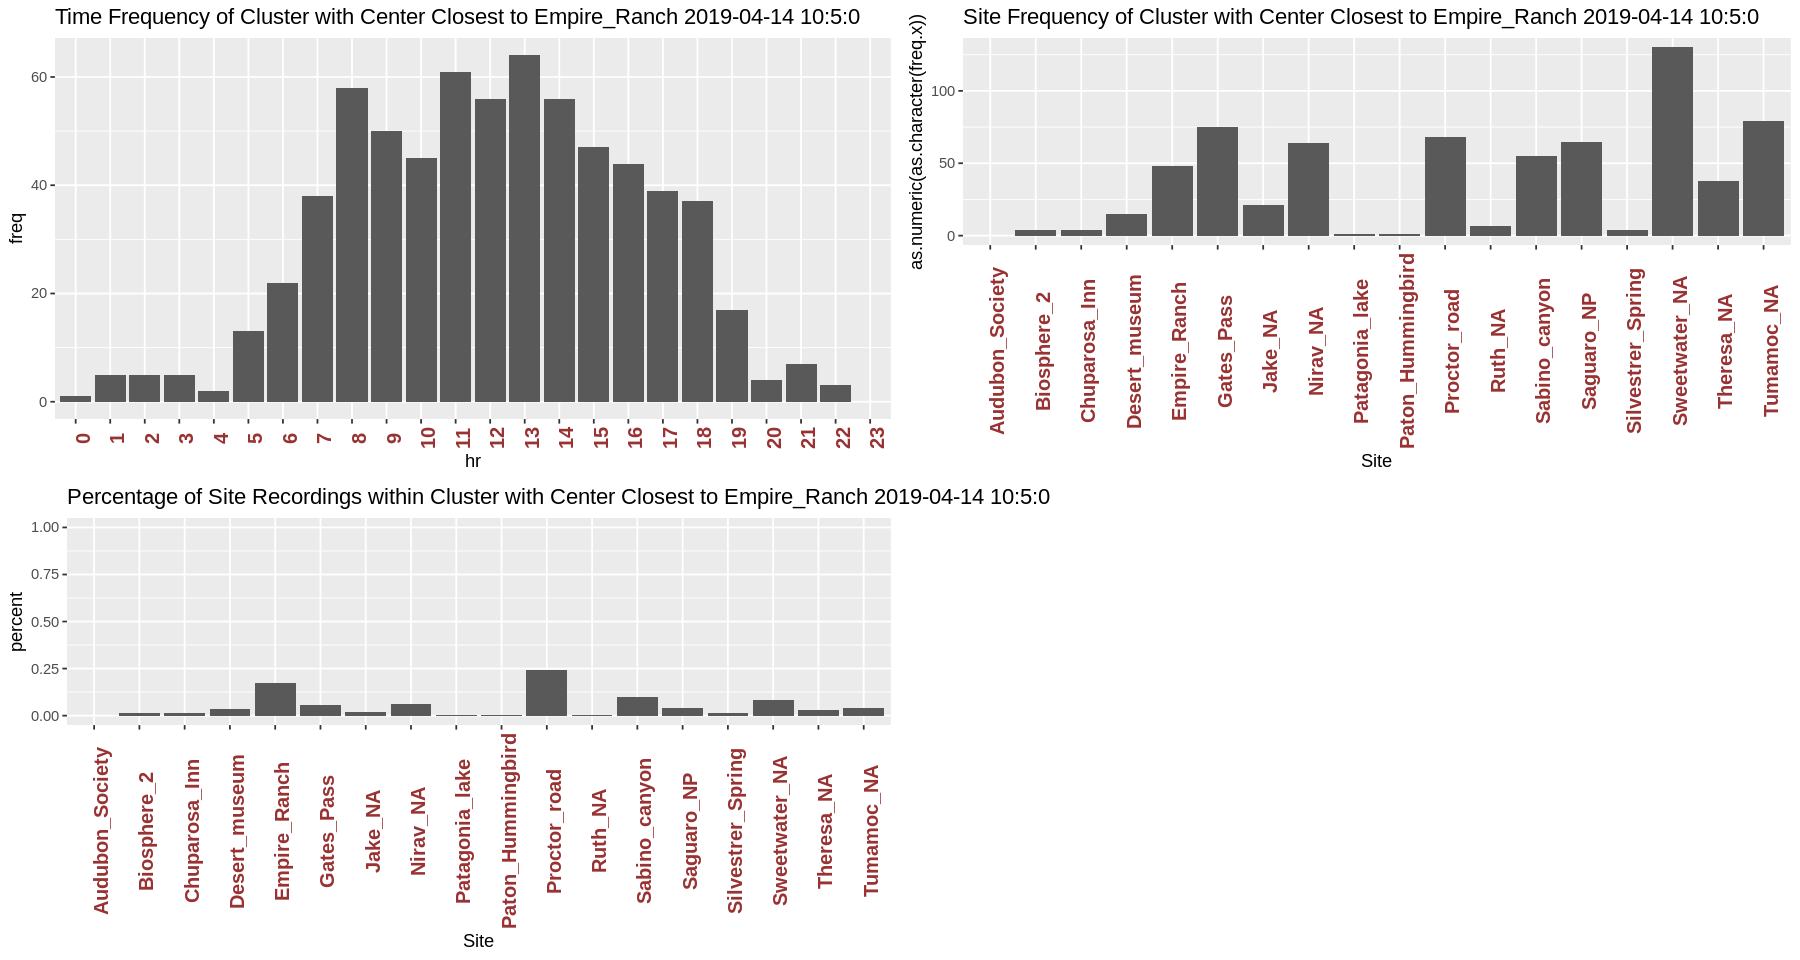

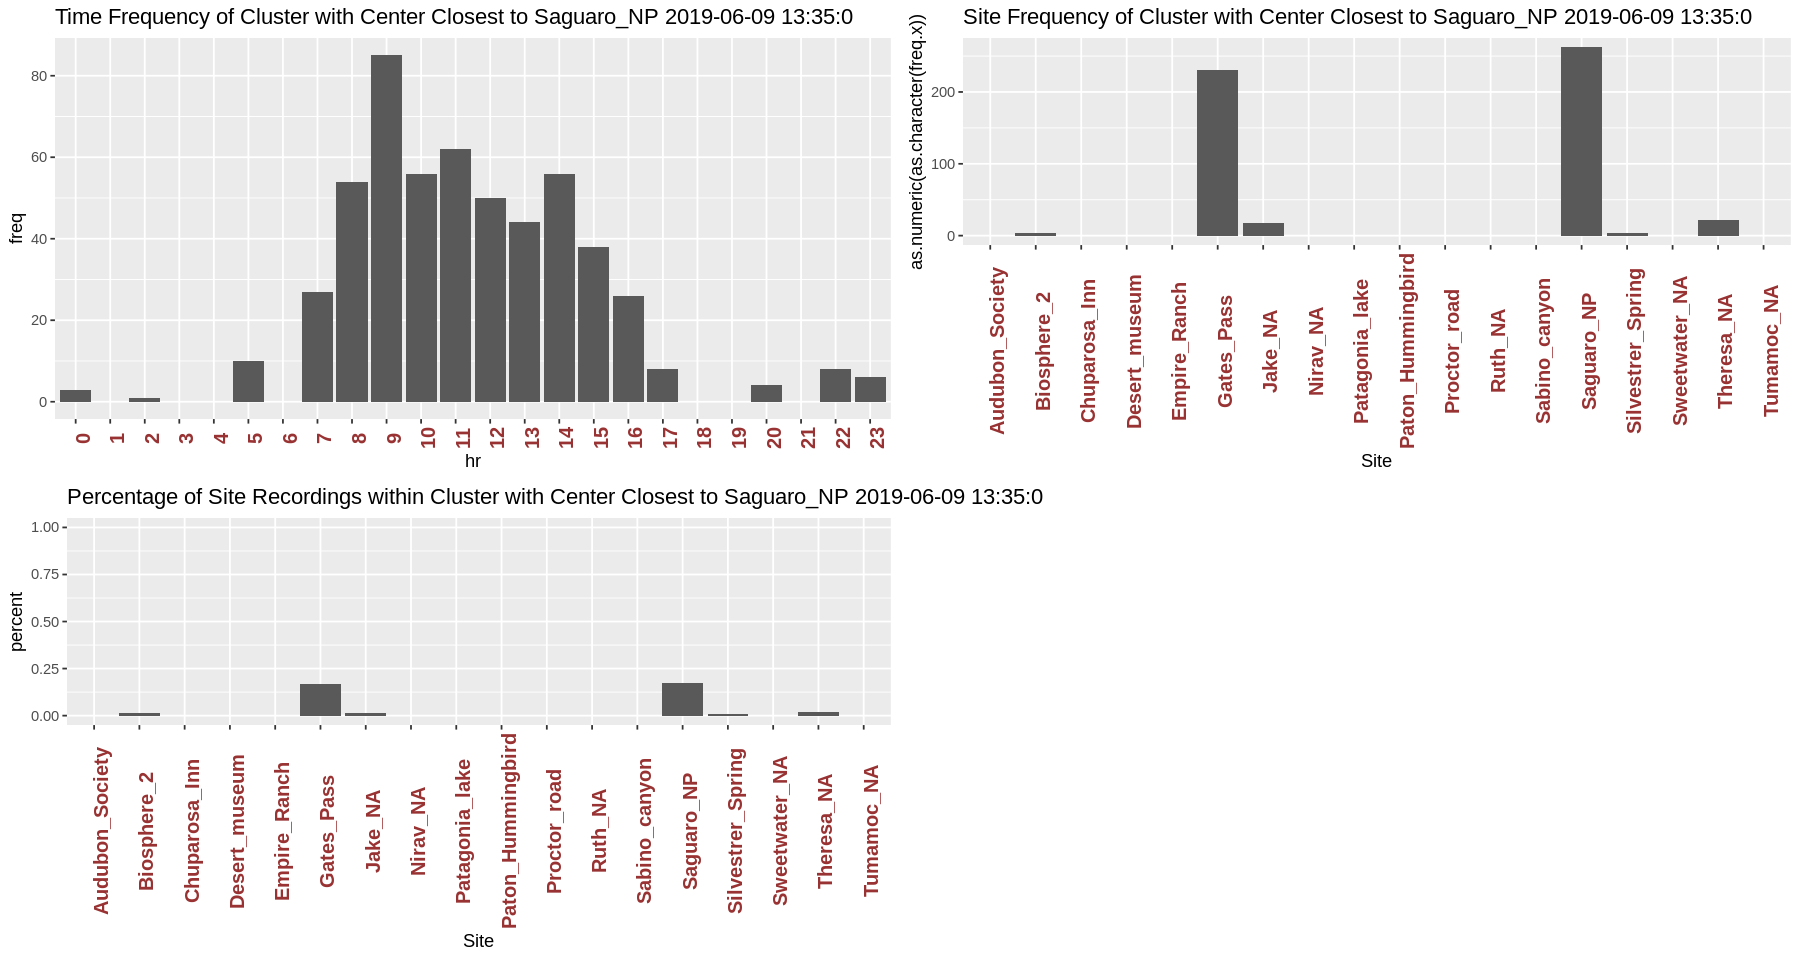

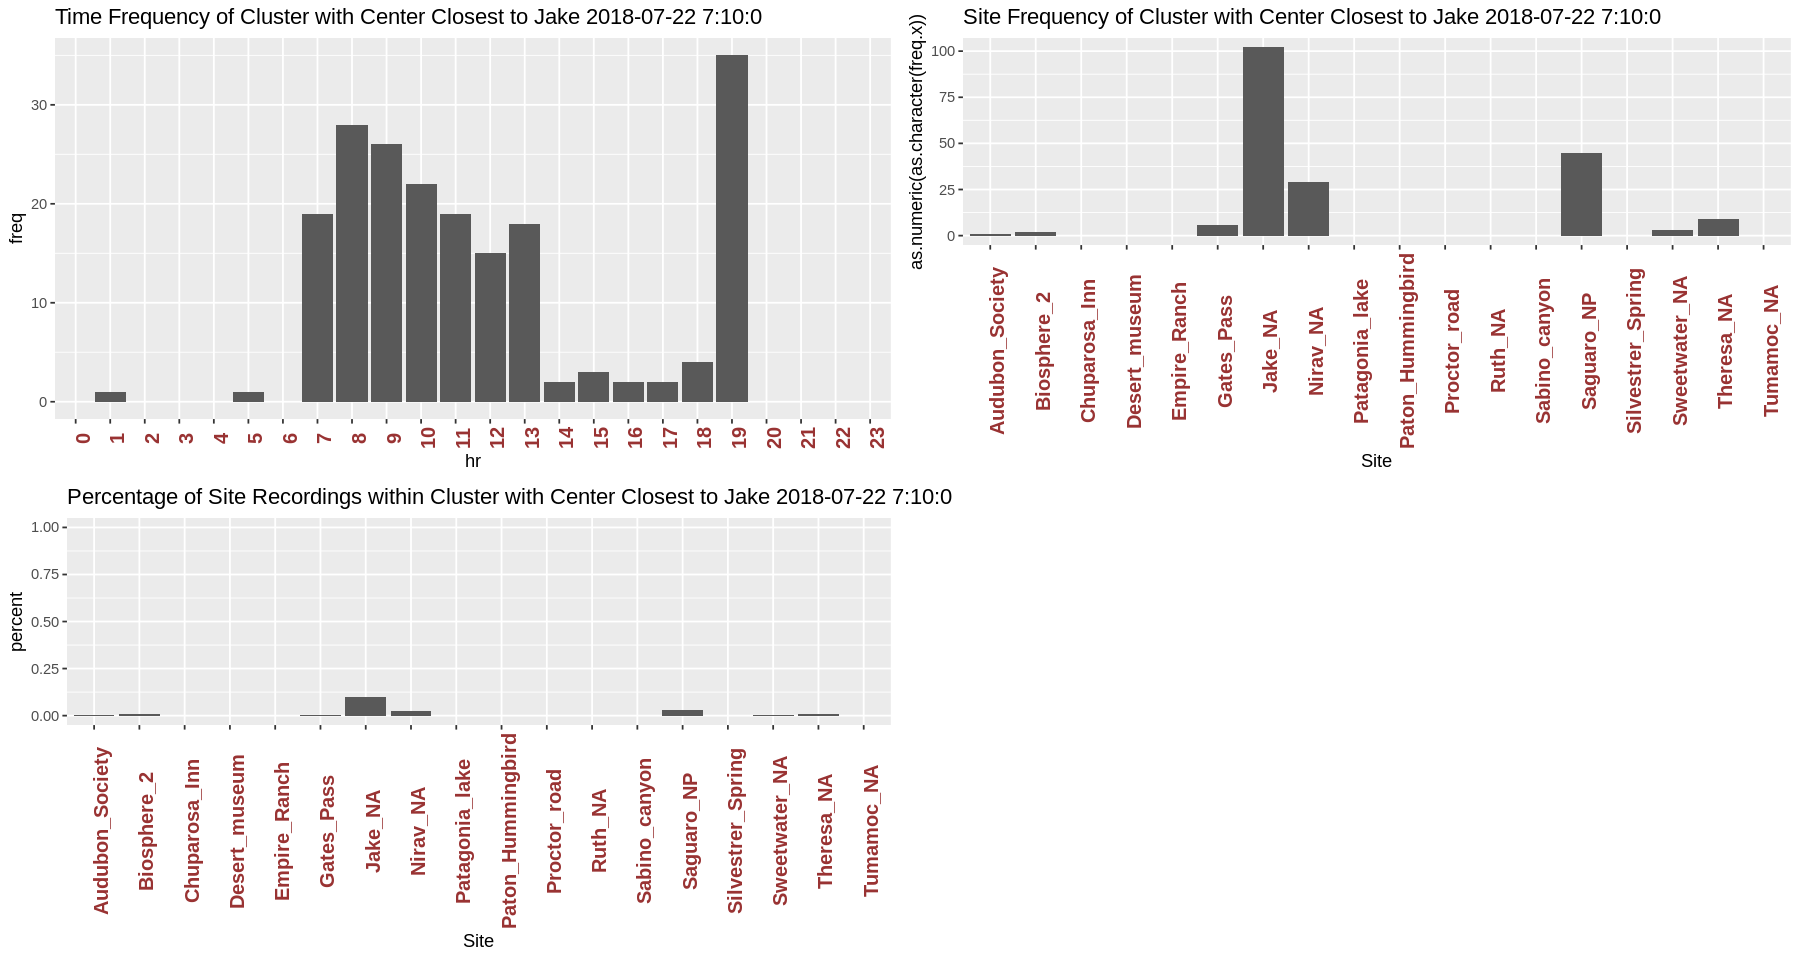

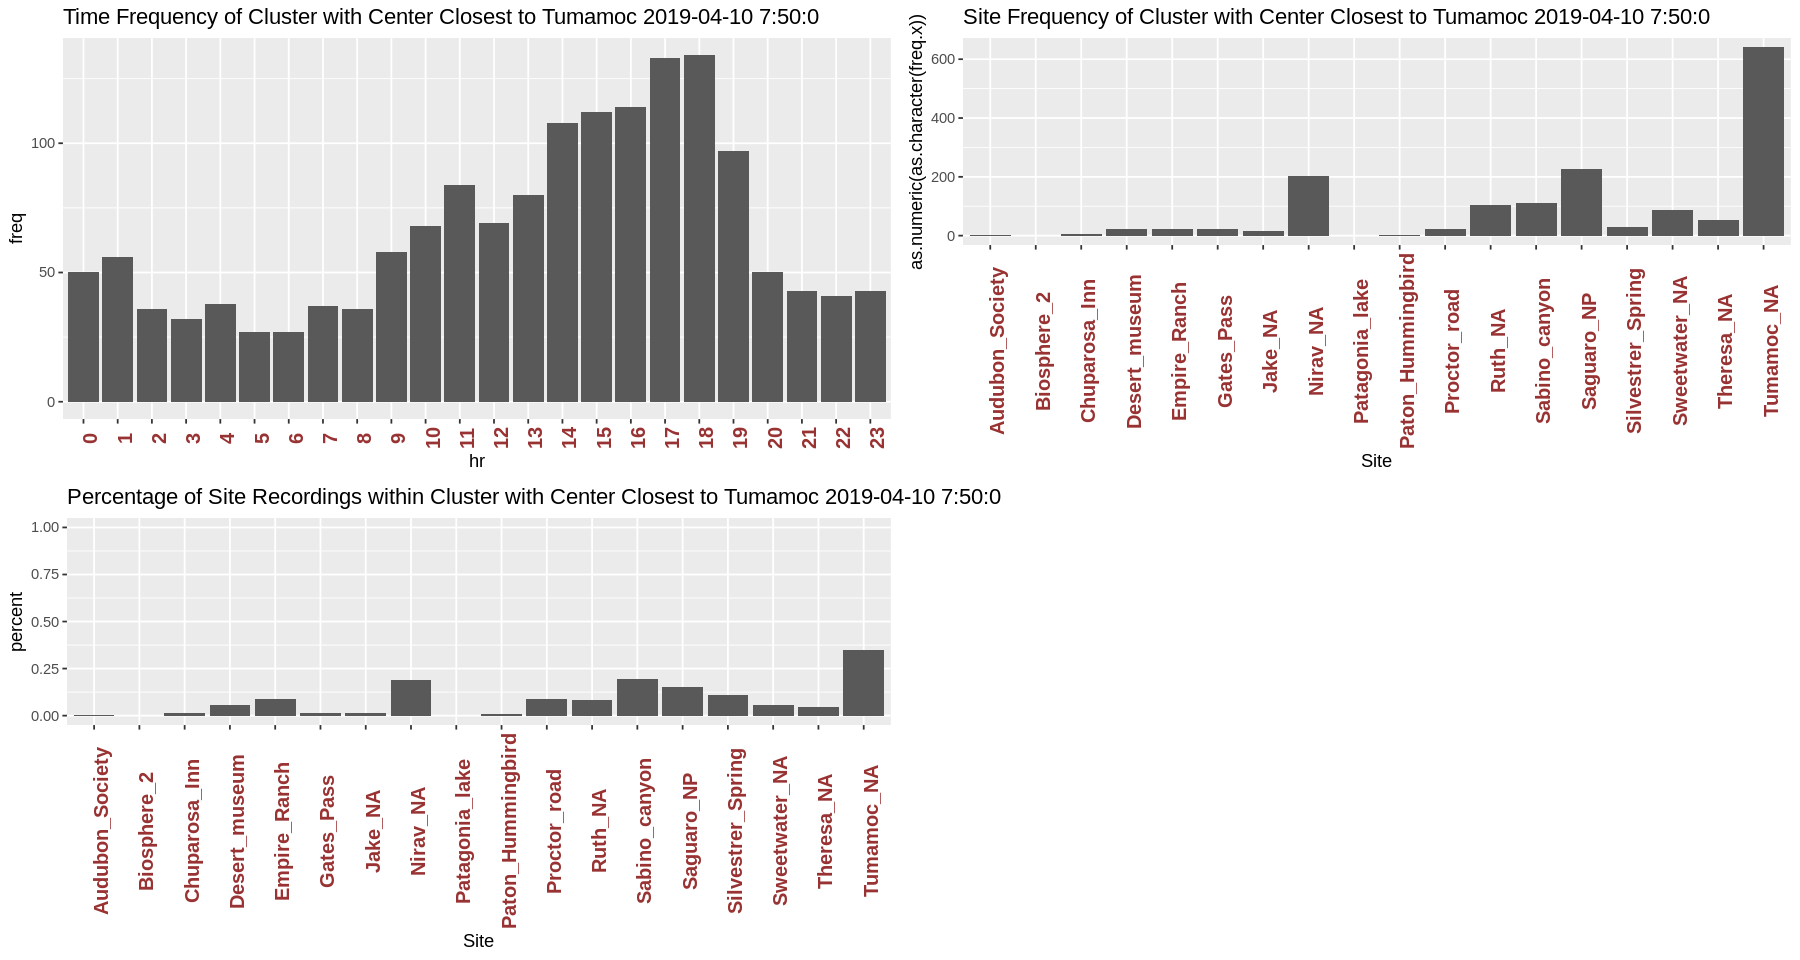

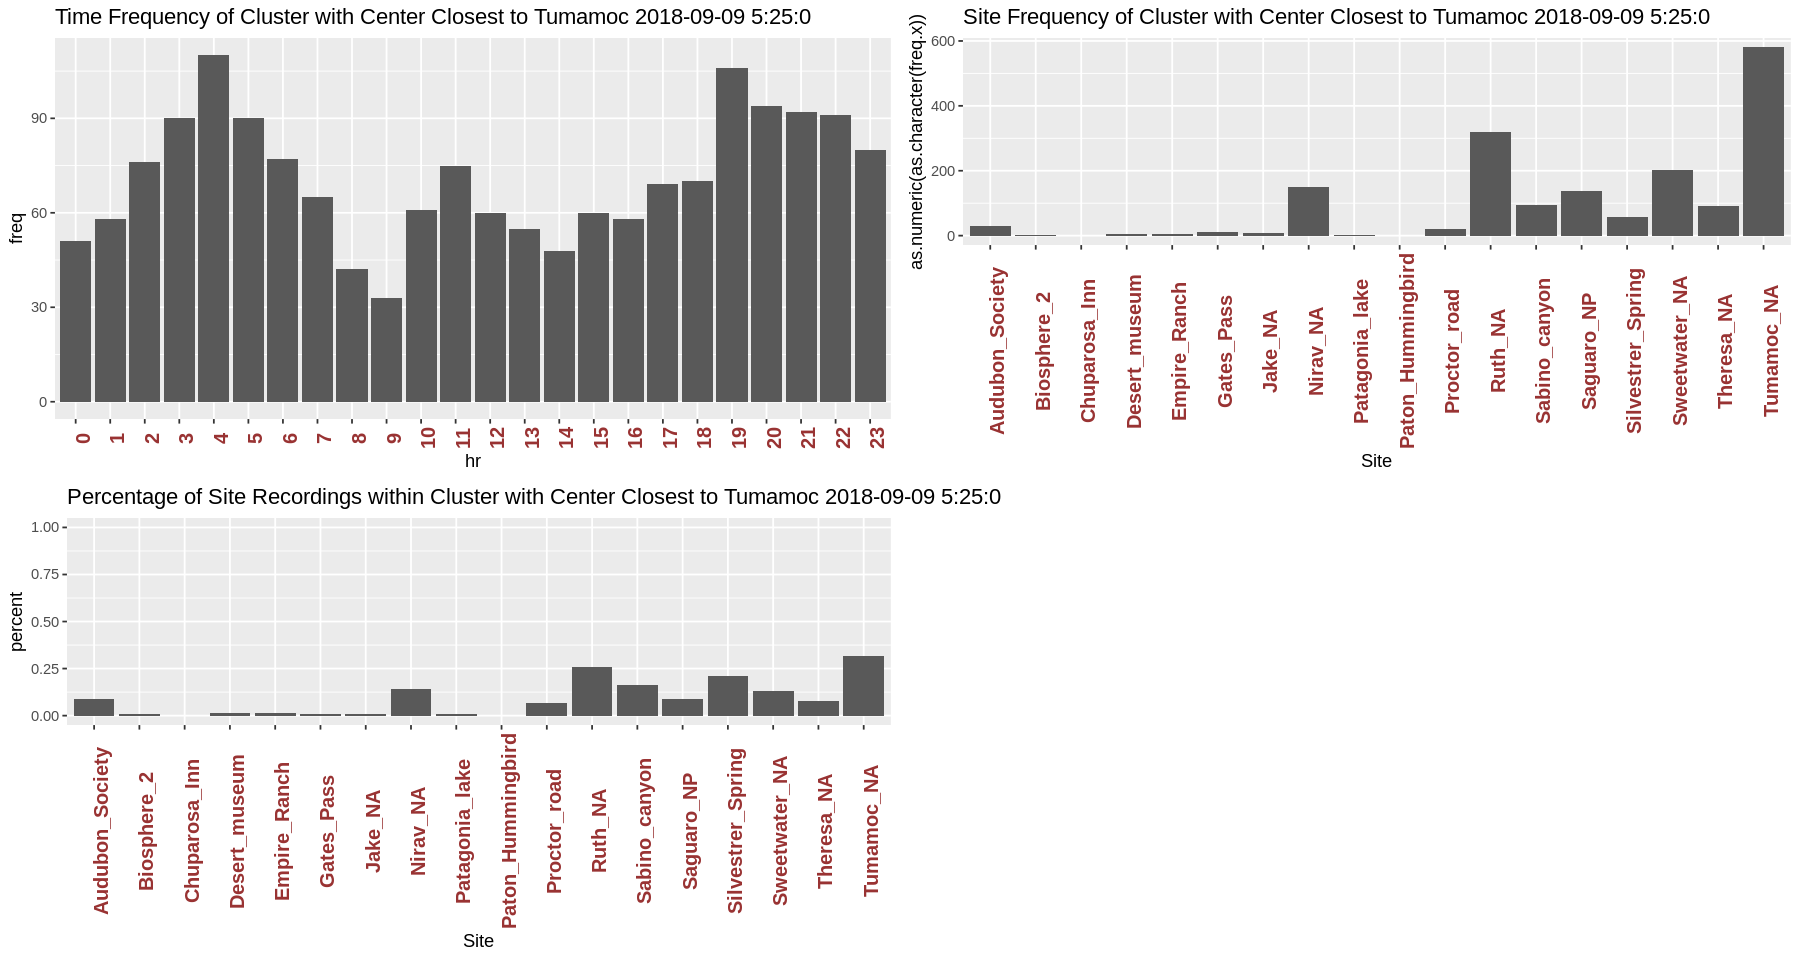

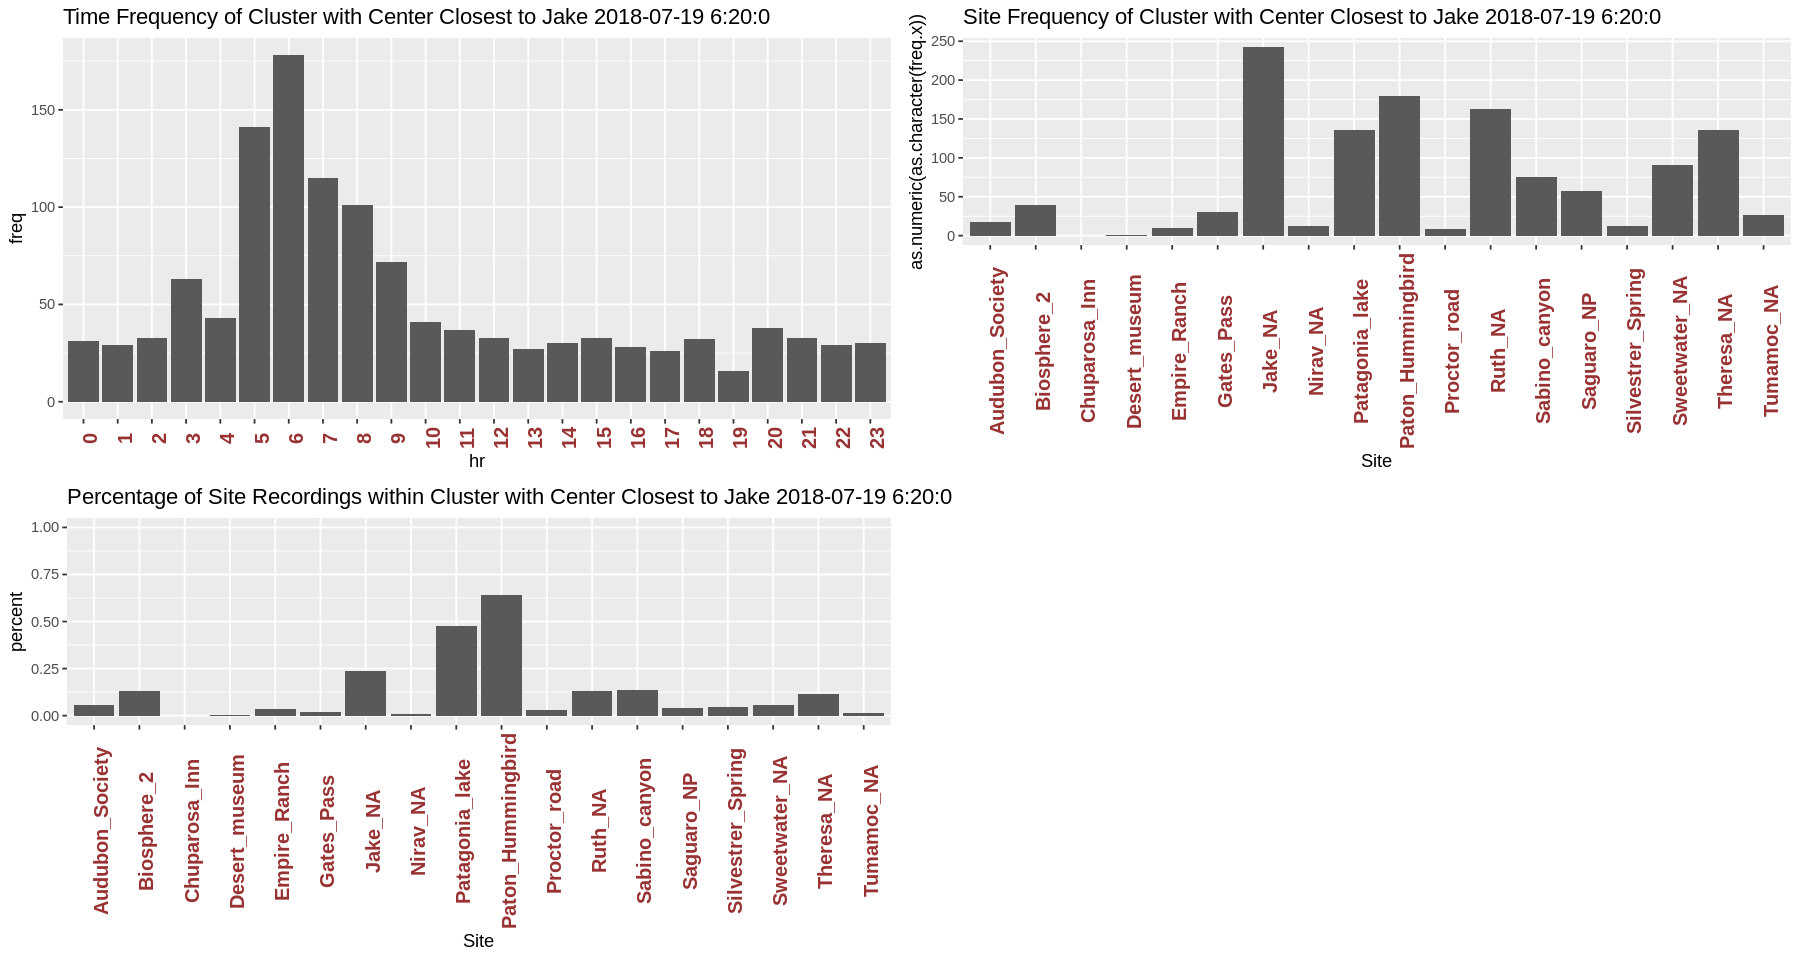

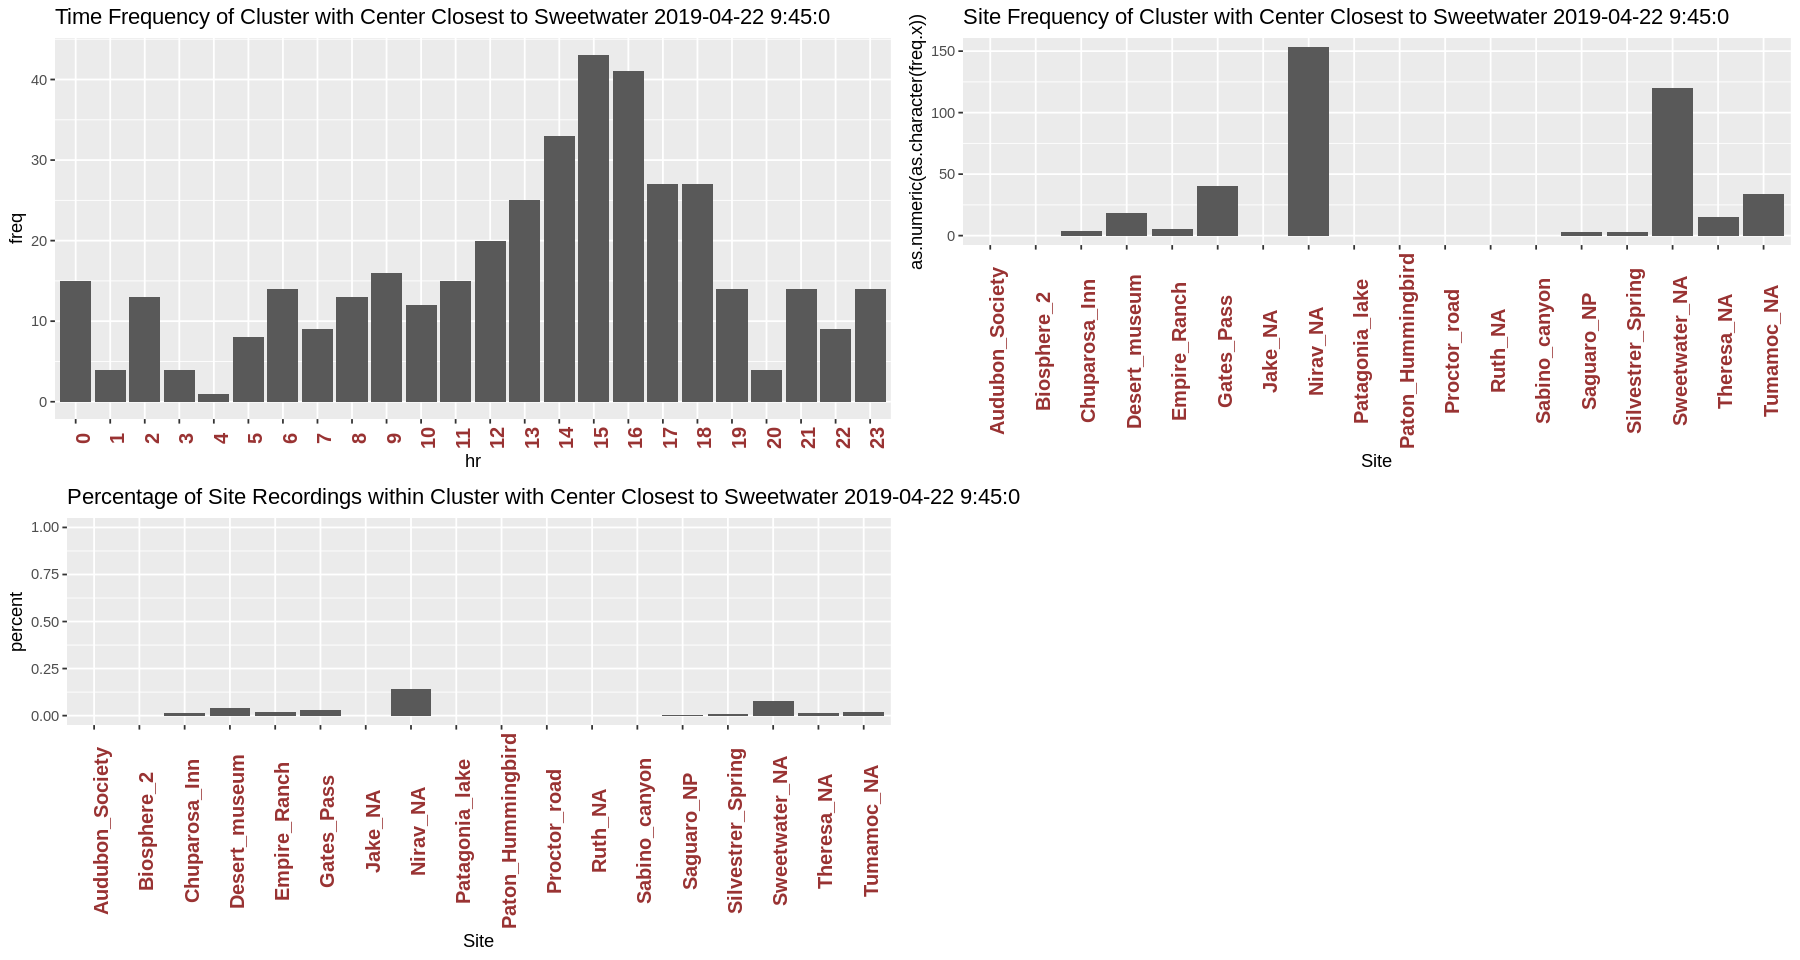

In [92]:
# K-Means Clustering with 10 clusters
fit <- kmeans(index_data[,4:13],15,iter.max=30)
fit$size
fit$centers
# Cluster Plot against 1st 2 principal components

# vary parameters for most readable graph
clusplot(index_data[,4:13], fit$cluster, color=FALSE, shade=FALSE,
   labels=2, lines=0)

histogram_plotter(fit,data.frame(index_data, fit$cluster) )

[1] 5184 8909

bioacoustic....double.. amplitude....double.. temporal_entropy....double..
1  0.13450935             -0.13179818            0.2840741                  
2 -0.07826877              0.07669118           -0.1652980                  
  spectral_entropy....double.. acoustic_entropy....double..
1  0.9647433                    0.9710435                  
2 -0.5613682                   -0.5650342                  
  acoustic_diversity....double.. acoustic_evenness....double..
1  1.115197                      -1.0074952                   
2 -0.648915                       0.5862448                   
  acoustic_complexity....double.. nrows....double.. ndsi....double..
1  0.14680657                      0.3736605         0.8392957      
2 -0.08542432                     -0.2174268        -0.4883723

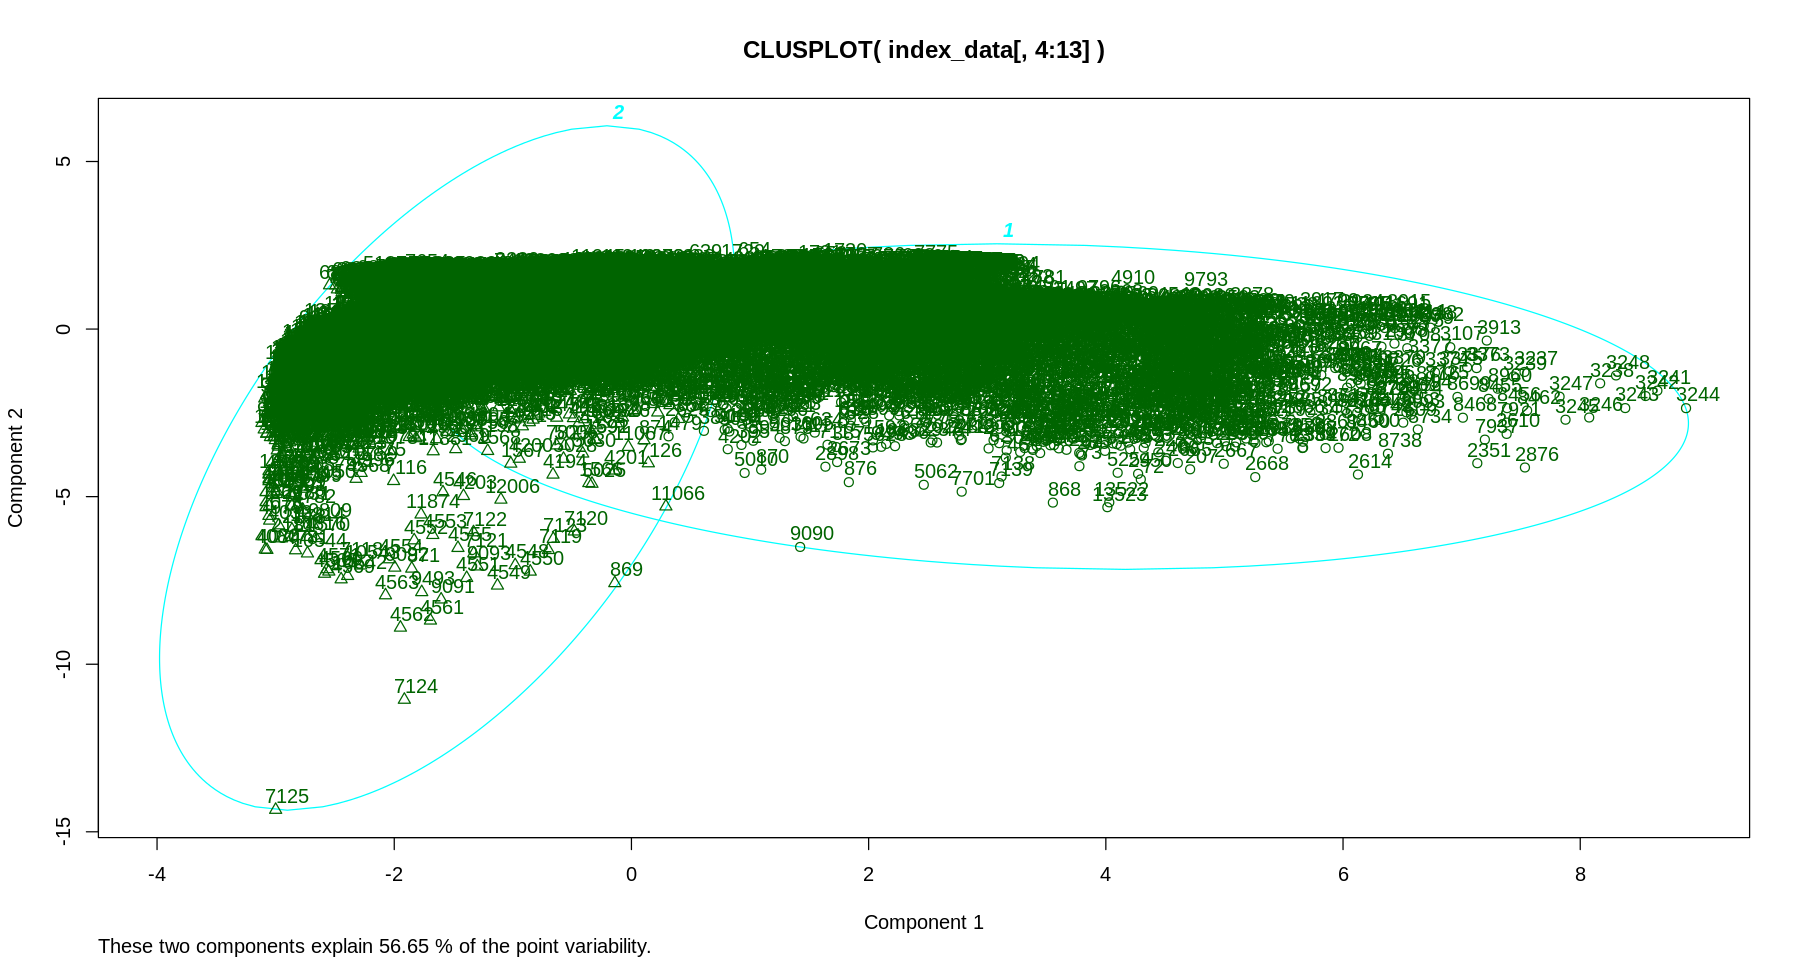

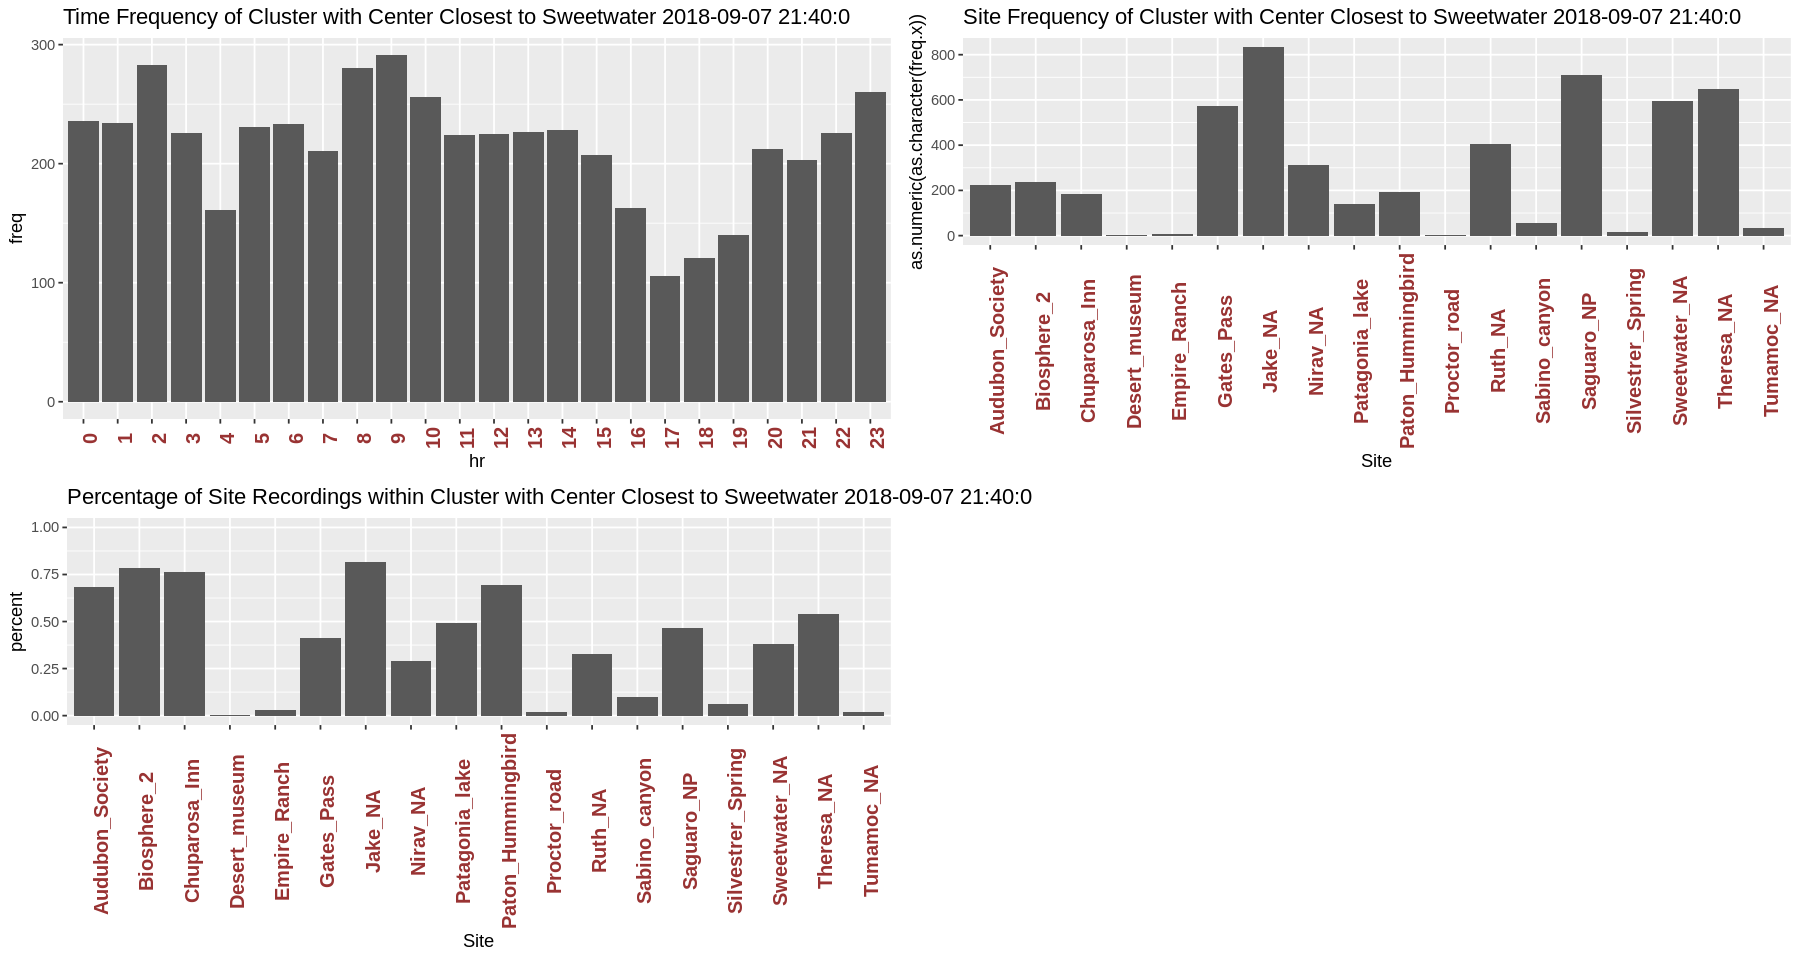

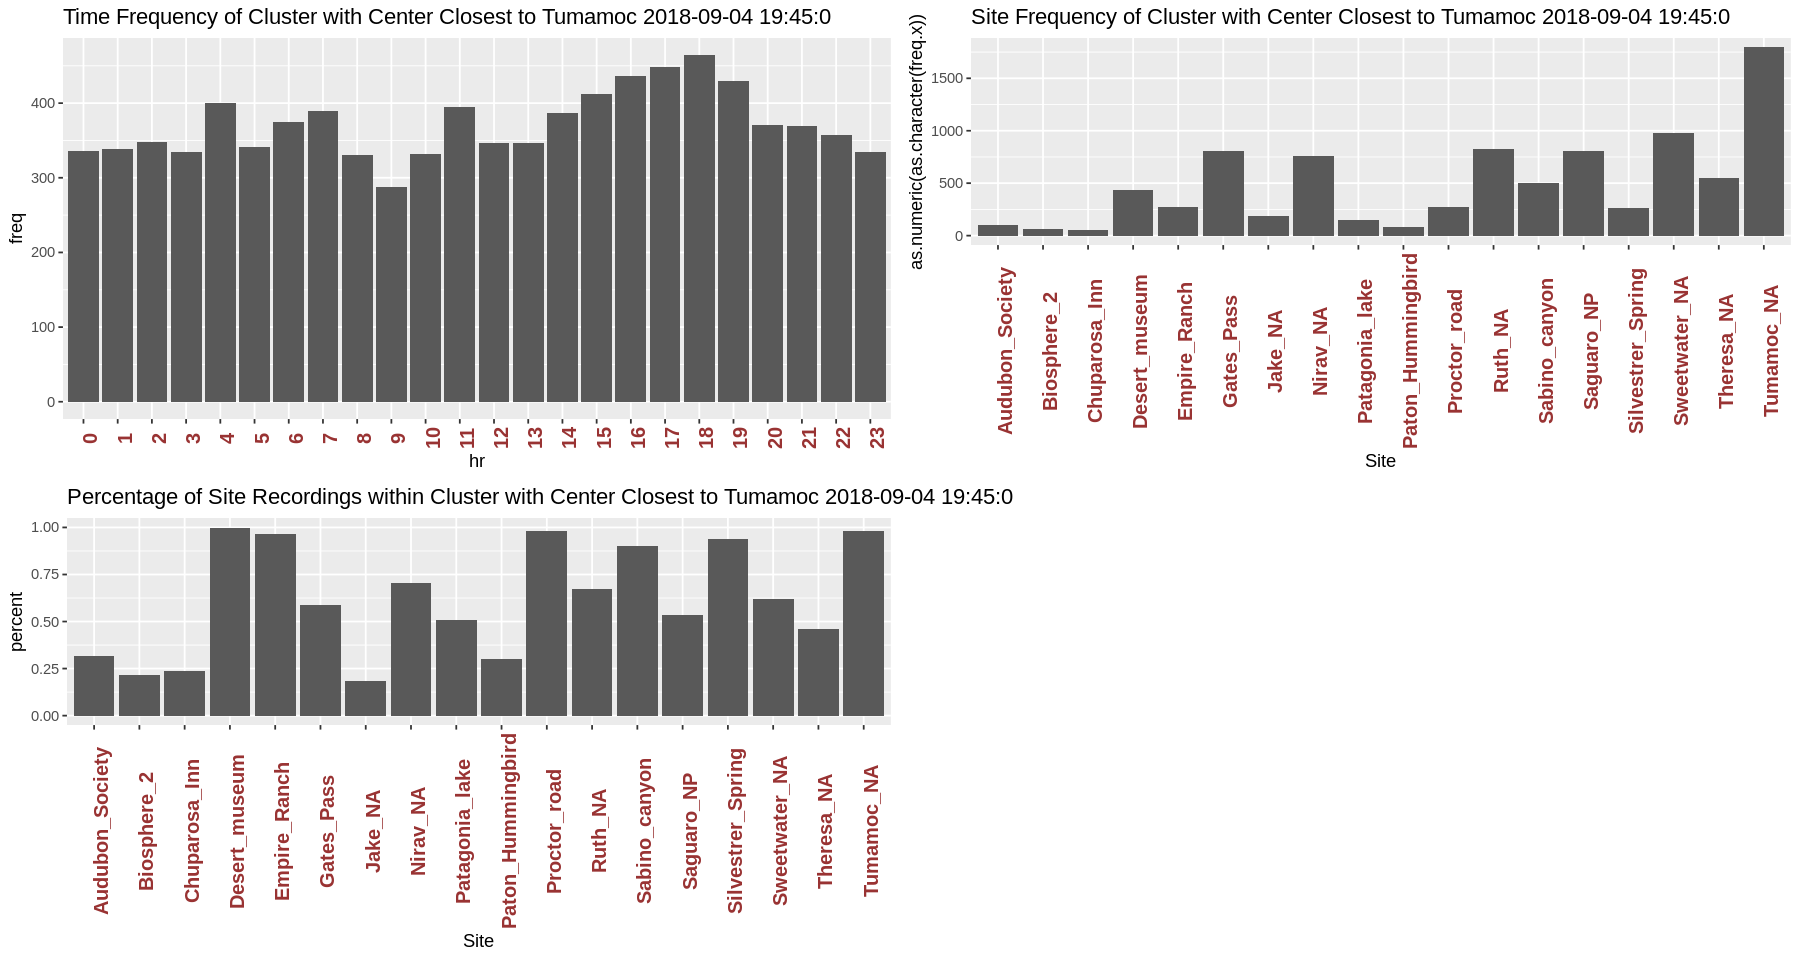

In [94]:
# K-Means Clustering with 2 clusters
fit <- kmeans(index_data[,4:13],2,iter.max=30)
fit$size
fit$centers
# Cluster Plot against 1st 2 principal components

# vary parameters for most readable graph
clusplot(index_data[,4:13], fit$cluster, color=FALSE, shade=FALSE,
   labels=2, lines=0)

histogram_plotter(fit,data.frame(index_data, fit$cluster) )

[1] 1802 4905 7386

bioacoustic....double.. amplitude....double.. temporal_entropy....double..
1 -0.9909528               0.2246096            -0.4047266                  
2  0.7106972              -0.2944755             0.5802864                  
3 -0.2302021               0.1407603            -0.2866217                  
  spectral_entropy....double.. acoustic_entropy....double..
1  1.7280051                    1.6997734                  
2  0.4290574                    0.4503509                  
3 -0.7065248                   -0.7137778                  
  acoustic_diversity....double.. acoustic_evenness....double..
1  1.6296049                     -1.9011578                   
2  0.5632321                     -0.2759244                   
3 -0.7716222                      0.6470750                   
  acoustic_complexity....double.. nrows....double.. ndsi....double..
1  0.52624458                      0.86348614        1.0877189      
2 -0.10090771                      0.04129505        0.4438259      
3 -0.06137834                     -0.23809291       -0.5601185

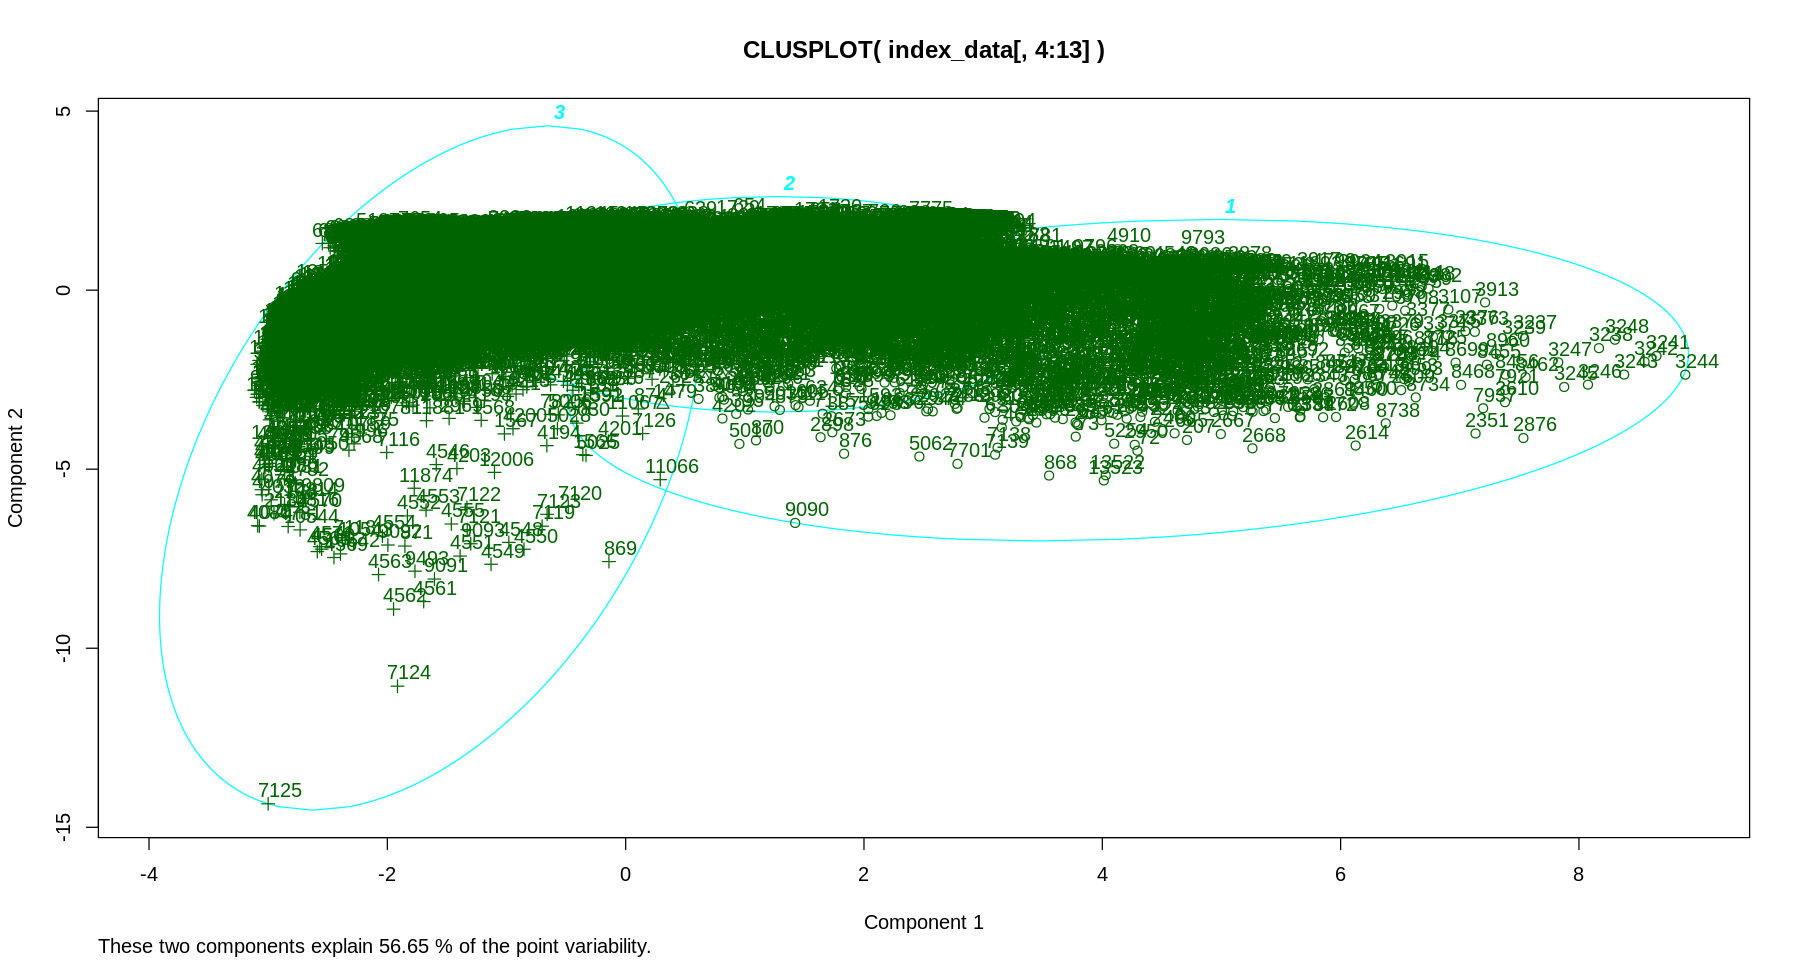

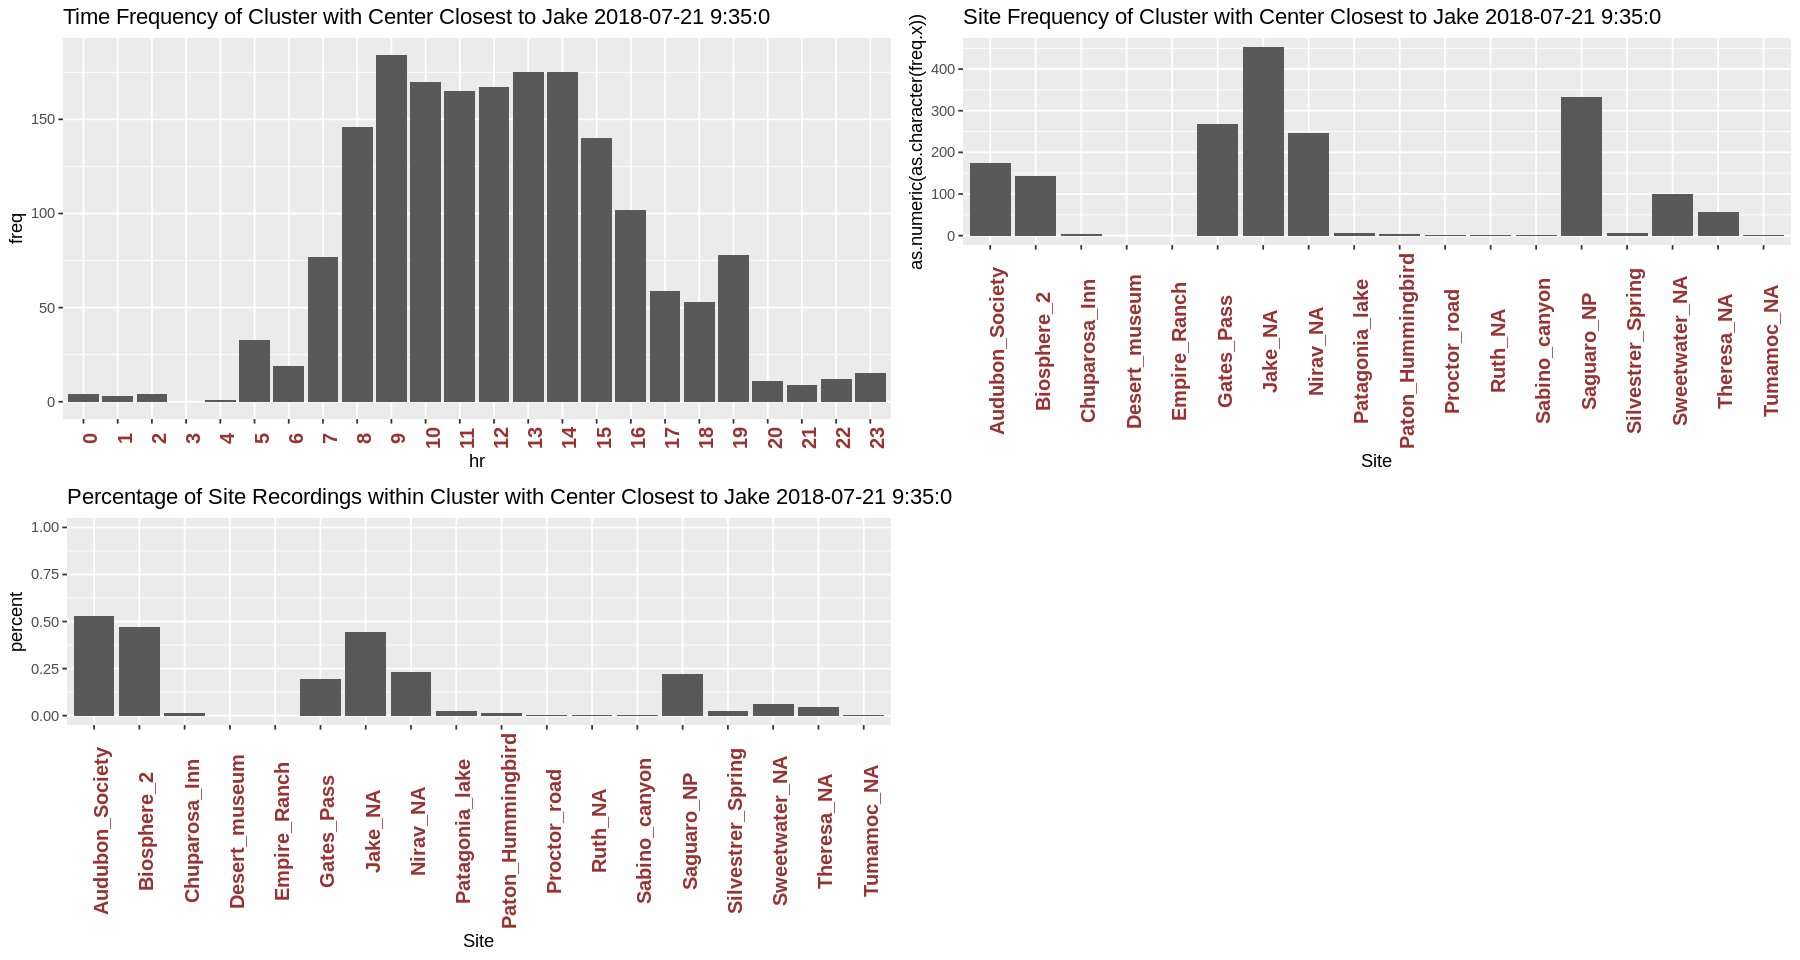

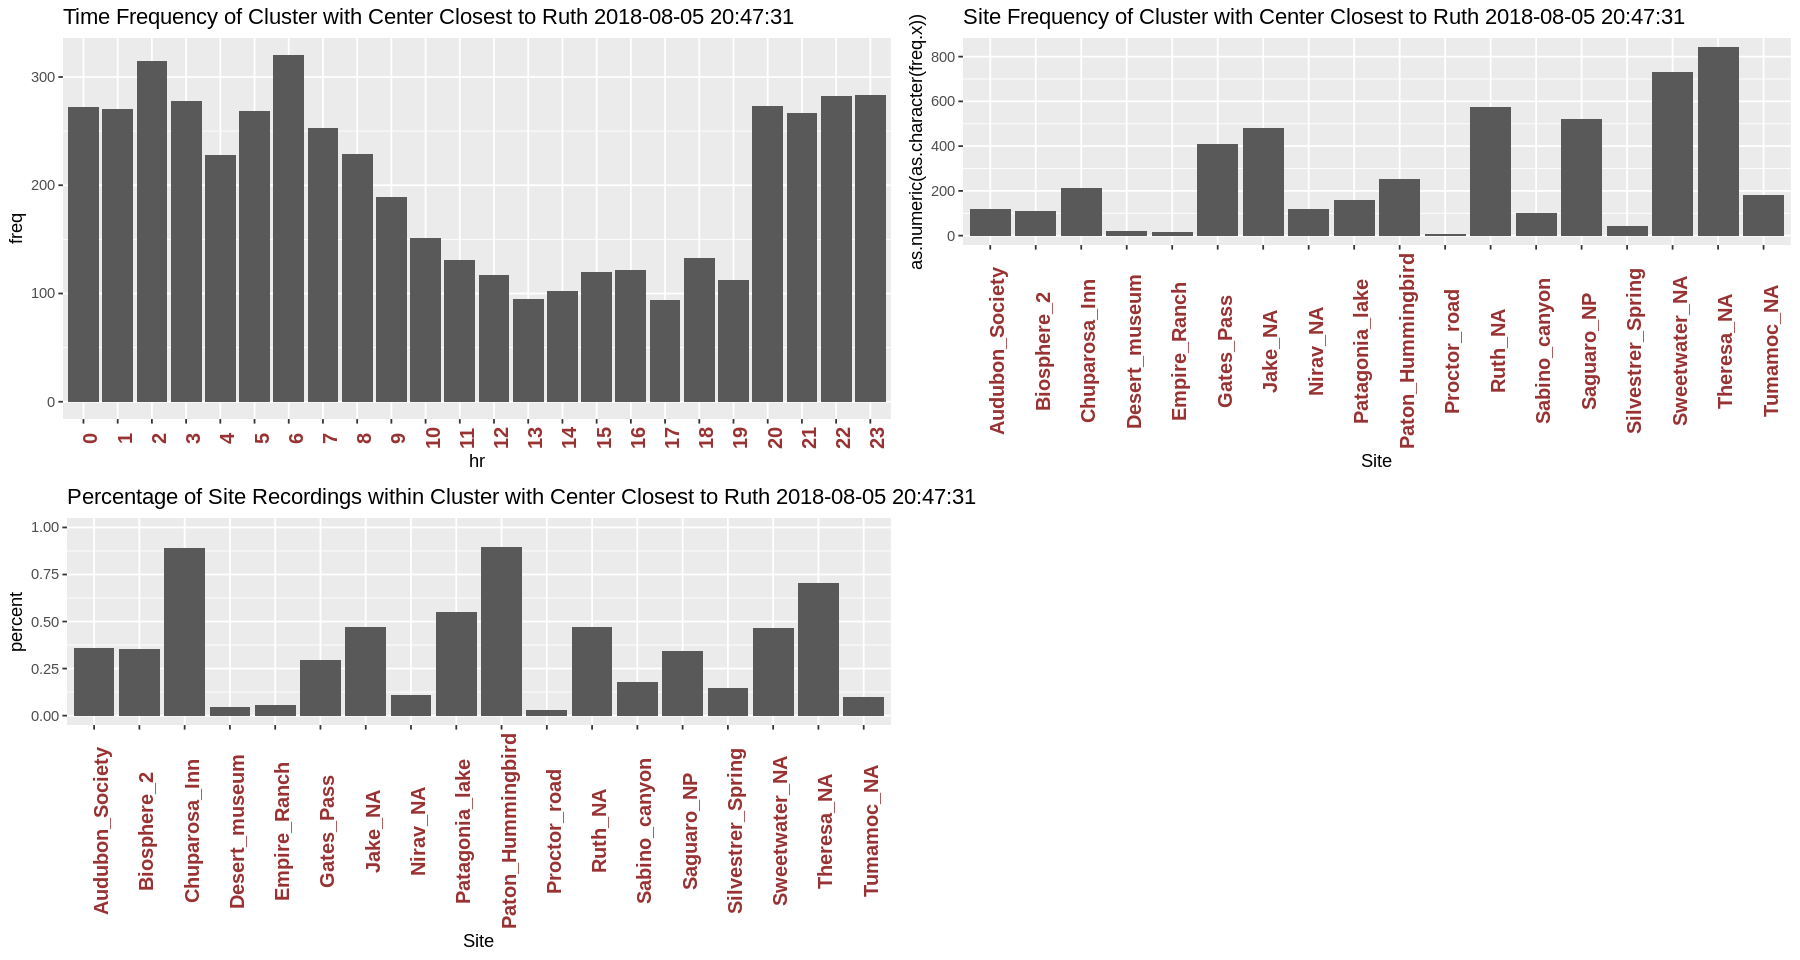

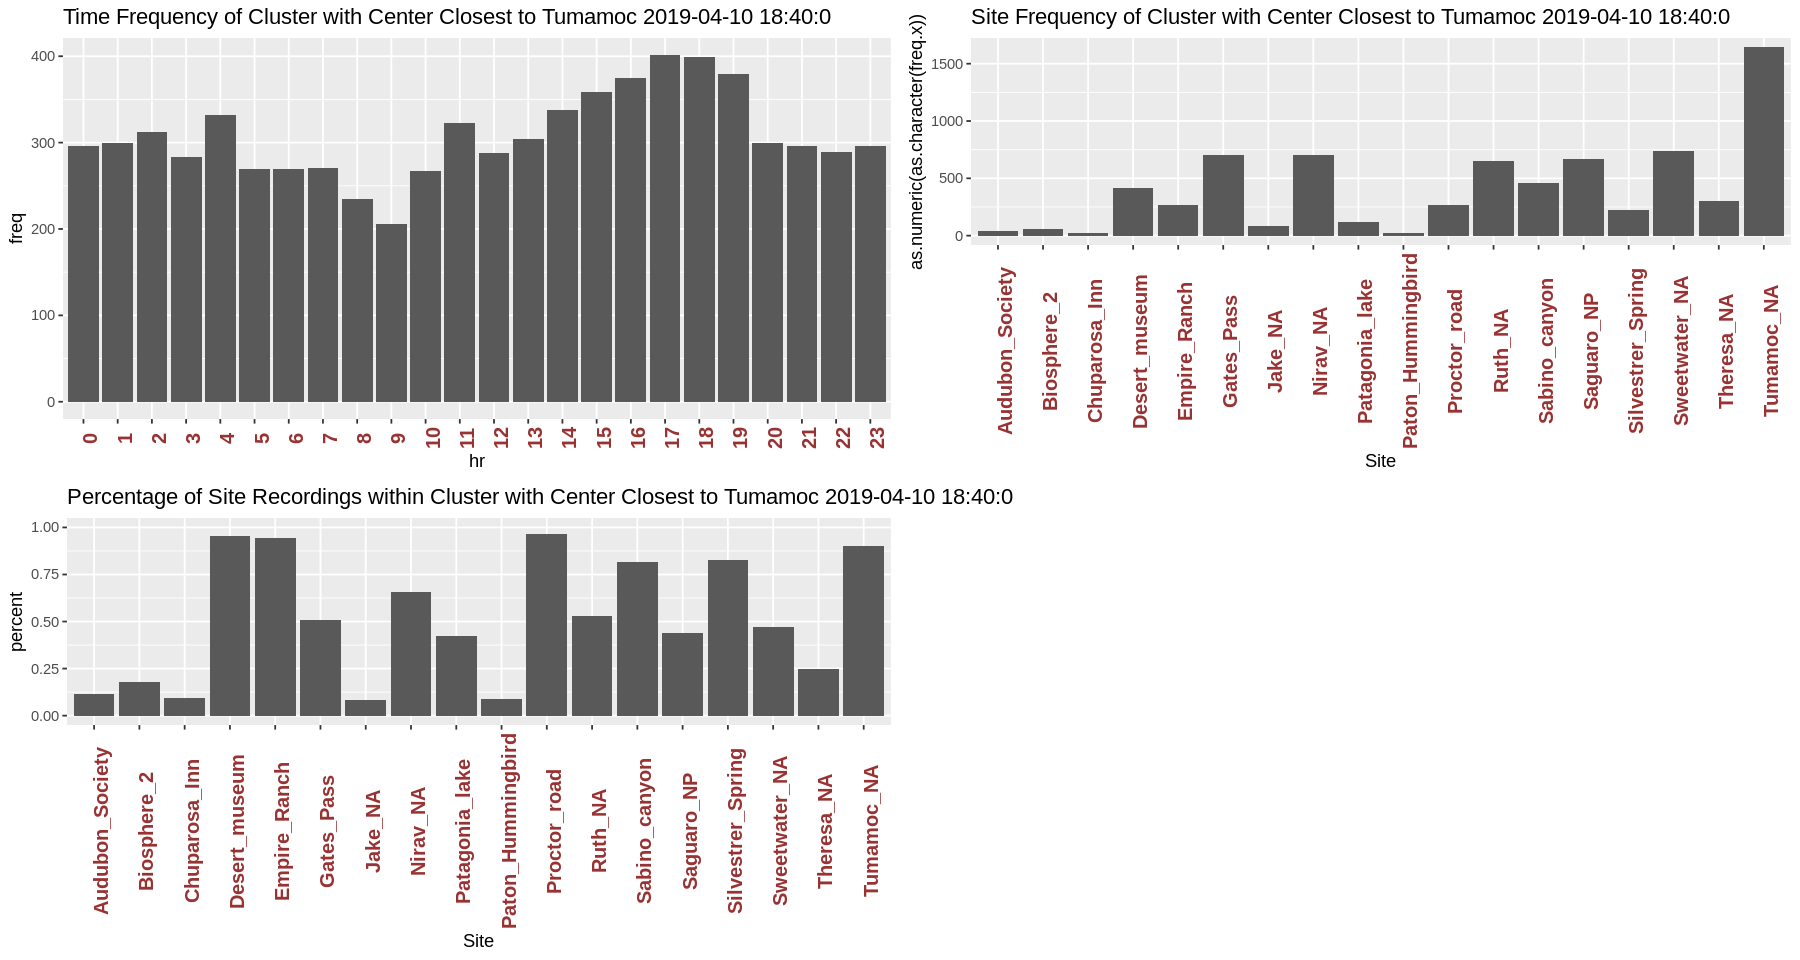

In [95]:
# K-Means Clustering with 3 clusters
fit <- kmeans(index_data[,4:13],3,iter.max=30)
fit$size
fit$centers
# Cluster Plot against 1st 2 principal components

# vary parameters for most readable graph
clusplot(index_data[,4:13], fit$cluster, color=FALSE, shade=FALSE,
   labels=2, lines=0)

histogram_plotter(fit,data.frame(index_data, fit$cluster) )

[1] 3416 5882  251 4544

bioacoustic....double.. amplitude....double.. temporal_entropy....double..
1 -0.22561977              0.6099955            -1.1278173                  
2  0.04487019             -0.2555333             0.4448586                  
3 -1.27261388              0.5668526            -0.1696576                  
4  0.18182586             -0.1591060             0.2813710                  
  spectral_entropy....double.. acoustic_entropy....double..
1 -0.9951473                   -1.0247987                  
2 -0.2493620                   -0.2362465                  
3  2.1992372                    2.1800748                  
4  0.9494194                    0.9557912                  
  acoustic_diversity....double.. acoustic_evenness....double..
1 -0.8115235                      0.6489559                   
2 -0.4933323                      0.5167039                   
3  1.8494012                     -2.4728321                   
4  1.1465108                     -1.0201155                   
  acoustic_complexity....double.. nrows....double.. ndsi....double..
1  0.4460194                      -0.27900012       -0.3094227      
2 -0.4188623                      -0.15652758       -0.5342168      
3 -0.2302362                       5.91181256        1.1237701      
4  0.2196160                       0.08580428        0.8620565

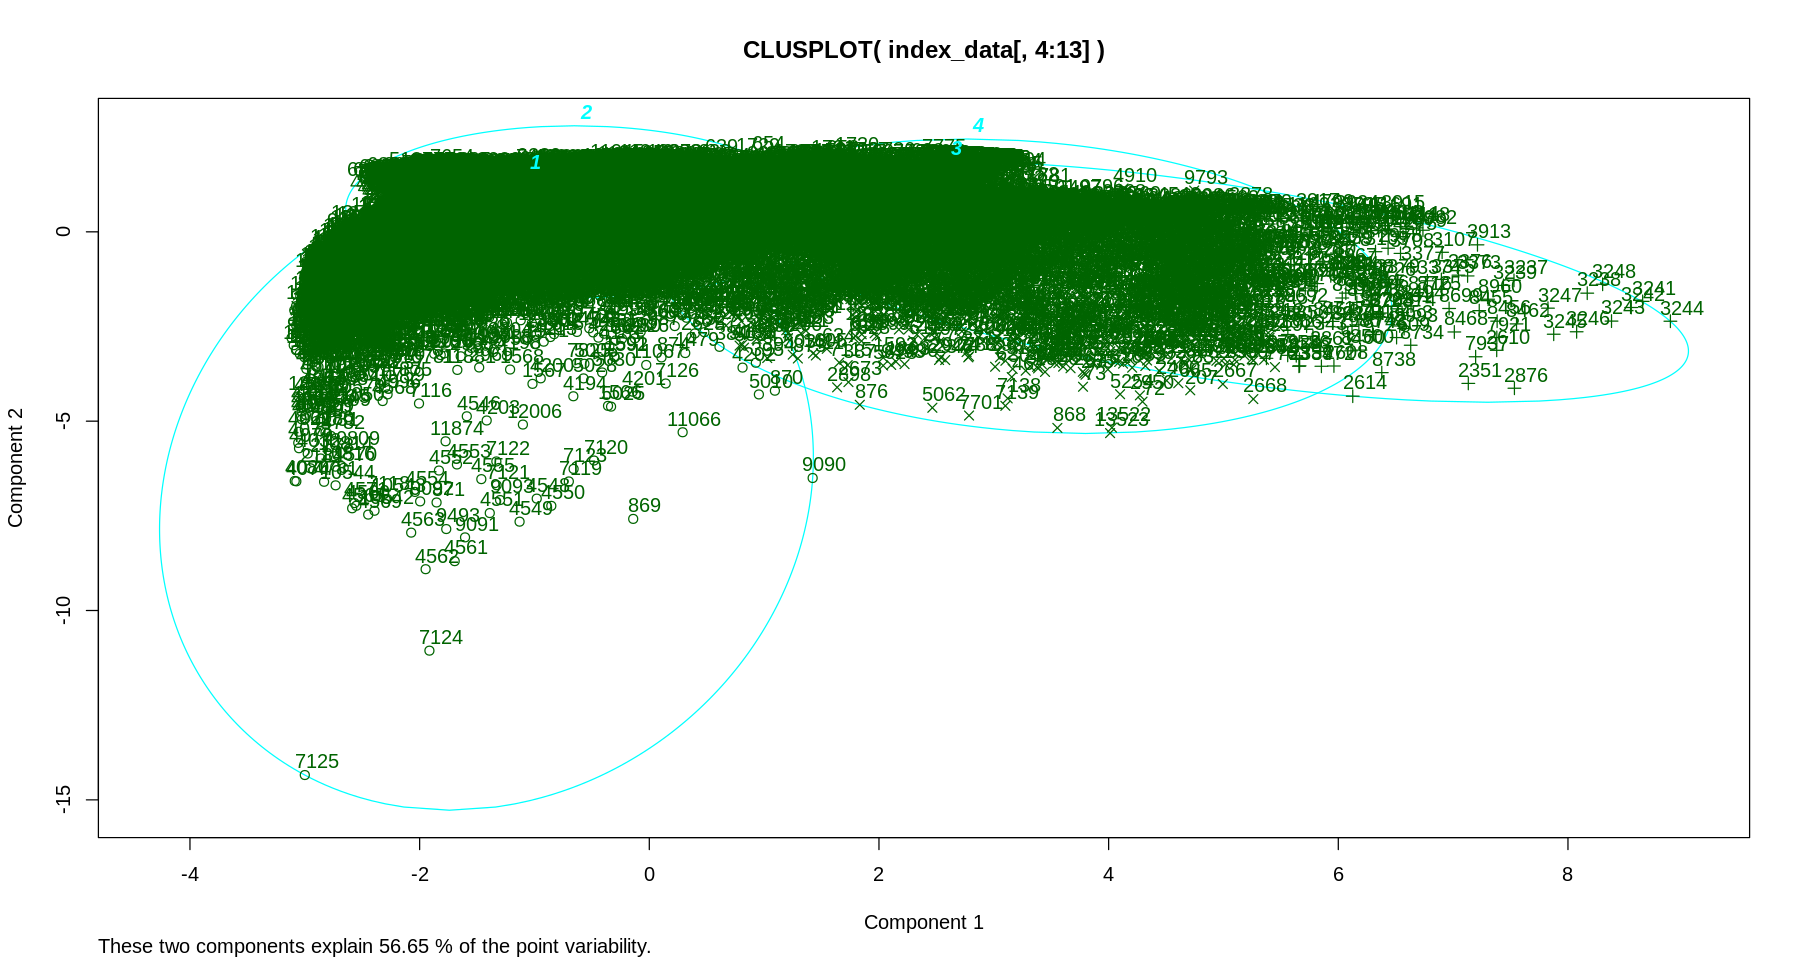

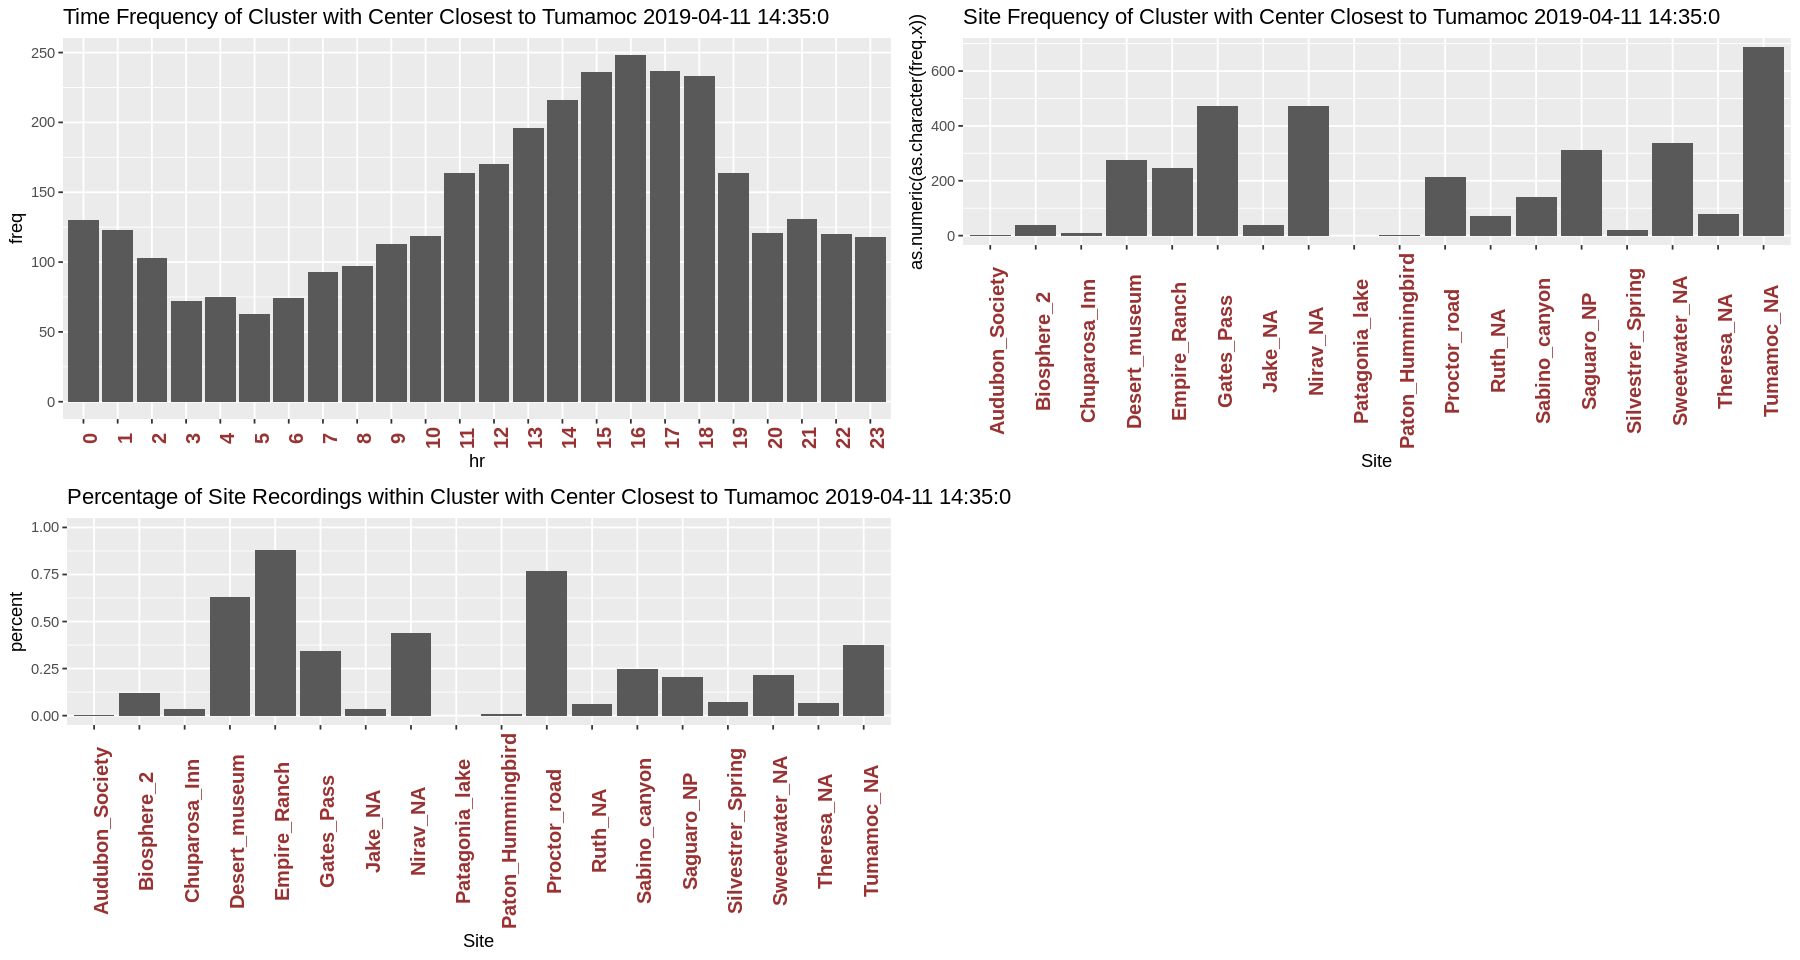

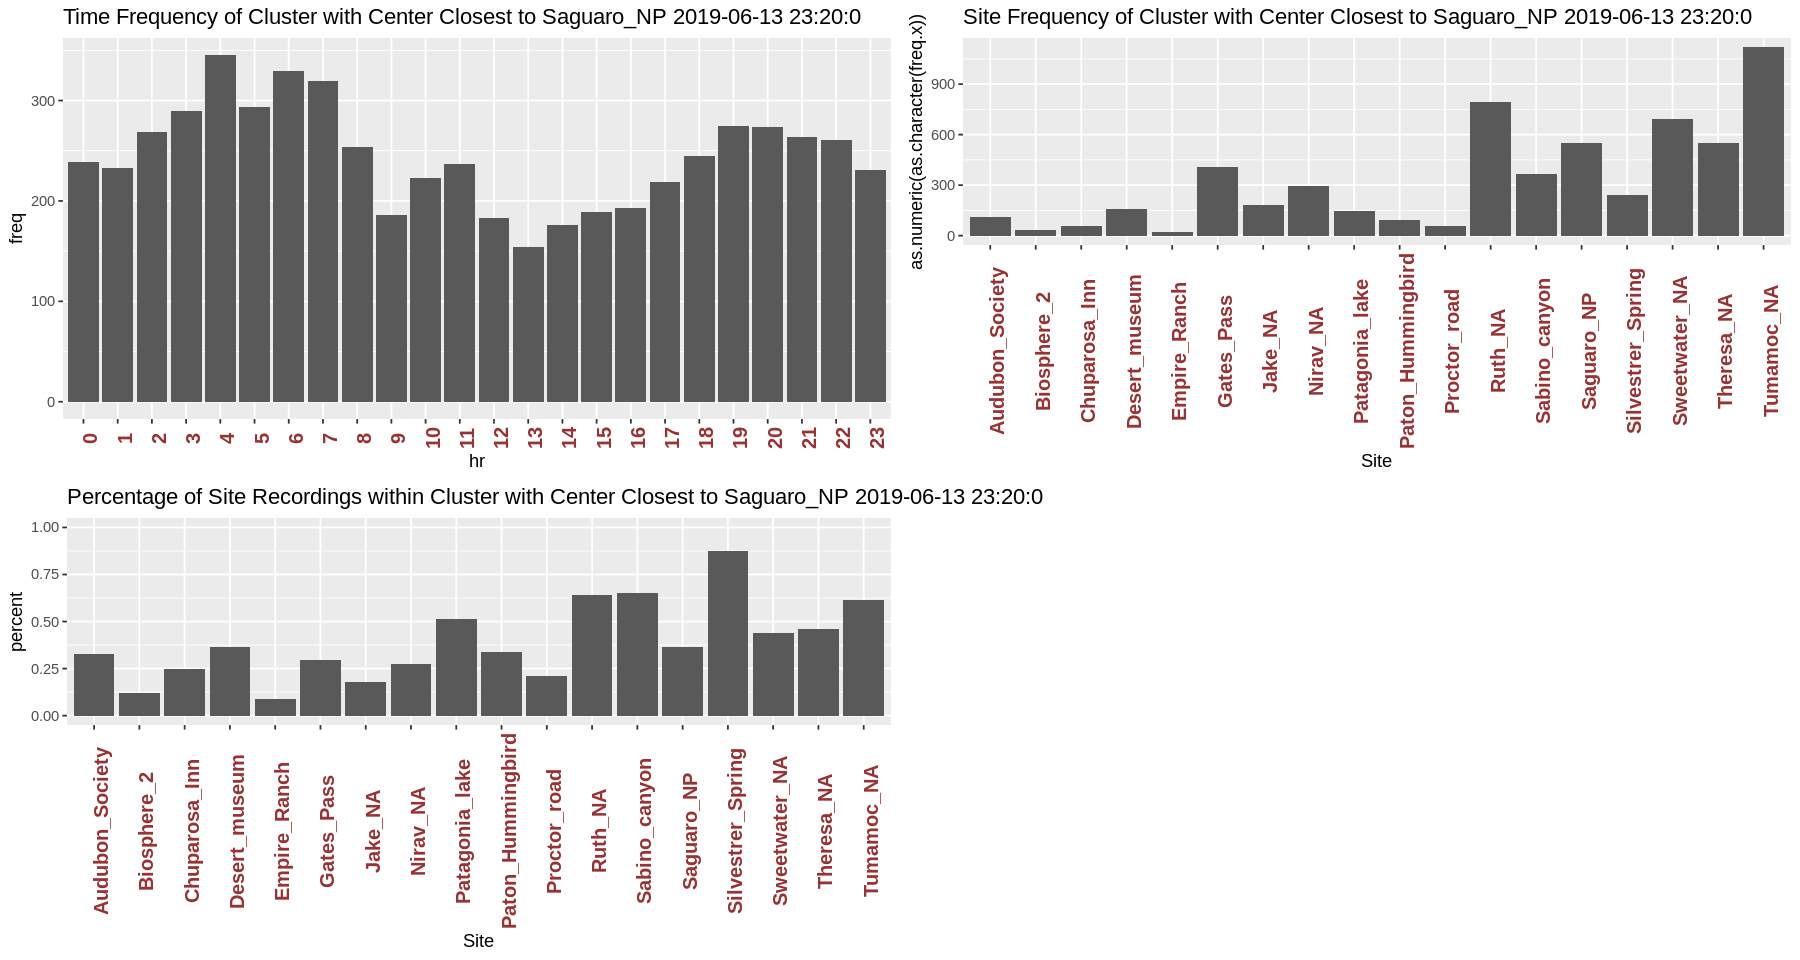

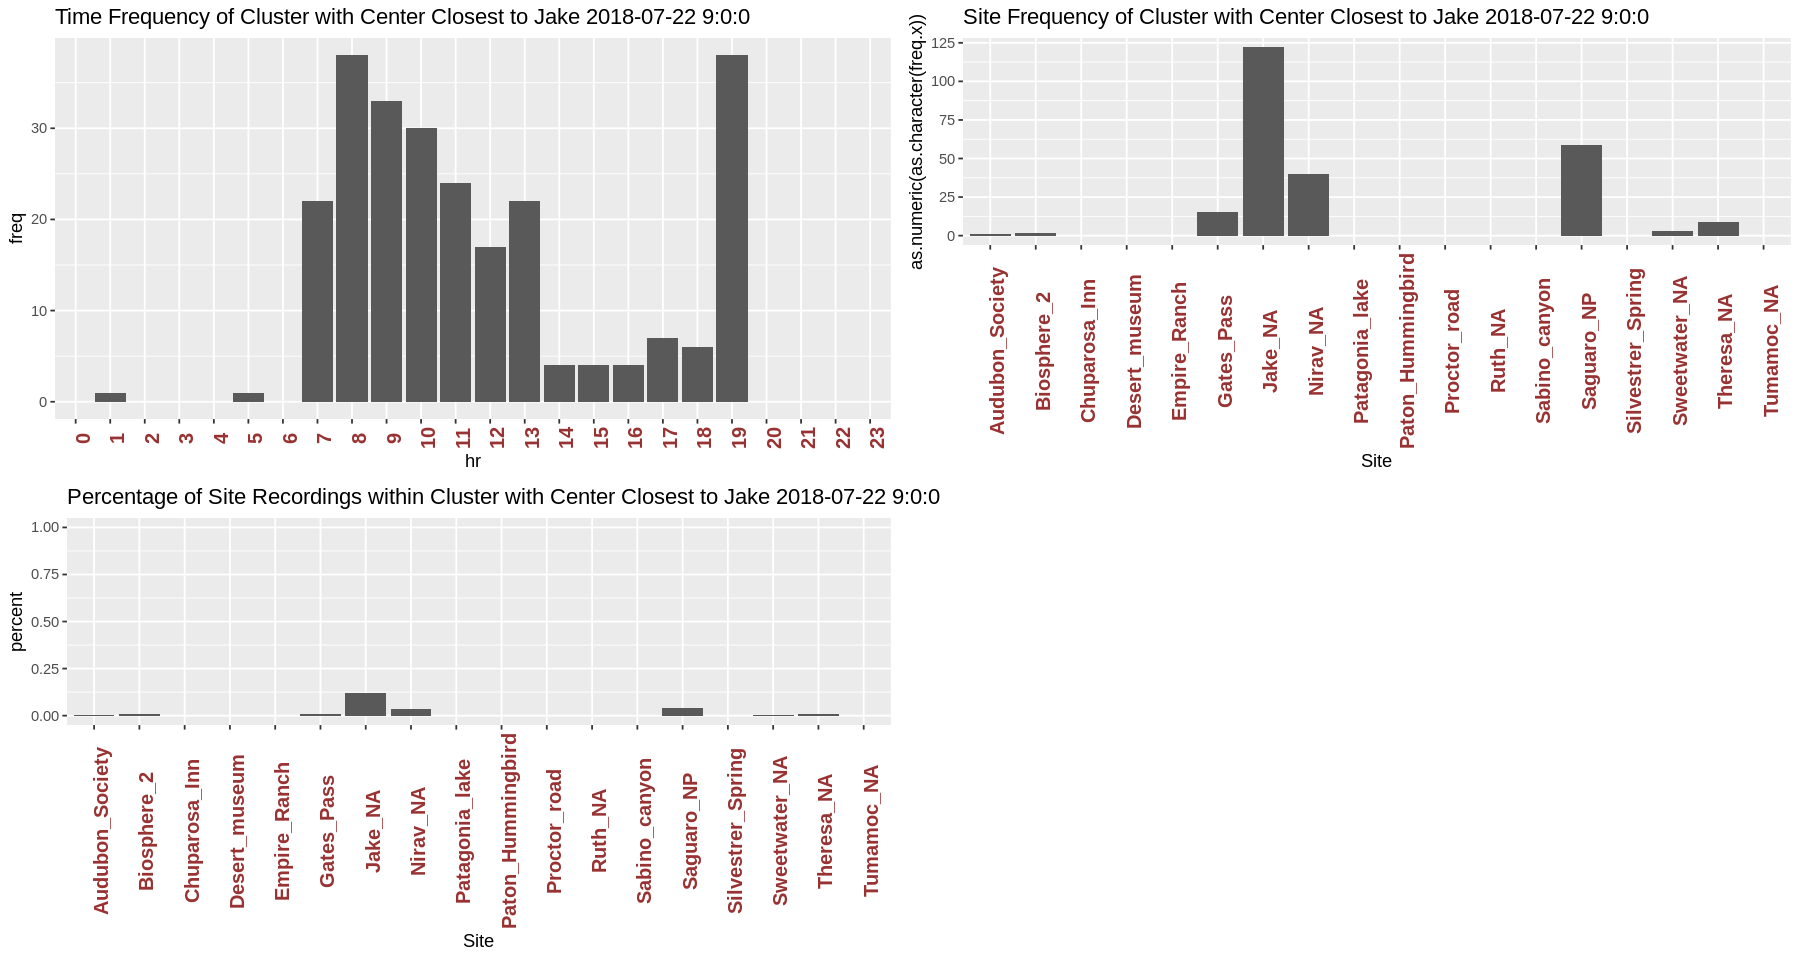

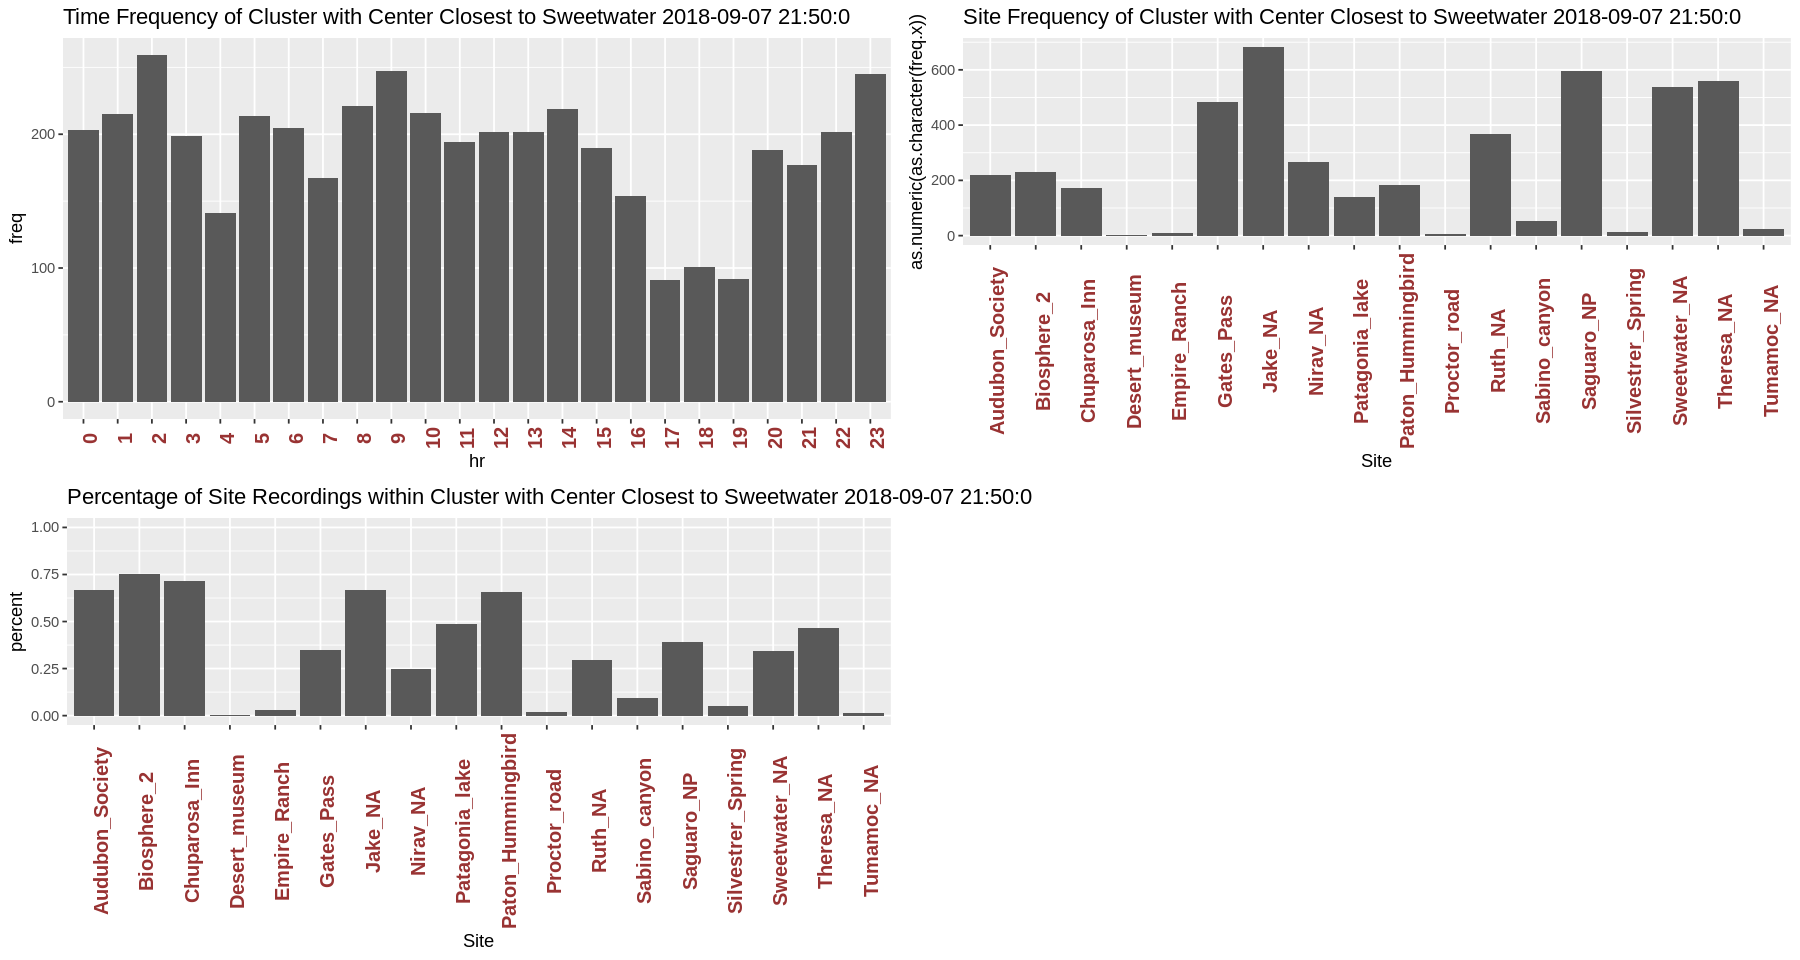

In [96]:
# K-Means Clustering with 4 clusters
fit <- kmeans(index_data[,4:13],4,iter.max=30)
fit$size
fit$centers
# Cluster Plot against 1st 2 principal components

# vary parameters for most readable graph
clusplot(index_data[,4:13], fit$cluster, color=FALSE, shade=FALSE,
   labels=2, lines=0)

histogram_plotter(fit,data.frame(index_data, fit$cluster) )

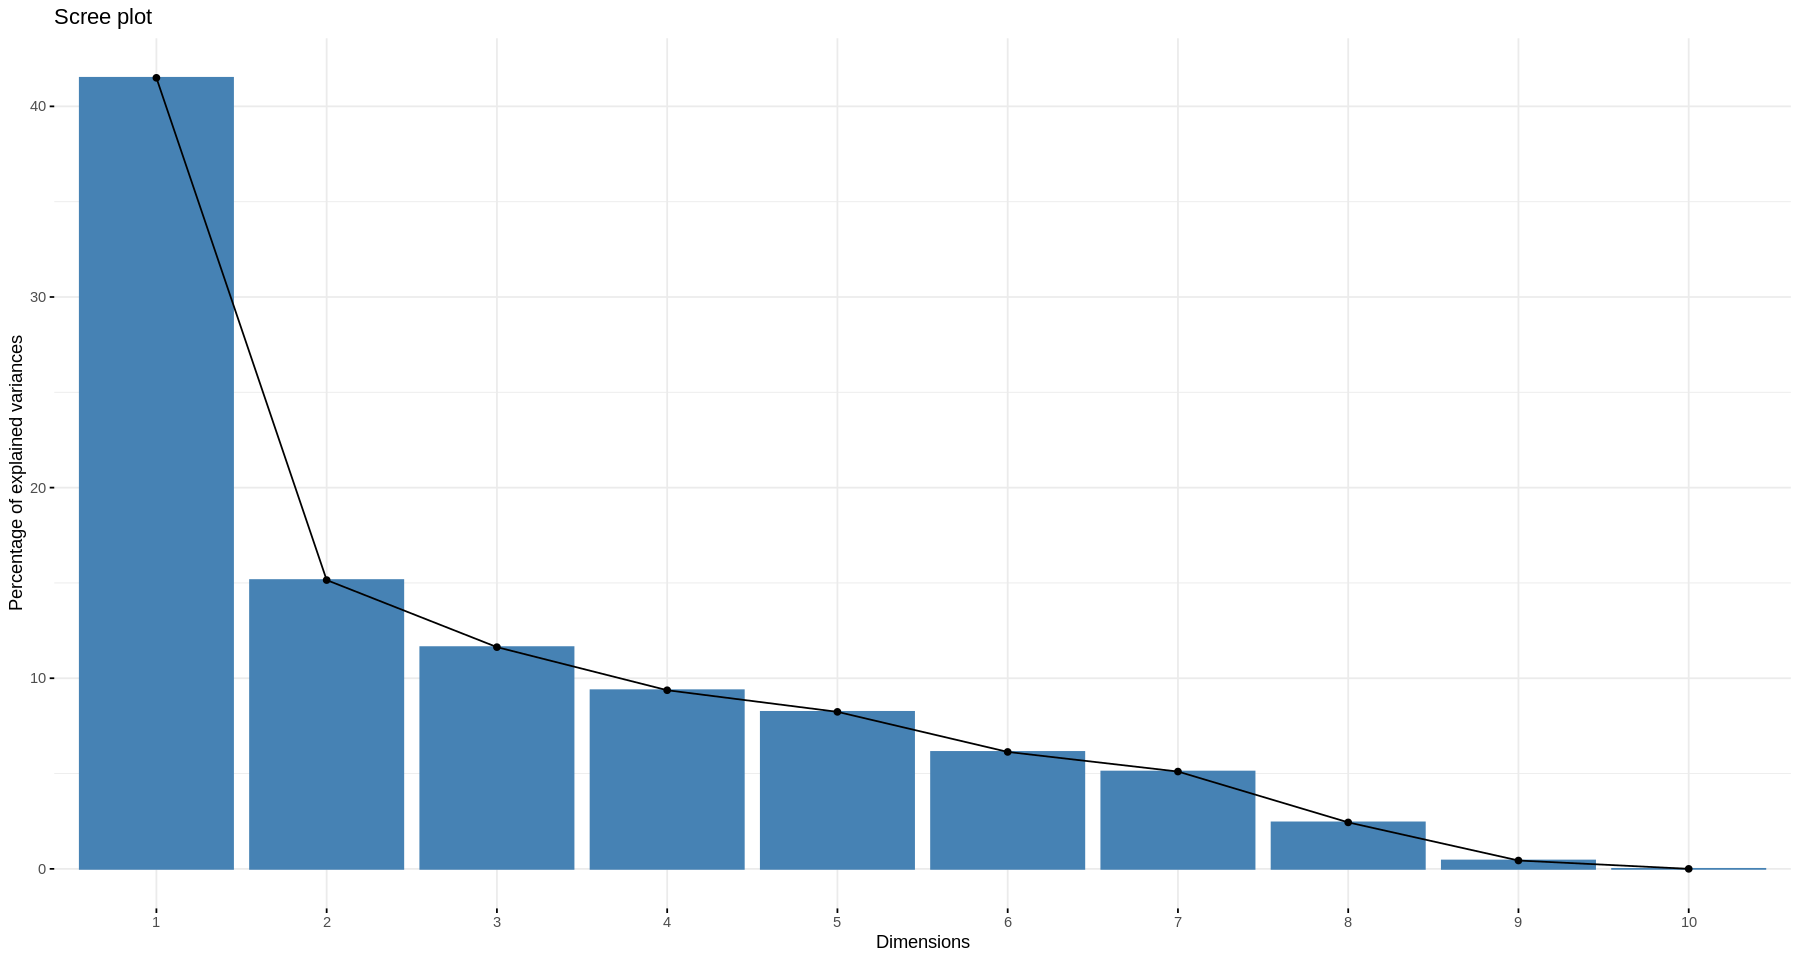

In [84]:
indices.pca <- prcomp(index_data[,4:13], scale = TRUE)
fviz_eig(indices.pca)